# Corn Crop Pest Detection with DenseNet121-Backboned Faster R-CNN: Comparative Analysis with FPN-ResNet50 and YOLOv8m


# Project

The study aims to propose and evaluate a customized Faster R-CNN framework with DenseNet as the backbone against Faster R-CNN with FPN-ResNet50 backbone and YoloV8m model.

# Dataset Used

IP102: A Large-Scale Benchmark Dataset for Insect Pest Recognition (Corn Crop Pest subset)

# Setup for Artifact Implementation

In [ ]:
!pip3 install gdown

## Mounting Necessary files saved on the google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip "/content/drive/MyDrive/files.zip"

Archive:  /content/drive/MyDrive/files.zip
  inflating: confusion_matrix.py     
  inflating: voc_evaluator.py        


In [ ]:
!unzip "/content/drive/MyDrive/pest-dataset.zip"

Archive:  /content/drive/MyDrive/pest-dataset.zip
  inflating: VOC2007/JPEGImages.tar  
  inflating: VOC2007/ImageSets/Main/trainval.txt  
  inflating: VOC2007/ImageSets/Main/test.txt  
  inflating: VOC2007/Annotations.tar  


## Install Necessary Libraries

In [ ]:
# Standard library imports
import os
import xml.etree.ElementTree as ET
from collections import Counter
import shutil
import json
from itertools import chain
from IPython.display import display, Image as Img

# Third party imports
import torch
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone, BackboneWithFPN
from torchvision.models import densenet121
from torchvision.transforms import functional as F
import torchvision.transforms as T
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from tqdm import tqdm
import numpy as np

# Local imports from uploaded files
import confusion_matrix
from confusion_matrix import ConfusionMatrix as cm
import voc_evaluator
from voc_evaluator import from_dict_to_boundingbox, get_pascalvoc_metrics, MethodAveragePrecision, plot_precision_recall_curve

### Check Version of Libraries

In [ ]:
print("Torch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("Numpy version:", np.__version__)

Torch version: 2.2.1+cu121
Torchvision version: 0.17.1+cu121
Numpy version: 1.25.2


## Set Preferred encoding

To avoid issues with character encoding when dealing with text data or file paths, we set the preferred encoding to "UTF-8".


In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

# Data Collection

We first change our current working directory to "VOC2007". Then, we extract the contents of two tar files: "Annotations.tar" and "JPEGImages.tar". These files contain the annotations and images for our dataset, respectively.

In [ ]:
%cd VOC2007
!tar -xvf Annotations.tar
!tar -xvf JPEGImages.tar

Streaming output truncated to the last 5000 lines.
JPEGImages/IP100000425.jpg
JPEGImages/IP068004921.jpg
JPEGImages/IP100000283.jpg
JPEGImages/IP102005470.jpg
JPEGImages/IP024000052.jpg
JPEGImages/IP025000022.jpg
JPEGImages/IP079000242.jpg
JPEGImages/IP011000255.jpg
JPEGImages/IP068002142.jpg
JPEGImages/IP056000013.jpg
JPEGImages/IP102003039.jpg
JPEGImages/IP015000988.jpg
JPEGImages/IP048000319.jpg
JPEGImages/IP047000349.jpg
JPEGImages/IP024001308.jpg
JPEGImages/IP024001166.jpg
JPEGImages/IP102003236.jpg
JPEGImages/IP024001363.jpg
JPEGImages/IP048000374.jpg
JPEGImages/IP068003059.jpg
JPEGImages/IP043000271.jpg
JPEGImages/IP102005538.jpg
JPEGImages/IP024001908.jpg
JPEGImages/IP100000548.jpg
JPEGImages/IP102005593.jpg
JPEGImages/IP018000018.jpg
JPEGImages/IP024000175.jpg
JPEGImages/IP102002245.jpg
JPEGImages/IP068003453.jpg
JPEGImages/IP011000378.jpg
JPEGImages/IP024000917.jpg
JPEGImages/IP050000063.jpg
JPEGImages/IP018000815.jpg
JPEGImages/IP102001254.jpg
JPEGImages/IP024001289.jpg
JPEG

In [ ]:
%cd ..

/content


## Data Exploration

We are reading the XML annotation files in our dataset and counting the number of instances of each class. This gives us an idea of the distribution of classes in our dataset.


In [ ]:
base_dir = 'VOC2007'
annotations_dir = os.path.join(base_dir, 'Annotations')

def get_classes(file_path):
    with open(file_path, 'r') as file:
        xml_content = file.read()
    try:
        root = ET.fromstring(xml_content)
    except ET.ParseError:
        return []
    classes = [obj.find('name').text for obj in root.findall('.//object')]
    return classes

class_counter = Counter()

for xml_file in os.listdir(annotations_dir):
    xml_file_path = os.path.join(annotations_dir, xml_file)
    classes = get_classes(xml_file_path)
    class_counter.update(classes)

print("Classes and their counts:")
for cls, count in class_counter.items():
    print(f"{cls}: {count}")

Classes and their counts:
20: 209
78: 370
86: 436
3: 179
37: 384
101: 2975
48: 552
50: 476
15: 877
84: 131
53: 65
41: 100
16: 532
67: 338
70: 1268
24: 1395
51: 1013
45: 435
69: 206
46: 237
27: 310
39: 420
1: 130
28: 72
29: 125
21: 168
25: 238
38: 266
26: 254
18: 317
19: 176
8: 78
66: 279
42: 157
83: 58
68: 157
23: 216
11: 119
4: 82
92: 77
14: 676
22: 440
43: 100
17: 60
99: 140
81: 46
76: 290
32: 64
47: 365
82: 148
7: 117
62: 176
87: 133
96: 66
44: 91
85: 27
73: 108
49: 270
0: 190
33: 108
35: 27
94: 150
95: 183
74: 82
31: 72
56: 57
34: 146
64: 73
12: 20
9: 54
54: 48
10: 153
100: 65
6: 28
71: 112
58: 224
5: 95
90: 28
36: 34
77: 546
88: 23
93: 22
91: 8
40: 71
79: 183
65: 31
97: 60
89: 22
55: 20
13: 36
30: 25
52: 5
98: 13
57: 35
72: 13
2: 25
61: 2


## Data Preparation

We are preparing our dataset for training of models. This involves filtering the images based on the selected classes, copying the images to the appropriate directories, and also creating label files in the YOLO format for YoloV8 model.


In [ ]:
# Define directories for annotations, images, and splits
base_dir = 'VOC2007'
annotations_dir = os.path.join(base_dir, 'Annotations')
image_dir = os.path.join(base_dir, 'JPEGImages')
splits_dir = os.path.join(base_dir, 'ImageSets', 'Main')

# Define new trainval and test files
new_trainval_file = os.path.join(base_dir, 'dataset-trainval.txt')
new_test_file = os.path.join(base_dir, 'dataset-test.txt')

# Define directories for YOLO dataset (images and labels for train and test)
yolo_dataset_dir_im_train = 'dataset-yolo/train/images/'
yolo_dataset_dir_txt_train = 'dataset-yolo/train/labels/'
yolo_dataset_dir_im_test = 'dataset-yolo/test/images/'
yolo_dataset_dir_txt_test = 'dataset-yolo/test/labels/'

# Create directories if they don't exist
os.makedirs(yolo_dataset_dir_im_train, exist_ok=True)
os.makedirs(yolo_dataset_dir_txt_train, exist_ok=True)
os.makedirs(yolo_dataset_dir_im_test, exist_ok=True)
os.makedirs(yolo_dataset_dir_txt_test, exist_ok=True)

# Define classes of interest
classes_of_interest = set(map(str, range(14, 27)))

# Function to safely parse XML content
def safe_parse(xml_content):
    try:
        root = ET.fromstring(xml_content)
    except ET.ParseError as e:
        try:
            root = ET.fromstring('<annotations>' + xml_content + '</annotations>')
        except ET.ParseError:
            return None
    return root

# Function to parse XML file and check if it contains any objects of the classes of interest
def parse_xml(file_path):
    with open(file_path, 'r') as file:
        xml_content = file.read()
    root = safe_parse(xml_content)
    if root is None:
        return False
    for obj in root.findall('.//object'):
        cls = obj.find('name').text
        if cls in classes_of_interest:
            return True
    return False

# Function to filter images based on the classes of interest, copy the images to the appropriate directories, and create label files in the YOLO format
def filter_images(split_file, output_file, yolo_dataset_dir_txt, yolo_dataset_dir_im):
    with open(split_file, 'r') as f, open(output_file, 'w') as out:
        for line in f:
            image_name = line.strip()
            xml_file = os.path.join(annotations_dir, image_name + '.xml')
            if os.path.exists(xml_file) and parse_xml(xml_file):
                out_file = open(yolo_dataset_dir_txt + image_name + '.txt', 'a')
                out.write(image_name + '\n')
                src_im = os.path.join(image_dir, image_name + '.jpg')
                dst_im = f'{yolo_dataset_dir_im}{image_name}.jpg'
                shutil.copy(src_im, dst_im)

                with open(xml_file, 'r') as xml_file:
                    xml_content = xml_file.read()
                try:
                    root = ET.fromstring(xml_content)
                except ET.ParseError:
                    root = ET.fromstring('<root>' + xml_content + '</root>')

                size = root.find('size')
                w = int(size.find('width').text)
                h = int(size.find('height').text)
                for obj in root.findall('.//object'):
                    label = int(obj.find('name').text)
                    if label < 14 or label > 26:
                        continue
                    label = label - 14  # rearrange the ids from 0-12
                    bndbox = obj.find('bndbox')
                    xmin = int(bndbox.find('xmin').text)
                    ymin = int(bndbox.find('ymin').text)
                    xmax = int(bndbox.find('xmax').text)
                    ymax = int(bndbox.find('ymax').text)

                    b = (xmin, xmax, ymin, ymax)
                    bb = convert((w,h), b)
                    out_file.write(str(label) + " " + " ".join([str(a) for a in bb]) + '\n')

# Function to convert bounding box coordinates to the YOLO format
def convert(size, box):
    dw = 1./(size[0])
    dh = 1./(size[1])
    x = (box[0] + box[1])/2.0 - 1
    y = (box[2] + box[3])/2.0 - 1
    w = box[1] - box[0]
    h = box[3] - box[2]
    x = x*dw
    w = w*dw
    y = y*dh
    h = h*dh
    return (x,y,w,h)

# Filter images for the training and testing datasets
filter_images(os.path.join(splits_dir, 'trainval.txt'), new_trainval_file, yolo_dataset_dir_txt_train, yolo_dataset_dir_im_train)
filter_images(os.path.join(splits_dir, 'test.txt'), new_test_file, yolo_dataset_dir_txt_test, yolo_dataset_dir_im_test)

print('Filtered trainval and test files have been created.')

Filtered trainval and test files have been created.


**Splitting the Yolo Dataset**

We are splitting our YOLO dataset into training and validation sets. We move 15% of the training images and their corresponding label files to the validation directories.

In [ ]:
def data_generator(curr_im_dir, curr_txt_dir, dest_im_dir, dest_txt_dir, percentage_to_move):
    # Defining percentage of images to be used for the valid set
    total_image_count = 0
    total_valid_image_count = 0
    total_train_count = 0

    counter = 1
    index_test = round(100 / percentage_to_move)
    for file in os.listdir(curr_txt_dir):
        title, ext = os.path.splitext(os.path.basename(file))
        if ext == '.txt':
            src_im_path = f'{curr_im_dir}{title}.png'
            dest_im_path = f'{dest_im_dir}{title}.png'
            if not os.path.exists(src_im_path):
                src_im_path = f'{curr_im_dir}{title}.jpg'
                dest_im_path = f'{dest_im_dir}{title}.jpg'
                if not os.path.exists(src_im_path):
                    print('No image: {src_im_path}')

            src_txt_path = f'{curr_txt_dir}{title}{ext}'
            dest_txt_path = f'{dest_txt_dir}{title}{ext}'
            total_image_count += 1
            if counter == index_test:
                total_valid_image_count += 1
                counter = 1
                shutil.move(src=src_im_path, dst=dest_im_path)
                shutil.move(src=src_txt_path, dst=dest_txt_path)
            else:
                total_train_count += 1
                counter += 1

    print(total_image_count)
    print(total_valid_image_count)
    print(total_train_count)

valid_im_dir = 'dataset-yolo/valid/images/'
valid_txt_dir = 'dataset-yolo/valid/labels/'
os.makedirs(valid_im_dir, exist_ok=True)
os.makedirs(valid_txt_dir, exist_ok=True)

data_generator(yolo_dataset_dir_im_train, yolo_dataset_dir_txt_train, valid_im_dir, valid_txt_dir, percentage_to_move=15)

3629
518
3111


In [ ]:
# moving the "dataset-yolo" directory to a new directory called "datasets".
!mkdir datasets
!mv dataset-yolo datasets/


# Faster RCNN Model

## Model Building

We define a class `FasterRCNNBuilder` that is used to build a Faster R-CNN model with a specified backbone.

In [ ]:
class FasterRCNNBuilder:
    def __init__(self, num_classes, backbone_name='resnet50', pretrained=True):
        # Initialize the builder with the number of classes, the name of the backbone, and whether to use a pretrained backbone
        self.num_classes = num_classes
        self.backbone_name = backbone_name
        self.pretrained = pretrained
        self.backbone = self.get_backbone()

    def get_backbone(self):
        """Retrieve the specified backbone model."""
        # Check the backbone name and retrieve the corresponding model
        if self.backbone_name == "resnet50":
            backbone = resnet_fpn_backbone('resnet50', pretrained=self.pretrained)
        elif self.backbone_name == "densenet121":
            backbone = densenet121(pretrained=self.pretrained).features
            backbone.out_channels = 1024
        else:
            # Raise an error if the backbone name is not supported
            raise ValueError("Unsupported backbone")
        return backbone

    def create_model(self):
        """Create a Faster R-CNN model with the selected backbone."""
        # Define the anchor sizes
        anchor_sizes = ((16,), (32,), (64,), (256,), (512,))
        # Define the aspect ratios based on the backbone name
        if self.backbone_name == "densenet121":
            aspect_ratios = ((0.25, 0.5, 1.0, 2.0),)
        else:
            aspect_ratios = tuple((f,) for f in [0.5, 1, 2.0]) * len(anchor_sizes)
        # Create the anchor generator
        anchor_generator = AnchorGenerator(sizes=anchor_sizes,
                                           aspect_ratios=aspect_ratios)
        # Create the ROI pooler
        roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0', '1', '2', '3'],
                                                        output_size=[7, 7],
                                                        sampling_ratio=2)
        # Create the Faster R-CNN model
        model = FasterRCNN(self.backbone,
                           num_classes=self.num_classes,
                           rpn_anchor_generator=anchor_generator,
                           box_roi_pool=roi_pooler)

        # Set the image mean, image std, min size, and max size
        model.image_mean = [0.485, 0.456, 0.406]
        model.image_std = [0.229, 0.224, 0.225]
        model.min_size = 416
        model.max_size = 1024

        # Replace the box predictor with a new one with the correct number of classes
        in_features = model.roi_heads.box_predictor.cls_score.in_features
        model.roi_heads.box_predictor = FastRCNNPredictor(in_features, self.num_classes)
        return model


## Data Handling OR Data Loader

We define several classes and functions for handling the dataset.


In [ ]:
class VOCDataset(Dataset):
    def __init__(self, root, annotations_file, transforms=None):
        # Initialize the dataset with the root directory, annotations file, and any transforms
        self.root = root
        self.transforms = transforms
        self.annotations = [line.strip() for line in open(os.path.join(root, annotations_file)).readlines()]

    def parse_voc_xml(self, file):
        # Parse the VOC XML annotations file to get the bounding boxes and labels
        with open(file, 'r') as xml_file:
            xml_content = xml_file.read()
        try:
            root = ET.fromstring(xml_content)
        except ET.ParseError:
            root = ET.fromstring('<root>' + xml_content + '</root>')
        boxes = []
        labels = []
        for obj in root.findall('.//object'):
            label = int(obj.find('name').text)
            if label < 14 or label > 26:
                continue
            label = label - 14  # rearrange the ids from 0-12

            bndbox = obj.find('bndbox')
            xmin = int(bndbox.find('xmin').text)
            ymin = int(bndbox.find('ymin').text)
            xmax = int(bndbox.find('xmax').text)
            ymax = int(bndbox.find('ymax').text)
            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(label)
        return boxes, labels

    def __getitem__(self, idx):
        # Get the image and target for the given index
        image_idx = idx
        img_name = self.annotations[idx]
        img_path = os.path.join(self.root, 'JPEGImages', img_name + '.jpg')
        image = Image.open(img_path)
        annotation_path = os.path.join(self.root, 'Annotations', img_name + '.xml')
        boxes, labels = self.parse_voc_xml(annotation_path)

        boxes = torch.as_tensor(boxes, dtype=torch.float32)

        areas = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        target = {'boxes': boxes, 'labels': torch.as_tensor(labels, dtype=torch.int64), 'area': areas, 'image_id': torch.tensor([image_idx])}
        if self.transforms is not None:
            image, target = self.transforms(image, target)
        return image, target, img_name

    def __len__(self):
        # Return the length of the dataset
        return len(self.annotations)

def get_transform(imsize):
    # Return a Compose transform that converts images to tensors and resizes them
    transform = Compose([ToTensor(), Resize(size=imsize)])
    return transform

def collate_fn(batch):
    # Collate the batch data in a specific way
    return tuple(zip(*batch))

def create_data_loaders(root, annotations_file, batch_size, split_ratio=0.8, imsize=(416, 416)):
    # Create the training and validation data loaders for the VOC dataset
    dataset = VOCDataset(root, annotations_file, transforms=get_transform(imsize))

    train_size = int(split_ratio * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

    return train_loader, val_loader


class Compose(object):
    # Class that composes several transforms together
    def __init__(self, transforms):
        self.transforms = transforms
    def __call__(self, image, target):
        for t in self.transforms:
            image, target = t(image, target)
        return image, target


class ToTensor(object):
    # Class that converts images to tensors
    def __call__(self, image, target):
        image = F.to_tensor(image)
        return image, target


class Resize(object):
    # Class that resizes images and their bounding boxes
    def __init__(self, size):
        assert isinstance(size, (int, tuple))
        self.size = size

    def __call__(self, image, target):
        h_old, w_old = image.shape[-2:]
        image = F.resize(image, self.size)
        bbox = target["boxes"]
        w_new, h_new = self.size
        scale_w = w_new / w_old
        scale_h = h_new / h_old
        new_boxes = bbox.clone()
        new_boxes[:, 0] = bbox[:, 0] * scale_w  # xmin
        new_boxes[:, 2] = bbox[:, 2] * scale_w  # xmax
        new_boxes[:, 1] = bbox[:, 1] * scale_h  # ymin
        new_boxes[:, 3] = bbox[:, 3] * scale_h  # ymax
        target["boxes"] = new_boxes
        return image, target

**Count Samples of Data**

We count the number of occurrences of each label in the training and validation datasets.

In [ ]:
# Define the root directory and annotations file
root = 'VOC2007'
annotations_file = 'dataset-trainval.txt'

# Initialize counters for the training and validation data
counter_train = {}
counter_val = {}

# Create the training and validation data loaders
train_loader, val_loader = create_data_loaders(root, annotations_file, batch_size=16)

# Iterate over the training data
for images, targets, _ in train_loader:
    annotations = [{k: v for k, v in t.items()} for t in targets]
    for annotation in annotations:
        true_labels = annotation.get('labels', []).cpu().numpy()
        for label in true_labels:
            if label not in counter_train:
                counter_train[label] = 1
            else:
                counter_train[label] = counter_train[label] + 1
print('Training data count:')
print(dict(sorted(counter_train.items())))

# Validation data count
for images, targets, _ in val_loader:
    annotations = [{k: v for k, v in t.items()} for t in targets]
    for annotation in annotations:
        true_labels = annotation.get('labels', []).cpu().numpy()
        for label in true_labels:
            if label not in counter_val:
                counter_val[label] = 1
            else:
                counter_val[label] = counter_val[label] + 1
print('Validation data count:')
print(dict(sorted(counter_val.items())))

Training data count:
{0: 439, 1: 556, 2: 349, 3: 37, 4: 196, 5: 110, 6: 136, 7: 104, 8: 274, 9: 143, 10: 878, 11: 158, 12: 169}
Validation data count:
{0: 119, 1: 145, 2: 74, 3: 10, 4: 54, 5: 26, 6: 30, 7: 27, 8: 76, 9: 32, 10: 235, 11: 33, 12: 35}


## Model Evaluation

We define a function "evaluate" that evaluates the model on a given data loader.


In [ ]:
@torch.no_grad()
def evaluate(model, data_loader, device, iou_threshold=0.5, valcount=False, show_matrices=True):
    torch.set_num_threads(1)

    # Set the model to evaluation mode
    model.eval()
    # Initialize lists for all detections and ground truths
    all_detections = []
    all_ground_truths = []
    class_names = [
                    "grub",                # 14
                    "mole cricket",        # 15
                    "wireworm",            # 16
                    "white margined moth", # 17
                    "black cutworm",       # 18
                    "large cutworm",       # 19
                    "yellow cutworm",      # 20
                    "red spider",          # 21
                    "corn borer",          # 22
                    "army worm",           # 23
                    "aphids",              # 24
                    "Potosia vitarsis",    # 25
                    "Peach borer"          # 26
                    ""
            ]
    # Initialize a confusion matrix
    confm = cm(num_classes=13, class_names=class_names)
    eval_outputs = []
    counter_val = {}

    # Iterate over the data loader
    for image, targets, img_name in data_loader:
        image = list(img.to(device) for img in image)
        if device != torch.device("cpu"):
            torch.cuda.synchronize(device)
        # Get the model's predictions
        outputs = model(image)
        # Convert the targets and predictions to bounding boxes
        gt_boxes = [
                        from_dict_to_boundingbox(file=target, name=name, groundtruth=True)
                        for target, name in zip(targets, img_name)
                    ]
        gt_boxes = list(chain(*gt_boxes))
        pred_boxes = [
                            from_dict_to_boundingbox(file=pred, name=name, groundtruth=False)
                            for pred, name in zip(outputs, img_name)
                        ]
        pred_boxes = list(chain(*pred_boxes))
        # Append the bounding boxes to the evaluation outputs
        eval_outputs.append({"pred_boxes": pred_boxes, "gt_boxes": gt_boxes})

        annotations = [{k: v.to(device) for k, v in t.items()} for t in targets]
        annotations = [{k: v.to(device) for k, v in t.items()} for t in targets]
        # Iterate over the outputs and annotations
        for output, annotation in zip(outputs, annotations):
            pred_boxes = output.get('boxes', []).cpu().numpy()
            pred_scores = output.get('scores', []).cpu().numpy()
            pred_labels = output.get('labels', []).cpu().numpy()
            true_boxes = annotation.get('boxes', []).cpu().numpy()
            true_labels = annotation.get('labels', []).cpu().numpy()
            # If valcount is True, count the number of occurrences of each label
            if valcount:
                for label in true_labels:
                    if label not in counter_val:
                        counter_val[label] = 1
                    else:
                        counter_val[label] = counter_val[label] + 1
            # Append the predicted and true bounding boxes and labels to the respective lists
            if len(pred_boxes) != 0:
                all_detections.append(np.hstack((pred_boxes, pred_scores.reshape(-1, 1), pred_labels.reshape(-1, 1))))
            all_ground_truths.append(np.hstack((true_labels.reshape(-1, 1), true_boxes)))

    # If valcount is True, print the counts for each label
    if valcount:
        print(f'Validation data counts: {counter_val}')

    # Get the ground truth and predicted bounding boxes from the evaluation outputs
    gt_boxes = [out["gt_boxes"] for out in eval_outputs]
    gt_boxes = list(chain(*gt_boxes))
    pred_boxes = [out["pred_boxes"] for out in eval_outputs]
    pred_boxes = list(chain(*pred_boxes))

    # Get the PASCAL VOC metrics for the ground truth and predicted bounding boxes
    metric = get_pascalvoc_metrics(
            gt_boxes=gt_boxes,
            det_boxes=pred_boxes,
            iou_threshold=iou_threshold,
            method=MethodAveragePrecision.EVERY_POINT_INTERPOLATION,
            generate_table=True,
        )

    # Get the per-class precision and recall, per-class metrics, and overall metrics
    per_class_pec_rec, per_class, all = metric["per_class_pec_rec"], metric["per_class"], metric["all"]
    # Process the per-class metrics
    per_class_processed = {}
    for k, v in per_class.items():
        dat = {}
        for key, val in v.items():
            dat[key] = str(val)
        per_class_processed[str(k)] = dat
    if show_matrices:
        print('Overall Evaluation')
        print(json.dumps(all, indent=4))
        print('Class-wise Evaluation')
        print(per_class_processed)

    # Process the batch of detections and ground truths with the confusion matrix
    confm.process_batch(np.array([inner for outer in all_detections for inner in outer]),
                        np.array([inner for outer in all_ground_truths for inner in outer]))
    return all['m_ap'], confm, per_class_pec_rec

## Model Training

Here we have defined the function to initiate model's training

In [ ]:
# Define the main function for training the model
def main(root, annotations_file, num_classes, backbone_name, batch_size, num_epochs, tarin_split, im_size):
    # Create directories for storing checkpoints and matrices
    os.makedirs('checkpoints/', exist_ok=True)
    os.makedirs('matrices/', exist_ok=True)
    # Set the device to CUDA if available, otherwise CPU
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

    # Create data loaders for training and validation datasets
    train_loader, val_loader = create_data_loaders(root, annotations_file, batch_size, split_ratio=tarin_split, imsize=im_size)
    # Initialize the model
    model_builder = FasterRCNNBuilder(num_classes, backbone_name)
    model = model_builder.create_model()
    model.to(device)


    # Set up the optimizer and learning rate scheduler
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = optim.SGD(params, lr=0.001, momentum=0.9, weight_decay=0.005)

    lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode="max", factor=0.75, patience=10, min_lr=0
        )

    # Initialize lists for storing metrics
    val_mAP = []
    train_mAP = []
    best_mAP = 0
    training_losses = []

    counter_train = {}

    # Training and Validation loop
    for epoch in tqdm(range(num_epochs), desc='Epochs', unit='epoch'):
        # Set the model to training mode and initialize the training loss
        model.train()
        train_loss = 0
        # warm up the sheduler at epoch 1
        lr_scheduler_ = None
        train_count = None
        val_count = None
        if epoch == 0:
            warmup_factor = 1.0 / 1000
            warmup_iters = min(1000, len(train_loader) - 1)
            lr_scheduler_ = warmup_lr_scheduler(optimizer, warmup_iters, warmup_factor)
            train_count = True
            val_count = True

        # Batch loop for the training data loader
        for images, targets, im_names in tqdm(train_loader, desc='Training Batch', leave=False, unit='batch'):
            images = list(img.to(device) for img in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            # Compute the loss
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            train_loss += losses.item()

            # Perform backpropagation and update the model parameters
            optimizer.zero_grad()
            losses.backward()
            optimizer.step()

            # Step the warmup learning rate scheduler
            if lr_scheduler_ is not None:
                lr_scheduler_.step()

            # Count the number of each class in the training data
            if train_count:
                annotations = [{k: v for k, v in t.items()} for t in targets]
                for annotation in annotations:
                    true_labels = annotation.get('labels', []).cpu().numpy()
                    for label in true_labels:
                        if label not in counter_train:
                            counter_train[label] = 1
                        else:
                            counter_train[label] = counter_train[label] + 1

        # Compute the average training loss
        tloss = train_loss / len(train_loader)
        print(f"Epoch {epoch+1}, Training Loss: {tloss}")
        if train_count:
            print(f'train data counts: {counter_train}')
        # Evaluate the model on the training and validation datasets
        mAP_train, _, _= evaluate(model, train_loader, device=device, show_matrices=False)
        mAP_val, confMat, per_class_pec_rec = evaluate(model, val_loader, device=device, valcount=val_count)
        # Update the learning rate based on the validation mAP
        lr_scheduler.step(mAP_val)
        # Store the metrics
        val_mAP.append(mAP_val)
        train_mAP.append(mAP_train)
        print(f'train mAp: {mAP_train}')
        print(f'validation mAp: {mAP_val}')
        training_losses.append(tloss)
        # Save the model if the validation mAP is the best so far
        if mAP_val > best_mAP:
            best_mAP = mAP_val
            latest_model_path = f'./checkpoints/{backbone_name}_epoch-{epoch}_map-{mAP_val}.pth'
            torch.save(model.state_dict(), latest_model_path)
        print(f'best mAp (val): {best_mAP}')

    # Plot the training and validation mAPs and training losses
    if len(val_mAP) != 0:
        plt.figure(figsize=(10, 5))
        x = list(range(len(val_mAP)))
        plt.plot(x, val_mAP, 'b', label='val_mAP')
        plt.plot(x, train_mAP, 'r', label='train_mAP')
        plt.xlabel('epochs')
        plt.ylabel('mAP')
        plt.title('mean average precision plot')
        plt.xlim(0, len(val_mAP))
        plt.legend(loc='best')
        plt.savefig(f'matrices/{backbone_name}_mAP.png')
        plt.close()

    plot_precision_recall_curve(per_class_pec_rec, save_path=f'matrices/{backbone_name}')

    plt.figure(figsize=(10, 5))
    plt.plot(training_losses, marker='o', linestyle='-', label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'matrices/{backbone_name}_training_loss.png')

    print('Confusion Matrix:')
    confMat.print_matrix()
    confMat.plot_metric(save_path=f'matrices/{backbone_name}_confusion_matrix.png')

# Define the function for warming up the learning rate scheduler
def warmup_lr_scheduler(optimizer, warmup_iters, warmup_factor):
    def f(x):
        if x >= warmup_iters:
            return 1
        alpha = float(x) / warmup_iters
        return warmup_factor * (1 - alpha) + alpha
    return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=f)


## Inference Function

In [ ]:
class Infernce:
    # Initialize the Inference class
    def __init__(self, weights, backbone_name):
        # Set the number of classes and the device
        num_classes = 13
        self.device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
        # Initialize the model and load the weights
        model_builder = FasterRCNNBuilder(num_classes, backbone_name)
        self.model = model_builder.create_model()
        state_dict = torch.load(weights, map_location=self.device)
        self.model.load_state_dict(state_dict)
        # Move the model to the chosen device and set it to evaluation mode
        self.model.to(self.device)
        self.model.eval()
        # Set up the image transformations
        self.transforms = T.Compose([T.ToTensor(), T.Resize((416, 416))])
        # Create a directory for storing the results
        os.makedirs('results/', exist_ok=True)

    # Perform inference on a single image
    def predict(self, im_path):
        # Load the image and apply the transformations
        image_name = im_path.split("/")[-1]
        out_path = f'results/{image_name}'
        # Add a batch dimension and move the image to the chosen device
        image = Image.open(im_path)
        img_plot = image.copy()
        image = self.transforms(image)
        image = torch.unsqueeze(image, dim=0)
        image = image.to(self.device)

        # Perform inference with the model
        with torch.no_grad():
            prediction = self.model(image)

        pred = prediction[0]

        # Extract the predicted bounding boxes, labels, and scores
        boxes = pred['boxes']
        labels = pred['labels']
        scores = pred['scores']
        # Apply a score threshold to filter out low-confidence predictions
        threshold = 0.15
        boxes = boxes[scores > threshold].cpu().numpy()
        labels = labels[scores > threshold].cpu().numpy()

        # Plot the image with the predicted bounding boxes and labels
        fig, ax = plt.subplots(1)
        ax.imshow(img_plot)

        for box, label in zip(boxes, labels):
            rect = patches.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1], linewidth=1, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
            plt.text(box[0], box[1], f'Class {label}', color='r')
        plt.savefig(out_path)

# Faster RCNN training with densenet121 Backbone

In [ ]:
# Create a FasterRCNNBuilder object
builder = FasterRCNNBuilder(num_classes=13, backbone_name='densenet121')

# Create the model
model = builder.create_model()

# Print the model
print(model)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 96.5MB/s]


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), 

## Initiating Training of the model

Training Batch: 100%|██████████| 386/386 [06:05<00:00,  1.17batch/s]
                                                                    

Epoch 1, Training Loss: 7.971607545496886
train data counts: {4: 210, 7: 109, 0: 460, 8: 292, 10: 978, 2: 367, 12: 177, 1: 604, 9: 147, 11: 157, 5: 117, 6: 143, 3: 44}
Validation data counts: {8: 58, 10: 135, 0: 98, 1: 97, 9: 28, 4: 40, 2: 56, 12: 27, 6: 23, 5: 19, 7: 22, 11: 34, 3: 3}
Overall Evaluation
{
    "m_ap": 0.07373678698587183,
    "precision": 0.05385270327799063,
    "recall": 0.3953125,
    "f1": 0.0947920569501686,
    "FP": 4445.0,
    "FN": 387.0,
    "TP": 253.0
}
Class-wise Evaluation
{'8': {'AP': '0.024377152970769186', 'total positives': '58', 'total fn': '34.0', 'total tp': '24.0', 'total fp': '459.0', 'method': 'MethodAveragePrecision.EVERY_POINT_INTERPOLATION', 'iou': '0.5'}, '10': {'AP': '0.12844800494861597', 'total positives': '135', 'total fn': '53.0', 'total tp': '82.0', 'total fp': '1344.0', 'method': 'MethodAveragePrecision.EVERY_POINT_INTERPOLATION', 'iou': '0.5'}, '0': {'AP': '0', 'total positives': '98', 'total fn': '98.0', 'total tp': '0.0', 'total fp

Epochs:   5%|▌         | 1/20 [08:30<2:41:44, 510.76s/epoch]

best mAp (val): 0.07373678698587183



Training Batch: 100%|██████████| 386/386 [05:50<00:00,  1.22batch/s]
                                                                    

Epoch 2, Training Loss: 3.133348796651771
Overall Evaluation
{
    "m_ap": 0.12069465552067199,
    "precision": 0.06390293225480283,
    "recall": 0.49375,
    "f1": 0.11316025067144136,
    "FP": 4629.0,
    "FN": 324.0,
    "TP": 316.0
}
Class-wise Evaluation
{'8': {'AP': '0.15813220527684982', 'total positives': '58', 'total fn': '13.0', 'total tp': '45.0', 'total fp': '932.0', 'method': 'MethodAveragePrecision.EVERY_POINT_INTERPOLATION', 'iou': '0.5'}, '10': {'AP': '0.3290251385516006', 'total positives': '135', 'total fn': '42.0', 'total tp': '93.0', 'total fp': '1224.0', 'method': 'MethodAveragePrecision.EVERY_POINT_INTERPOLATION', 'iou': '0.5'}, '0': {'AP': '0', 'total positives': '98', 'total fn': '98.0', 'total tp': '0.0', 'total fp': '0.0', 'method': 'MethodAveragePrecision.EVERY_POINT_INTERPOLATION', 'iou': '0.5'}, '1': {'AP': '0.5949864116476632', 'total positives': '97', 'total fn': '1.0', 'total tp': '96.0', 'total fp': '846.0', 'method': 'MethodAveragePrecision.EVERY_PO

Epochs:  10%|█         | 2/20 [16:56<2:32:16, 507.57s/epoch]

best mAp (val): 0.12069465552067199



Training Batch: 100%|██████████| 386/386 [05:51<00:00,  1.21batch/s]
                                                                    

Epoch 3, Training Loss: 2.6094615187669663
Overall Evaluation
{
    "m_ap": 0.19143028307316887,
    "precision": 0.08701532912533815,
    "recall": 0.603125,
    "f1": 0.1520882584712372,
    "FP": 4050.0,
    "FN": 254.0,
    "TP": 386.0
}
Class-wise Evaluation
{'8': {'AP': '0.18341552844362555', 'total positives': '58', 'total fn': '12.0', 'total tp': '46.0', 'total fp': '736.0', 'method': 'MethodAveragePrecision.EVERY_POINT_INTERPOLATION', 'iou': '0.5'}, '10': {'AP': '0.29832290761516495', 'total positives': '135', 'total fn': '28.0', 'total tp': '107.0', 'total fp': '1010.0', 'method': 'MethodAveragePrecision.EVERY_POINT_INTERPOLATION', 'iou': '0.5'}, '0': {'AP': '0', 'total positives': '98', 'total fn': '98.0', 'total tp': '0.0', 'total fp': '0.0', 'method': 'MethodAveragePrecision.EVERY_POINT_INTERPOLATION', 'iou': '0.5'}, '1': {'AP': '0.7450890027397741', 'total positives': '97', 'total fn': '1.0', 'total tp': '96.0', 'total fp': '566.0', 'method': 'MethodAveragePrecision.EVERY

Epochs:  15%|█▌        | 3/20 [25:26<2:24:13, 509.05s/epoch]

best mAp (val): 0.19143028307316887



Training Batch: 100%|██████████| 386/386 [05:51<00:00,  1.22batch/s]
                                                                    

Epoch 4, Training Loss: 2.324131160511254
Overall Evaluation
{
    "m_ap": 0.21770288134897361,
    "precision": 0.10347490347490347,
    "recall": 0.628125,
    "f1": 0.1776795580110497,
    "FP": 3483.0,
    "FN": 238.0,
    "TP": 402.0
}
Class-wise Evaluation
{'8': {'AP': '0.2235044380575253', 'total positives': '58', 'total fn': '10.0', 'total tp': '48.0', 'total fp': '513.0', 'method': 'MethodAveragePrecision.EVERY_POINT_INTERPOLATION', 'iou': '0.5'}, '10': {'AP': '0.37142850006484884', 'total positives': '135', 'total fn': '26.0', 'total tp': '109.0', 'total fp': '845.0', 'method': 'MethodAveragePrecision.EVERY_POINT_INTERPOLATION', 'iou': '0.5'}, '0': {'AP': '0', 'total positives': '98', 'total fn': '98.0', 'total tp': '0.0', 'total fp': '0.0', 'method': 'MethodAveragePrecision.EVERY_POINT_INTERPOLATION', 'iou': '0.5'}, '1': {'AP': '0.7724208218020614', 'total positives': '97', 'total fn': '2.0', 'total tp': '95.0', 'total fp': '425.0', 'method': 'MethodAveragePrecision.EVERY_PO

Epochs:  20%|██        | 4/20 [33:56<2:15:46, 509.15s/epoch]

best mAp (val): 0.21770288134897361



Training Batch: 100%|██████████| 386/386 [05:51<00:00,  1.22batch/s]
                                                                    

Epoch 5, Training Loss: 2.1625736982711237
Overall Evaluation
{
    "m_ap": 0.21960021956546688,
    "precision": 0.11311123052122515,
    "recall": 0.6578125,
    "f1": 0.19303071985327833,
    "FP": 3301.0,
    "FN": 219.0,
    "TP": 421.0
}
Class-wise Evaluation
{'8': {'AP': '0.26175605552731596', 'total positives': '58', 'total fn': '10.0', 'total tp': '48.0', 'total fp': '491.0', 'method': 'MethodAveragePrecision.EVERY_POINT_INTERPOLATION', 'iou': '0.5'}, '10': {'AP': '0.4329534648976599', 'total positives': '135', 'total fn': '20.0', 'total tp': '115.0', 'total fp': '819.0', 'method': 'MethodAveragePrecision.EVERY_POINT_INTERPOLATION', 'iou': '0.5'}, '0': {'AP': '0', 'total positives': '98', 'total fn': '98.0', 'total tp': '0.0', 'total fp': '0.0', 'method': 'MethodAveragePrecision.EVERY_POINT_INTERPOLATION', 'iou': '0.5'}, '1': {'AP': '0.7054299797159905', 'total positives': '97', 'total fn': '3.0', 'total tp': '94.0', 'total fp': '420.0', 'method': 'MethodAveragePrecision.EVERY

Epochs:  25%|██▌       | 5/20 [42:24<2:07:10, 508.68s/epoch]

best mAp (val): 0.21960021956546688



Training Batch: 100%|██████████| 386/386 [05:52<00:00,  1.22batch/s]
                                                                    

Epoch 6, Training Loss: 1.9990330829521534
Overall Evaluation
{
    "m_ap": 0.26405583296350815,
    "precision": 0.10473988439306359,
    "recall": 0.7078125,
    "f1": 0.1824773413897281,
    "FP": 3872.0,
    "FN": 187.0,
    "TP": 453.0
}
Class-wise Evaluation
{'8': {'AP': '0.254399609033338', 'total positives': '58', 'total fn': '3.0', 'total tp': '55.0', 'total fp': '453.0', 'method': 'MethodAveragePrecision.EVERY_POINT_INTERPOLATION', 'iou': '0.5'}, '10': {'AP': '0.5659901108063863', 'total positives': '135', 'total fn': '30.0', 'total tp': '105.0', 'total fp': '597.0', 'method': 'MethodAveragePrecision.EVERY_POINT_INTERPOLATION', 'iou': '0.5'}, '0': {'AP': '0', 'total positives': '98', 'total fn': '98.0', 'total tp': '0.0', 'total fp': '0.0', 'method': 'MethodAveragePrecision.EVERY_POINT_INTERPOLATION', 'iou': '0.5'}, '1': {'AP': '0.8143517224830492', 'total positives': '97', 'total fn': '1.0', 'total tp': '96.0', 'total fp': '426.0', 'method': 'MethodAveragePrecision.EVERY_POI

Epochs:  30%|███       | 6/20 [50:52<1:58:39, 508.56s/epoch]

best mAp (val): 0.26405583296350815



Training Batch: 100%|██████████| 386/386 [05:51<00:00,  1.22batch/s]
                                                                    

Epoch 7, Training Loss: 1.8891982930311886
Overall Evaluation
{
    "m_ap": 0.25264801263377384,
    "precision": 0.09966850828729282,
    "recall": 0.7046875,
    "f1": 0.17463697967086156,
    "FP": 4074.0,
    "FN": 189.0,
    "TP": 451.0
}
Class-wise Evaluation
{'8': {'AP': '0.2281877253180033', 'total positives': '58', 'total fn': '7.0', 'total tp': '51.0', 'total fp': '605.0', 'method': 'MethodAveragePrecision.EVERY_POINT_INTERPOLATION', 'iou': '0.5'}, '10': {'AP': '0.48785467848823594', 'total positives': '135', 'total fn': '16.0', 'total tp': '119.0', 'total fp': '525.0', 'method': 'MethodAveragePrecision.EVERY_POINT_INTERPOLATION', 'iou': '0.5'}, '0': {'AP': '0', 'total positives': '98', 'total fn': '98.0', 'total tp': '0.0', 'total fp': '0.0', 'method': 'MethodAveragePrecision.EVERY_POINT_INTERPOLATION', 'iou': '0.5'}, '1': {'AP': '0.7740920020432382', 'total positives': '97', 'total fn': '1.0', 'total tp': '96.0', 'total fp': '425.0', 'method': 'MethodAveragePrecision.EVERY_

Epochs:  35%|███▌      | 7/20 [59:19<1:50:06, 508.19s/epoch]

train mAp: 0.2750552209464115
validation mAp: 0.25264801263377384
best mAp (val): 0.26405583296350815



Training Batch: 100%|██████████| 386/386 [05:52<00:00,  1.22batch/s]
                                                                    

Epoch 8, Training Loss: 1.8091523798636204
Overall Evaluation
{
    "m_ap": 0.2744123583229171,
    "precision": 0.11464968152866242,
    "recall": 0.73125,
    "f1": 0.19822109275730623,
    "FP": 3614.0,
    "FN": 172.0,
    "TP": 468.0
}
Class-wise Evaluation
{'8': {'AP': '0.2659389564205611', 'total positives': '58', 'total fn': '5.0', 'total tp': '53.0', 'total fp': '459.0', 'method': 'MethodAveragePrecision.EVERY_POINT_INTERPOLATION', 'iou': '0.5'}, '10': {'AP': '0.586115345970268', 'total positives': '135', 'total fn': '17.0', 'total tp': '118.0', 'total fp': '666.0', 'method': 'MethodAveragePrecision.EVERY_POINT_INTERPOLATION', 'iou': '0.5'}, '0': {'AP': '0', 'total positives': '98', 'total fn': '98.0', 'total tp': '0.0', 'total fp': '0.0', 'method': 'MethodAveragePrecision.EVERY_POINT_INTERPOLATION', 'iou': '0.5'}, '1': {'AP': '0.8337133869646939', 'total positives': '97', 'total fn': '1.0', 'total tp': '96.0', 'total fp': '381.0', 'method': 'MethodAveragePrecision.EVERY_POINT

Epochs:  40%|████      | 8/20 [1:07:47<1:41:35, 507.93s/epoch]

best mAp (val): 0.2744123583229171



Training Batch: 100%|██████████| 386/386 [05:52<00:00,  1.22batch/s]
                                                                    

Epoch 9, Training Loss: 1.7416437941511678
Overall Evaluation
{
    "m_ap": 0.26406802696724097,
    "precision": 0.11792576993945775,
    "recall": 0.7,
    "f1": 0.20184726289704885,
    "FP": 3351.0,
    "FN": 192.0,
    "TP": 448.0
}
Class-wise Evaluation
{'8': {'AP': '0.22707900207756376', 'total positives': '58', 'total fn': '6.0', 'total tp': '52.0', 'total fp': '458.0', 'method': 'MethodAveragePrecision.EVERY_POINT_INTERPOLATION', 'iou': '0.5'}, '10': {'AP': '0.4854817936083279', 'total positives': '135', 'total fn': '26.0', 'total tp': '109.0', 'total fp': '612.0', 'method': 'MethodAveragePrecision.EVERY_POINT_INTERPOLATION', 'iou': '0.5'}, '0': {'AP': '0', 'total positives': '98', 'total fn': '98.0', 'total tp': '0.0', 'total fp': '0.0', 'method': 'MethodAveragePrecision.EVERY_POINT_INTERPOLATION', 'iou': '0.5'}, '1': {'AP': '0.8744711733994229', 'total positives': '97', 'total fn': '2.0', 'total tp': '95.0', 'total fp': '378.0', 'method': 'MethodAveragePrecision.EVERY_POINT_

Epochs:  45%|████▌     | 9/20 [1:16:13<1:33:02, 507.52s/epoch]

train mAp: 0.29925518466526924
validation mAp: 0.26406802696724097
best mAp (val): 0.2744123583229171



Training Batch: 100%|██████████| 386/386 [05:52<00:00,  1.22batch/s]
                                                                    

Epoch 10, Training Loss: 1.6481694217790595
Overall Evaluation
{
    "m_ap": 0.26926759522272026,
    "precision": 0.11502590673575129,
    "recall": 0.69375,
    "f1": 0.1973333333333333,
    "FP": 3416.0,
    "FN": 196.0,
    "TP": 444.0
}
Class-wise Evaluation
{'8': {'AP': '0.2643660303550277', 'total positives': '58', 'total fn': '7.0', 'total tp': '51.0', 'total fp': '440.0', 'method': 'MethodAveragePrecision.EVERY_POINT_INTERPOLATION', 'iou': '0.5'}, '10': {'AP': '0.5438041137912302', 'total positives': '135', 'total fn': '25.0', 'total tp': '110.0', 'total fp': '532.0', 'method': 'MethodAveragePrecision.EVERY_POINT_INTERPOLATION', 'iou': '0.5'}, '0': {'AP': '0', 'total positives': '98', 'total fn': '98.0', 'total tp': '0.0', 'total fp': '0.0', 'method': 'MethodAveragePrecision.EVERY_POINT_INTERPOLATION', 'iou': '0.5'}, '1': {'AP': '0.8669079018042488', 'total positives': '97', 'total fn': '2.0', 'total tp': '95.0', 'total fp': '395.0', 'method': 'MethodAveragePrecision.EVERY_POI

Epochs:  50%|█████     | 10/20 [1:24:41<1:24:35, 507.57s/epoch]

train mAp: 0.3025759865965626
validation mAp: 0.26926759522272026
best mAp (val): 0.2744123583229171



Training Batch: 100%|██████████| 386/386 [05:51<00:00,  1.22batch/s]
                                                                    

Epoch 11, Training Loss: 1.5474877264833202
Overall Evaluation
{
    "m_ap": 0.2465070469703742,
    "precision": 0.11161962878210017,
    "recall": 0.6859375,
    "f1": 0.19199650120271156,
    "FP": 3494.0,
    "FN": 201.0,
    "TP": 439.0
}
Class-wise Evaluation
{'8': {'AP': '0.2501449586761414', 'total positives': '58', 'total fn': '6.0', 'total tp': '52.0', 'total fp': '477.0', 'method': 'MethodAveragePrecision.EVERY_POINT_INTERPOLATION', 'iou': '0.5'}, '10': {'AP': '0.5261042839478312', 'total positives': '135', 'total fn': '23.0', 'total tp': '112.0', 'total fp': '463.0', 'method': 'MethodAveragePrecision.EVERY_POINT_INTERPOLATION', 'iou': '0.5'}, '0': {'AP': '0', 'total positives': '98', 'total fn': '98.0', 'total tp': '0.0', 'total fp': '0.0', 'method': 'MethodAveragePrecision.EVERY_POINT_INTERPOLATION', 'iou': '0.5'}, '1': {'AP': '0.8573777395142792', 'total positives': '97', 'total fn': '1.0', 'total tp': '96.0', 'total fp': '407.0', 'method': 'MethodAveragePrecision.EVERY_P

Epochs:  55%|█████▌    | 11/20 [1:33:08<1:16:07, 507.54s/epoch]

train mAp: 0.27699586950902544
validation mAp: 0.2465070469703742
best mAp (val): 0.2744123583229171



Training Batch: 100%|██████████| 386/386 [05:51<00:00,  1.22batch/s]
                                                                    

Epoch 12, Training Loss: 1.514754015238174
Overall Evaluation
{
    "m_ap": 0.2616168009756797,
    "precision": 0.10922155688622755,
    "recall": 0.7125,
    "f1": 0.18940809968847352,
    "FP": 3719.0,
    "FN": 184.0,
    "TP": 456.0
}
Class-wise Evaluation
{'8': {'AP': '0.28463457918398166', 'total positives': '58', 'total fn': '6.0', 'total tp': '52.0', 'total fp': '484.0', 'method': 'MethodAveragePrecision.EVERY_POINT_INTERPOLATION', 'iou': '0.5'}, '10': {'AP': '0.5181700519929694', 'total positives': '135', 'total fn': '28.0', 'total tp': '107.0', 'total fp': '439.0', 'method': 'MethodAveragePrecision.EVERY_POINT_INTERPOLATION', 'iou': '0.5'}, '0': {'AP': '0', 'total positives': '98', 'total fn': '98.0', 'total tp': '0.0', 'total fp': '0.0', 'method': 'MethodAveragePrecision.EVERY_POINT_INTERPOLATION', 'iou': '0.5'}, '1': {'AP': '0.837540077557764', 'total positives': '97', 'total fn': '2.0', 'total tp': '95.0', 'total fp': '396.0', 'method': 'MethodAveragePrecision.EVERY_POINT

Epochs:  60%|██████    | 12/20 [1:41:33<1:07:33, 506.71s/epoch]

train mAp: 0.3037448462009634
validation mAp: 0.2616168009756797
best mAp (val): 0.2744123583229171



Training Batch: 100%|██████████| 386/386 [05:51<00:00,  1.20batch/s]
                                                                    

Epoch 13, Training Loss: 1.4875255674895844
Overall Evaluation
{
    "m_ap": 0.27054803333816235,
    "precision": 0.11766207248596222,
    "recall": 0.7203125,
    "f1": 0.20228170250109698,
    "FP": 3457.0,
    "FN": 179.0,
    "TP": 461.0
}
Class-wise Evaluation
{'8': {'AP': '0.24814339303751493', 'total positives': '58', 'total fn': '3.0', 'total tp': '55.0', 'total fp': '455.0', 'method': 'MethodAveragePrecision.EVERY_POINT_INTERPOLATION', 'iou': '0.5'}, '10': {'AP': '0.6008973810460043', 'total positives': '135', 'total fn': '21.0', 'total tp': '114.0', 'total fp': '562.0', 'method': 'MethodAveragePrecision.EVERY_POINT_INTERPOLATION', 'iou': '0.5'}, '0': {'AP': '0', 'total positives': '98', 'total fn': '98.0', 'total tp': '0.0', 'total fp': '0.0', 'method': 'MethodAveragePrecision.EVERY_POINT_INTERPOLATION', 'iou': '0.5'}, '1': {'AP': '0.8714568037184516', 'total positives': '97', 'total fn': '1.0', 'total tp': '96.0', 'total fp': '396.0', 'method': 'MethodAveragePrecision.EVERY

Epochs:  65%|██████▌   | 13/20 [1:50:01<59:08, 506.93s/epoch]  

train mAp: 0.2953401817998661
validation mAp: 0.27054803333816235
best mAp (val): 0.2744123583229171



Training Batch: 100%|██████████| 386/386 [05:52<00:00,  1.22batch/s]
                                                                    

Epoch 14, Training Loss: 1.4415027395740074
Overall Evaluation
{
    "m_ap": 0.2868102173211966,
    "precision": 0.11505507955936352,
    "recall": 0.734375,
    "f1": 0.19894179894179892,
    "FP": 3615.0,
    "FN": 170.0,
    "TP": 470.0
}
Class-wise Evaluation
{'8': {'AP': '0.24306640665337453', 'total positives': '58', 'total fn': '5.0', 'total tp': '53.0', 'total fp': '444.0', 'method': 'MethodAveragePrecision.EVERY_POINT_INTERPOLATION', 'iou': '0.5'}, '10': {'AP': '0.566425885063193', 'total positives': '135', 'total fn': '23.0', 'total tp': '112.0', 'total fp': '498.0', 'method': 'MethodAveragePrecision.EVERY_POINT_INTERPOLATION', 'iou': '0.5'}, '0': {'AP': '0', 'total positives': '98', 'total fn': '98.0', 'total tp': '0.0', 'total fp': '0.0', 'method': 'MethodAveragePrecision.EVERY_POINT_INTERPOLATION', 'iou': '0.5'}, '1': {'AP': '0.8489433038778388', 'total positives': '97', 'total fn': '2.0', 'total tp': '95.0', 'total fp': '376.0', 'method': 'MethodAveragePrecision.EVERY_PO

Epochs:  70%|███████   | 14/20 [1:58:28<50:41, 506.93s/epoch]

best mAp (val): 0.2868102173211966



Training Batch: 100%|██████████| 386/386 [05:51<00:00,  1.06batch/s]
                                                                    

Epoch 15, Training Loss: 1.4357826881149272
Overall Evaluation
{
    "m_ap": 0.28808168229101405,
    "precision": 0.12942857142857142,
    "recall": 0.7078125,
    "f1": 0.2188405797101449,
    "FP": 3047.0,
    "FN": 187.0,
    "TP": 453.0
}
Class-wise Evaluation
{'8': {'AP': '0.229841209158477', 'total positives': '58', 'total fn': '7.0', 'total tp': '51.0', 'total fp': '404.0', 'method': 'MethodAveragePrecision.EVERY_POINT_INTERPOLATION', 'iou': '0.5'}, '10': {'AP': '0.5876454920042661', 'total positives': '135', 'total fn': '24.0', 'total tp': '111.0', 'total fp': '467.0', 'method': 'MethodAveragePrecision.EVERY_POINT_INTERPOLATION', 'iou': '0.5'}, '0': {'AP': '0', 'total positives': '98', 'total fn': '98.0', 'total tp': '0.0', 'total fp': '0.0', 'method': 'MethodAveragePrecision.EVERY_POINT_INTERPOLATION', 'iou': '0.5'}, '1': {'AP': '0.8859074162852765', 'total positives': '97', 'total fn': '1.0', 'total tp': '96.0', 'total fp': '395.0', 'method': 'MethodAveragePrecision.EVERY_PO

Epochs:  75%|███████▌  | 15/20 [2:06:53<42:12, 506.54s/epoch]

best mAp (val): 0.28808168229101405



Training Batch: 100%|██████████| 386/386 [05:52<00:00,  1.21batch/s]
                                                                    

Epoch 16, Training Loss: 1.3929364540725175
Overall Evaluation
{
    "m_ap": 0.2990018873003936,
    "precision": 0.12585034013605442,
    "recall": 0.7515625,
    "f1": 0.2155983863738234,
    "FP": 3341.0,
    "FN": 159.0,
    "TP": 481.0
}
Class-wise Evaluation
{'8': {'AP': '0.26351533011292194', 'total positives': '58', 'total fn': '7.0', 'total tp': '51.0', 'total fp': '366.0', 'method': 'MethodAveragePrecision.EVERY_POINT_INTERPOLATION', 'iou': '0.5'}, '10': {'AP': '0.659235438926543', 'total positives': '135', 'total fn': '13.0', 'total tp': '122.0', 'total fp': '606.0', 'method': 'MethodAveragePrecision.EVERY_POINT_INTERPOLATION', 'iou': '0.5'}, '0': {'AP': '0', 'total positives': '98', 'total fn': '98.0', 'total tp': '0.0', 'total fp': '0.0', 'method': 'MethodAveragePrecision.EVERY_POINT_INTERPOLATION', 'iou': '0.5'}, '1': {'AP': '0.8604022420827416', 'total positives': '97', 'total fn': '2.0', 'total tp': '95.0', 'total fp': '347.0', 'method': 'MethodAveragePrecision.EVERY_PO

Epochs:  80%|████████  | 16/20 [2:15:19<33:45, 506.39s/epoch]

best mAp (val): 0.2990018873003936



Training Batch: 100%|██████████| 386/386 [05:52<00:00,  1.22batch/s]
                                                                    

Epoch 17, Training Loss: 1.3645862739320864
Overall Evaluation
{
    "m_ap": 0.28855754552169627,
    "precision": 0.12276080084299262,
    "recall": 0.728125,
    "f1": 0.2100991884580703,
    "FP": 3330.0,
    "FN": 174.0,
    "TP": 466.0
}
Class-wise Evaluation
{'8': {'AP': '0.26326950247502634', 'total positives': '58', 'total fn': '6.0', 'total tp': '52.0', 'total fp': '362.0', 'method': 'MethodAveragePrecision.EVERY_POINT_INTERPOLATION', 'iou': '0.5'}, '10': {'AP': '0.6932236876909228', 'total positives': '135', 'total fn': '17.0', 'total tp': '118.0', 'total fp': '541.0', 'method': 'MethodAveragePrecision.EVERY_POINT_INTERPOLATION', 'iou': '0.5'}, '0': {'AP': '0', 'total positives': '98', 'total fn': '98.0', 'total tp': '0.0', 'total fp': '0.0', 'method': 'MethodAveragePrecision.EVERY_POINT_INTERPOLATION', 'iou': '0.5'}, '1': {'AP': '0.8777129893073156', 'total positives': '97', 'total fn': '1.0', 'total tp': '96.0', 'total fp': '361.0', 'method': 'MethodAveragePrecision.EVERY_P

Epochs:  85%|████████▌ | 17/20 [2:23:45<25:18, 506.21s/epoch]

train mAp: 0.3190582914759187
validation mAp: 0.28855754552169627
best mAp (val): 0.2990018873003936



Training Batch: 100%|██████████| 386/386 [05:52<00:00,  1.21batch/s]
                                                                    

Epoch 18, Training Loss: 1.3449944291707765
Overall Evaluation
{
    "m_ap": 0.2889677240628859,
    "precision": 0.129482617027101,
    "recall": 0.7390625,
    "f1": 0.22035872350337757,
    "FP": 3180.0,
    "FN": 167.0,
    "TP": 473.0
}
Class-wise Evaluation
{'8': {'AP': '0.21972668361259584', 'total positives': '58', 'total fn': '6.0', 'total tp': '52.0', 'total fp': '392.0', 'method': 'MethodAveragePrecision.EVERY_POINT_INTERPOLATION', 'iou': '0.5'}, '10': {'AP': '0.5867668365535376', 'total positives': '135', 'total fn': '16.0', 'total tp': '119.0', 'total fp': '490.0', 'method': 'MethodAveragePrecision.EVERY_POINT_INTERPOLATION', 'iou': '0.5'}, '0': {'AP': '0', 'total positives': '98', 'total fn': '98.0', 'total tp': '0.0', 'total fp': '0.0', 'method': 'MethodAveragePrecision.EVERY_POINT_INTERPOLATION', 'iou': '0.5'}, '1': {'AP': '0.8878497854125724', 'total positives': '97', 'total fn': '2.0', 'total tp': '95.0', 'total fp': '337.0', 'method': 'MethodAveragePrecision.EVERY_PO

Epochs:  90%|█████████ | 18/20 [2:32:09<16:50, 505.45s/epoch]

train mAp: 0.31854006996682366
validation mAp: 0.2889677240628859
best mAp (val): 0.2990018873003936



Training Batch: 100%|██████████| 386/386 [05:51<00:00,  1.22batch/s]
                                                                    

Epoch 19, Training Loss: 1.3144727727600947
Overall Evaluation
{
    "m_ap": 0.31534362952171574,
    "precision": 0.12382405288583778,
    "recall": 0.7609375,
    "f1": 0.21298928493330418,
    "FP": 3446.0,
    "FN": 153.0,
    "TP": 487.0
}
Class-wise Evaluation
{'8': {'AP': '0.3329558762406035', 'total positives': '58', 'total fn': '3.0', 'total tp': '55.0', 'total fp': '465.0', 'method': 'MethodAveragePrecision.EVERY_POINT_INTERPOLATION', 'iou': '0.5'}, '10': {'AP': '0.624036542289067', 'total positives': '135', 'total fn': '15.0', 'total tp': '120.0', 'total fp': '408.0', 'method': 'MethodAveragePrecision.EVERY_POINT_INTERPOLATION', 'iou': '0.5'}, '0': {'AP': '0', 'total positives': '98', 'total fn': '98.0', 'total tp': '0.0', 'total fp': '0.0', 'method': 'MethodAveragePrecision.EVERY_POINT_INTERPOLATION', 'iou': '0.5'}, '1': {'AP': '0.9050359962871054', 'total positives': '97', 'total fn': '1.0', 'total tp': '96.0', 'total fp': '309.0', 'method': 'MethodAveragePrecision.EVERY_P

Epochs:  95%|█████████▌| 19/20 [2:40:33<08:24, 504.98s/epoch]

best mAp (val): 0.31534362952171574



Training Batch: 100%|██████████| 386/386 [05:51<00:00,  1.22batch/s]
                                                                    

Epoch 20, Training Loss: 1.2892475155968741
Overall Evaluation
{
    "m_ap": 0.30188864652134073,
    "precision": 0.1315489749430524,
    "recall": 0.721875,
    "f1": 0.2225433526011561,
    "FP": 3050.0,
    "FN": 178.0,
    "TP": 462.0
}
Class-wise Evaluation
{'8': {'AP': '0.2048133324875772', 'total positives': '58', 'total fn': '9.0', 'total tp': '49.0', 'total fp': '343.0', 'method': 'MethodAveragePrecision.EVERY_POINT_INTERPOLATION', 'iou': '0.5'}, '10': {'AP': '0.6994643732565047', 'total positives': '135', 'total fn': '20.0', 'total tp': '115.0', 'total fp': '430.0', 'method': 'MethodAveragePrecision.EVERY_POINT_INTERPOLATION', 'iou': '0.5'}, '0': {'AP': '0', 'total positives': '98', 'total fn': '98.0', 'total tp': '0.0', 'total fp': '0.0', 'method': 'MethodAveragePrecision.EVERY_POINT_INTERPOLATION', 'iou': '0.5'}, '1': {'AP': '0.8912551576433443', 'total positives': '97', 'total fn': '2.0', 'total tp': '95.0', 'total fp': '371.0', 'method': 'MethodAveragePrecision.EVERY_POI

Epochs: 100%|██████████| 20/20 [2:48:57<00:00, 506.88s/epoch]

train mAp: 0.3186538131893247
validation mAp: 0.30188864652134073
best mAp (val): 0.31534362952171574


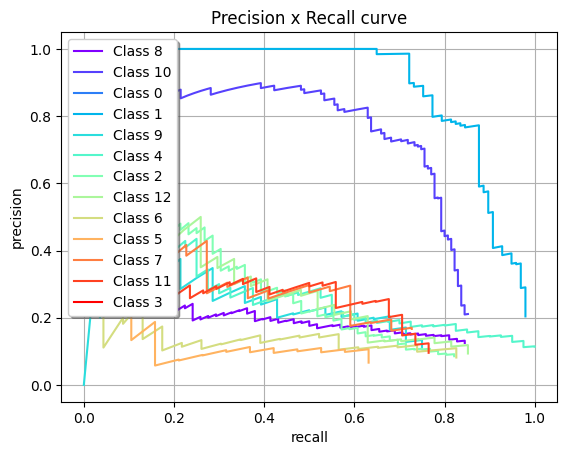

Confusion Matrix:
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
11.0 43.0 6.0 0.0 5.0 4.0 4.0 4.0 10.0 7.0 17.0 6.0 6.0 126.0
13.0 4.0 15.0 1.0 12.0 3.0 2.0 1.0 9.0 3.0 4.0 8.0 7.0 48.0
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
1.0 1.0 0.0 1.0 1.0 1.0 2.0 1.0 0.0 0.0 2.0 0.0 0.0 3.0
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
26.0 17.0 6.0 0.0 8.0 4.0 6.0 10.0 13.0 2.0 51.0 9.0 4.0 108.0
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
47.0 32.0 29.0 1.0 14.0 7.0 9.0 6.0 26.0 16.0 61.0 10.0 10.0 0.0


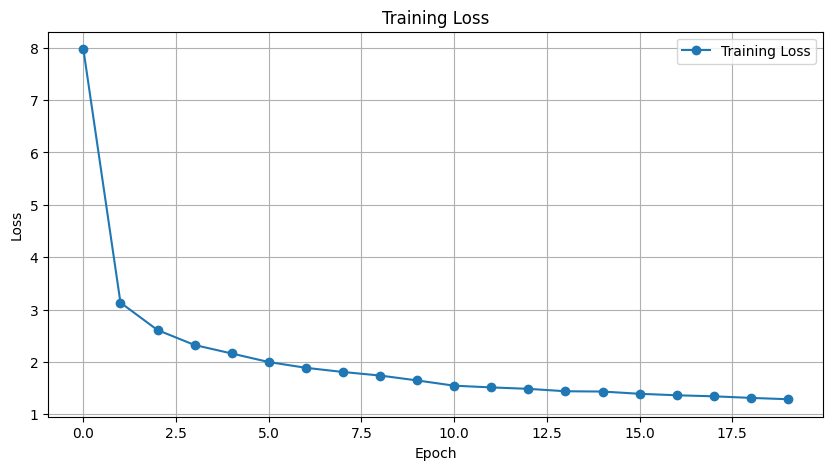

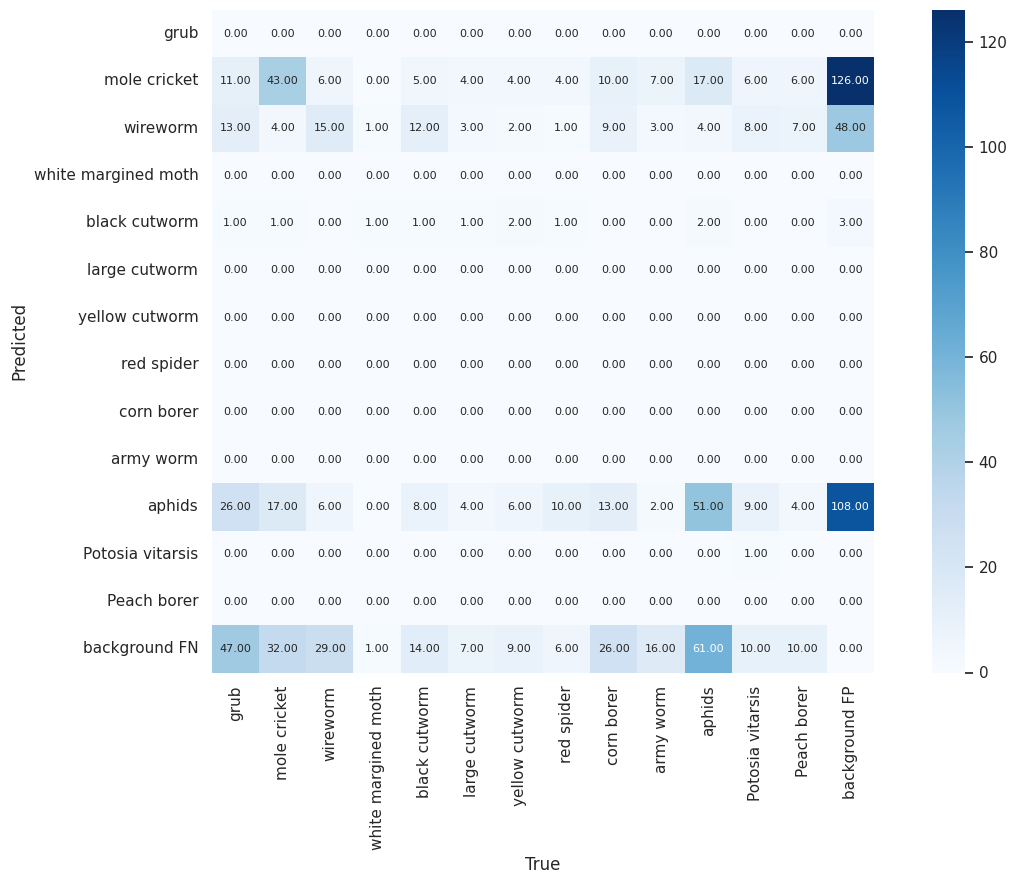

In [ ]:
# Defining parameters for model training
root = 'VOC2007'
annotations_file = 'dataset-trainval.txt'
num_classes = 13
backbone_name = 'densenet121'  # 'resnet50' or 'densenet121'
batch_size = 8
num_epochs = 20
tarin_split = 0.85
im_size = (416, 416)

main(root, annotations_file, num_classes, backbone_name, batch_size, num_epochs, tarin_split, im_size)

### Visualizing outputs of the model's training

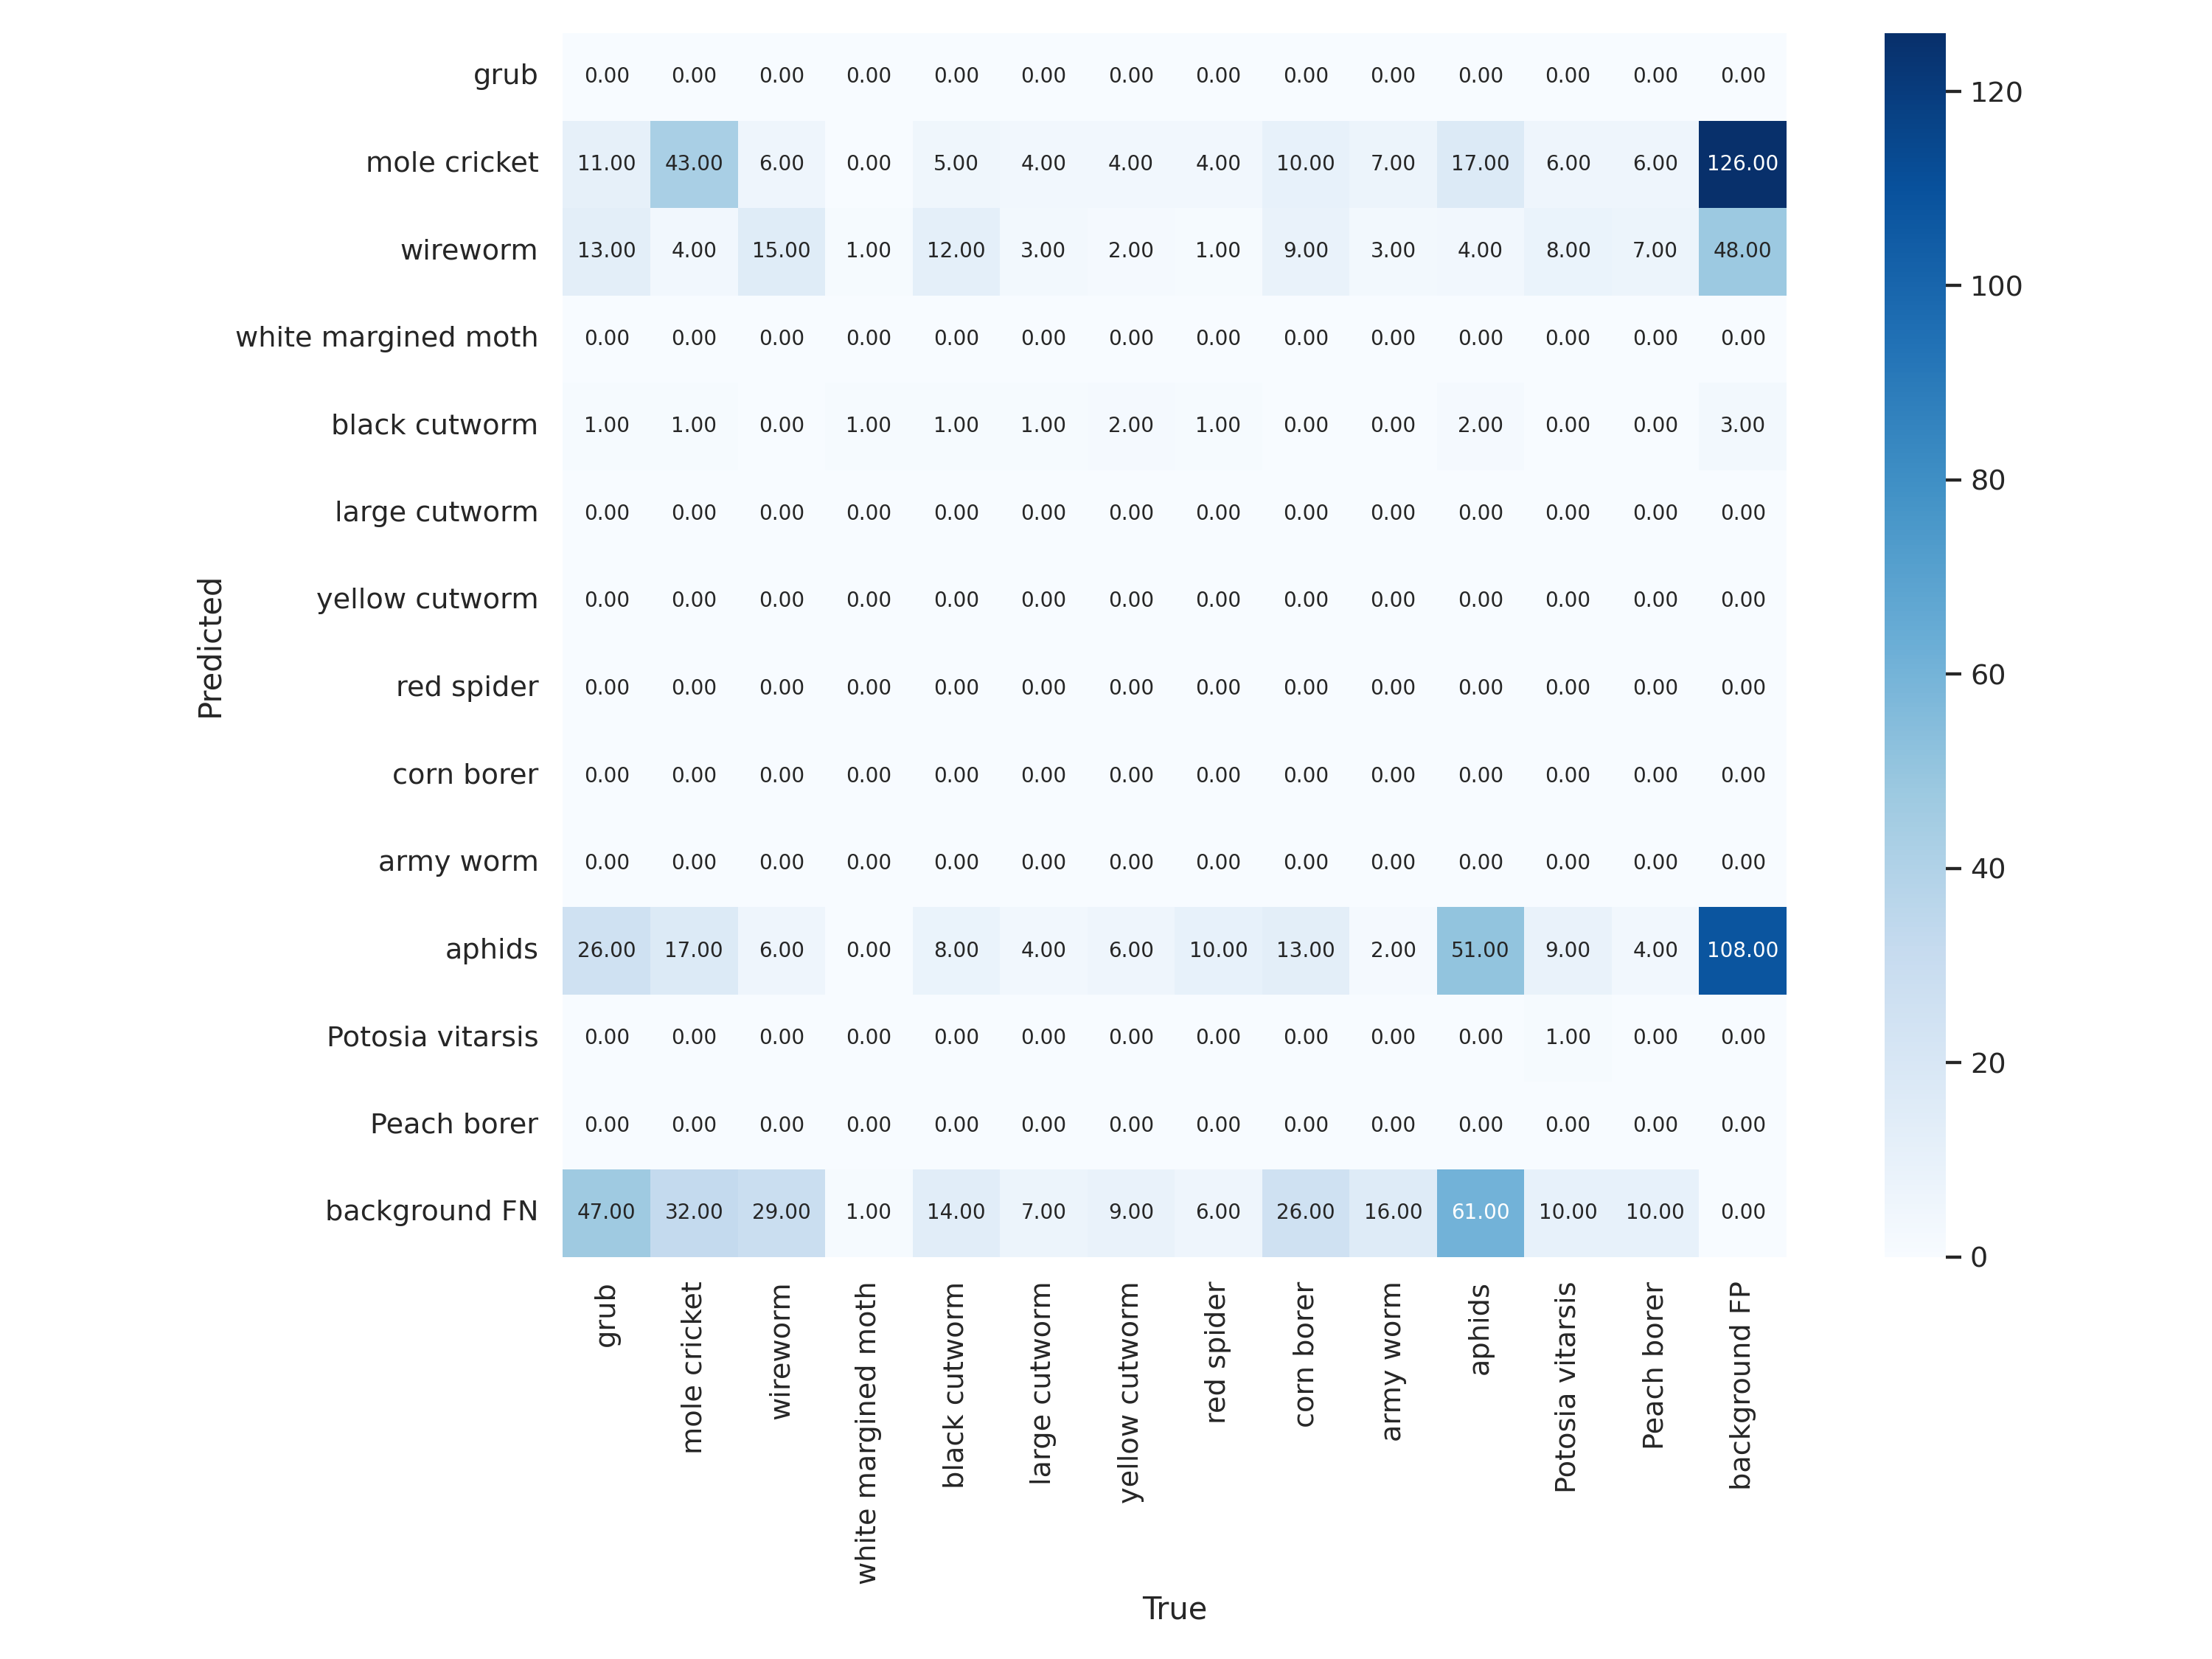

In [ ]:
from IPython.display import display, Image as Img
Img(filename='/content/matrices/densenet121_confusion_matrix.png', height=400)

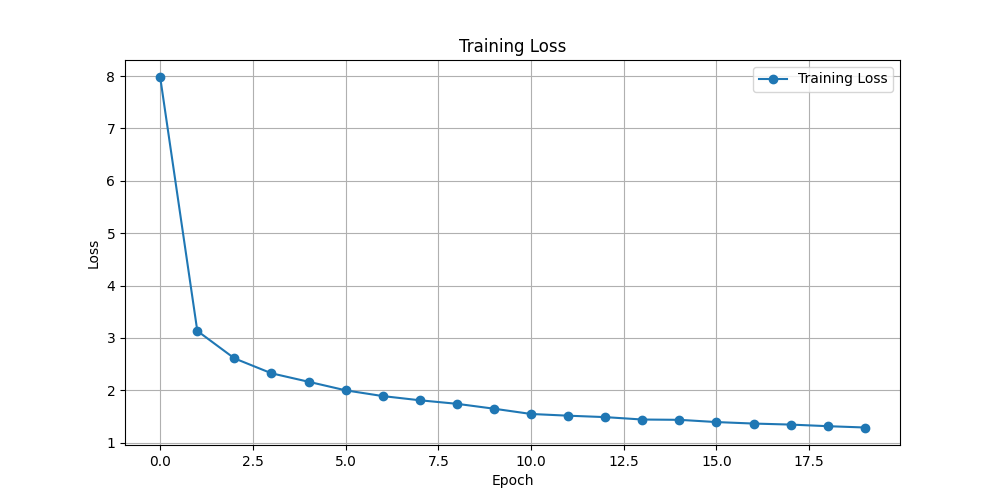

In [ ]:
Img(filename='matrices/densenet121_training_loss.png', height=400)

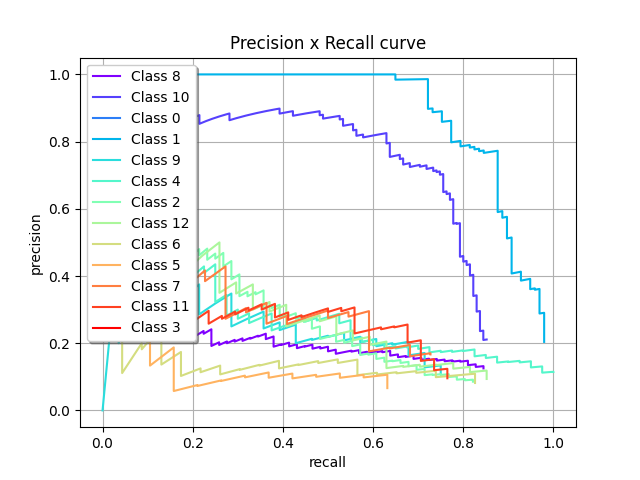

In [ ]:
Img(filename='matrices/densenet121_PR_curve.png', height=400)

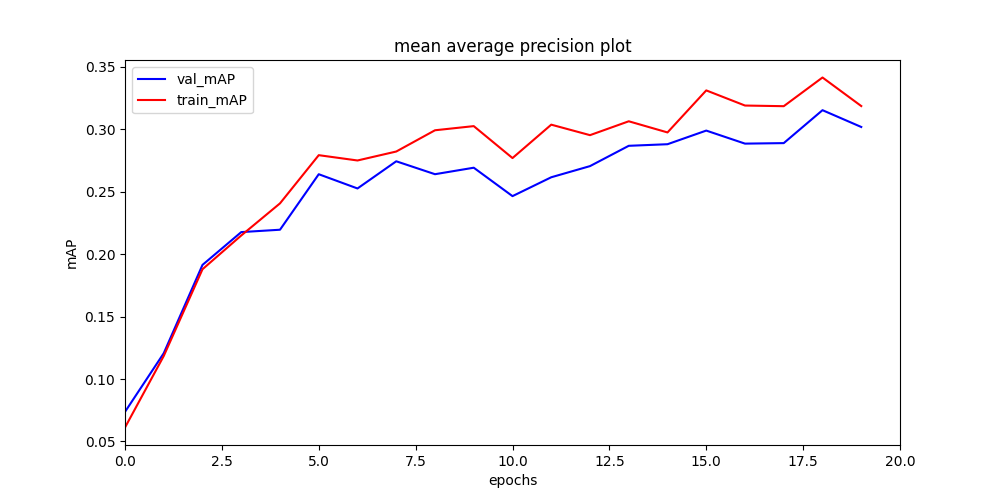

In [ ]:
Img(filename='matrices/densenet121_mAP.png', height=400)

## Evaluation on test data

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Validation data counts: {1: 176, 12: 50, 2: 109, 0: 118, 4: 67, 10: 282, 8: 90, 3: 13, 7: 37, 11: 47, 9: 41, 5: 40, 6: 43}
Overall Evaluation
{
    "m_ap": 0.3094656900222662,
    "precision": 0.12805970149253731,
    "recall": 0.77088948787062,
    "f1": 0.21963394342762063,
    "FP": 5842.0,
    "FN": 255.0,
    "TP": 858.0
}
Class-wise Evaluation
{'1': {'AP': '0.8947848406758249', 'total positives': '176', 'total fn': '5.0', 'total tp': '171.0', 'total fp': '465.0', 'method': 'MethodAveragePrecision.EVERY_POINT_INTERPOLATION', 'iou': '0.5'}, '12': {'AP': '0.3553829359219092', 'total positives': '50', 'total fn': '8.0', 'total tp': '42.0', 'total fp': '663.0', 'method': 'MethodAveragePrecision.EVERY_POINT_INTERPOLATION', 'iou': '0.5'}, '2': {'AP': '0.4542169180992211', 'total positives': '109', 'total fn': '11.0', 'total tp': '98.0', 'total fp': '939.0', 'method': 'MethodAveragePrecision.EVERY_POINT_INTERPOLATION', 'iou': '0.5'}, '0': {'AP': '0', 'total positives': '118', 'total fn':

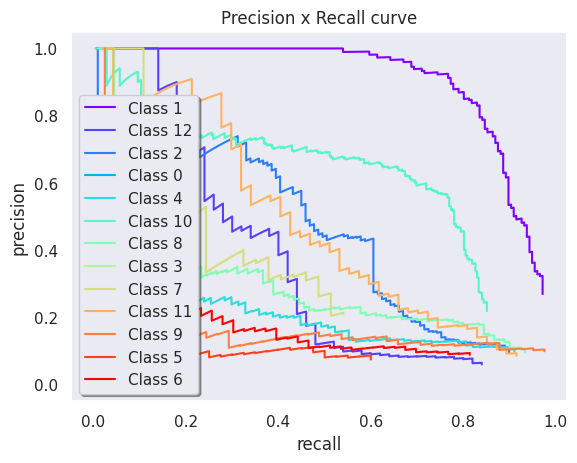

Confusion Matrix:
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
12.0 65.0 10.0 0.0 3.0 1.0 1.0 4.0 8.0 6.0 27.0 8.0 3.0 90.0
14.0 12.0 34.0 5.0 14.0 7.0 5.0 3.0 10.0 4.0 13.0 3.0 11.0 77.0
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
0.0 0.0 0.0 1.0 0.0 1.0 1.0 0.0 0.0 1.0 0.0 1.0 0.0 10.0
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
4.0 2.0 4.0 0.0 6.0 2.0 2.0 2.0 7.0 0.0 2.0 2.0 1.0 18.0
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
38.0 24.0 19.0 1.0 8.0 5.0 6.0 12.0 17.0 6.0 119.0 12.0 5.0 203.0
0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 2.0 0.0 1.0 3.0 0.0 0.0
0.0 1.0 1.0 1.0 0.0 0.0 0.0 0.0 2.0 1.0 0.0 0.0 3.0 8.0
50.0 72.0 41.0 4.0 36.0 24.0 28.0 16.0 44.0 23.0 120.0 18.0 27.0 0.0


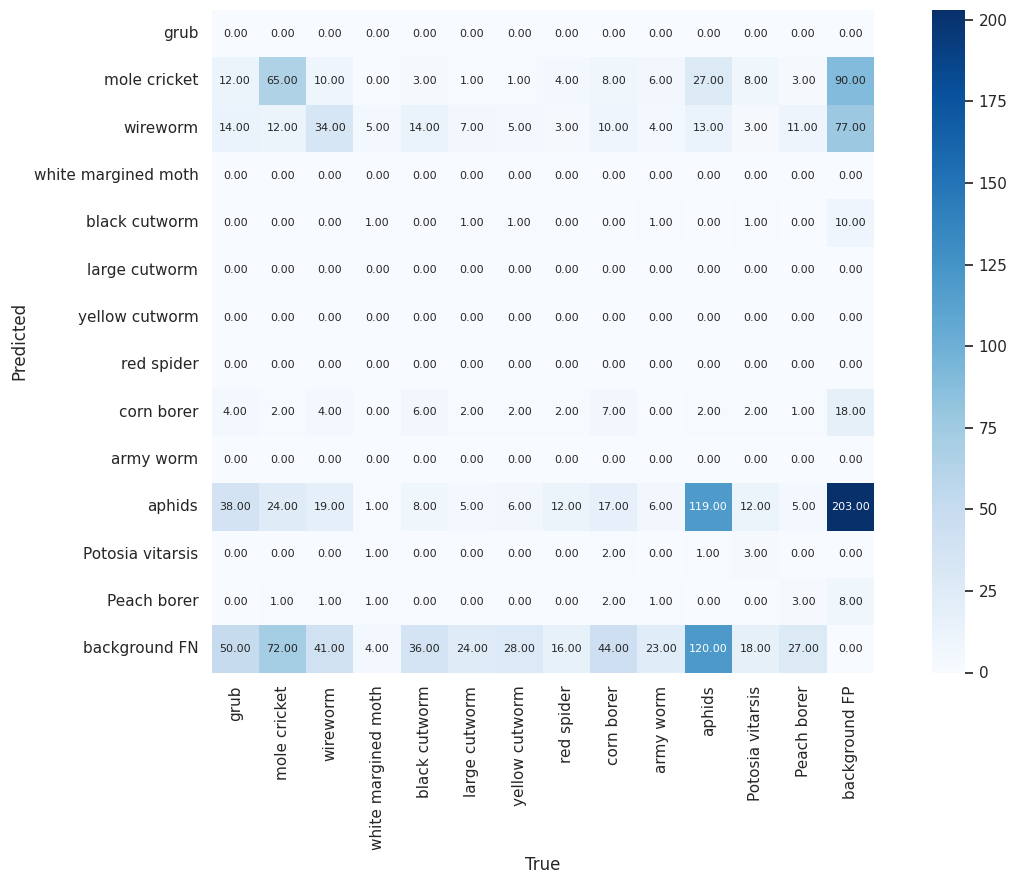

In [ ]:
# Set the root directory of the dataset, the annotations file, the batch size, and the model weights
root = 'VOC2007'
annotations_file = 'dataset-test.txt'
batch_size = 8
weights = '/content/checkpoints/densenet121_epoch-18_map-0.31534362952171574.pth'

# Create a VOCDataset object and a DataLoader object
dataset = VOCDataset(root, annotations_file, transforms=get_transform((416, 416)))
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

# Set the number of classes, the backbone network, and the device
num_classes = 13
backbone_name = 'densenet121'  # Choose 'resnet50' or 'densenet121'
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Create a FasterRCNNBuilder object and a Faster R-CNN model, and load the model weights
model_builder = FasterRCNNBuilder(num_classes, backbone_name)
model = model_builder.create_model()
state_dict = torch.load(weights, map_location=device)
model.load_state_dict(state_dict)
model.to(device)

# Evaluate the model on the test dataset
mAP, confMat, per_class_pec_rec = evaluate(model, loader, device, iou_threshold=0.5, valcount=True)
print(f'mAp: {mAP}')
plot_precision_recall_curve(per_class_pec_rec, save_path=f'matrices/{backbone_name}_val');

print('Confusion Matrix:')
confMat.print_matrix()
confMat.plot_metric(save_path=f'matrices/{backbone_name}_val_confusion_matrix.png');

### Visualizing testdata output

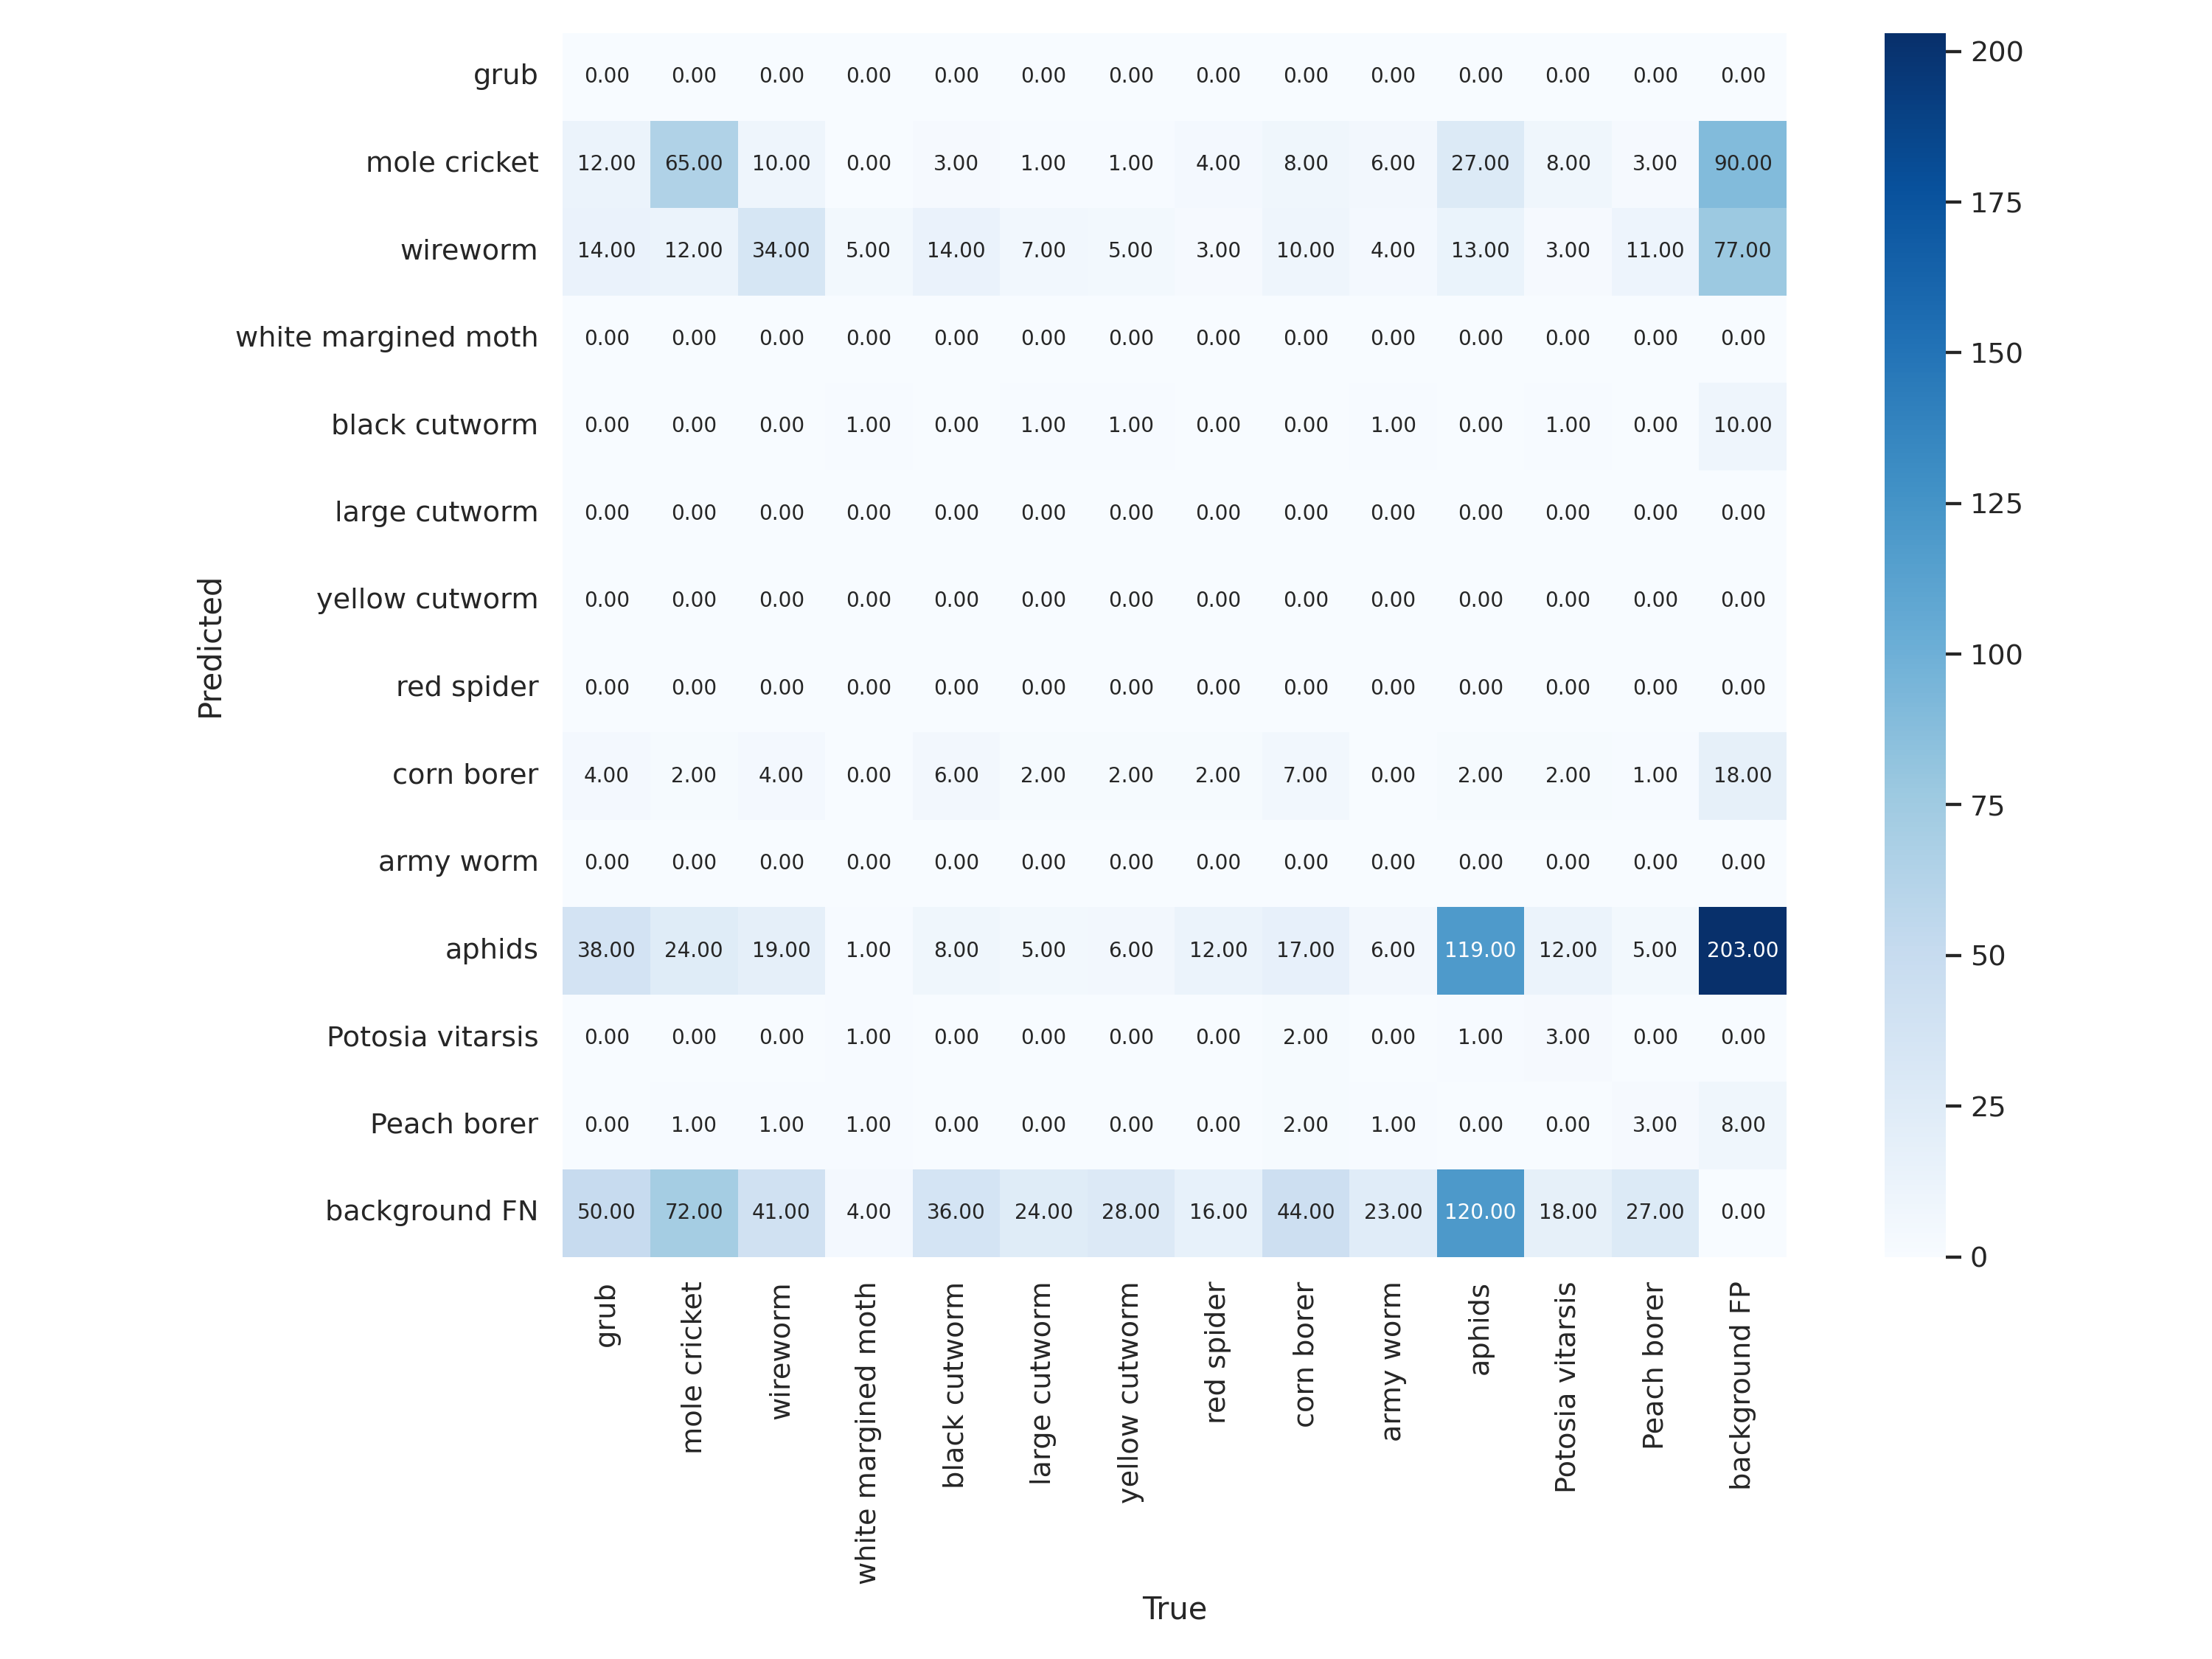

In [ ]:
Img(filename='matrices/densenet121_val_confusion_matrix.png', height=400)

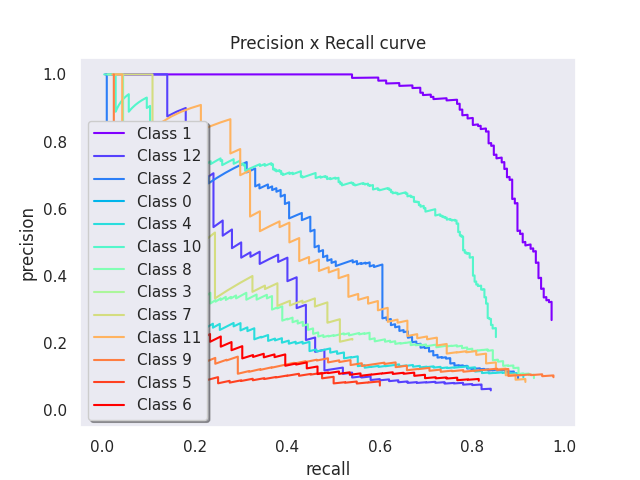

In [ ]:
Img(filename='matrices/densenet121_val_PR_curve.png', height=400)

## Inference on single image from test data

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


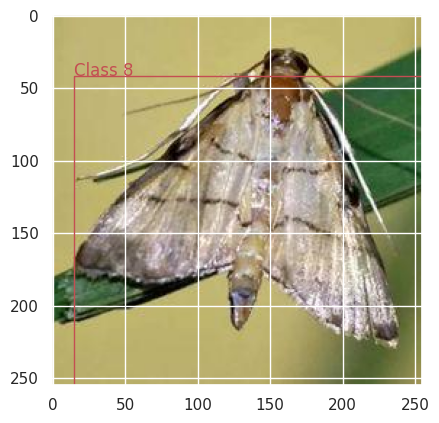

In [ ]:
# Inference using the specified weights and backbone model
weight_path = '/content/checkpoints/densenet121_epoch-18_map-0.31534362952171574.pth'
inference = Infernce(weights=weight_path, backbone_name='densenet121');
impath = '/content/VOC2007/JPEGImages/IP000000857.jpg'
inference.predict(im_path=impath)

# Faster RCNN training with RESNET Backbone

## Initiating Training of the model

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'backbone_name' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676

Epoch 1, Training Loss: 0.5537379484990409
train data counts: {1: 585, 4: 207, 12: 164, 0: 479, 10: 965, 11: 166, 2: 361, 5: 118, 6: 146, 8: 298, 9: 155, 7: 104, 3: 39}
Validation data counts: {1: 116, 2: 62, 4: 43, 6: 20, 0: 79, 5: 18, 12: 40, 8: 52, 9: 20, 10: 148, 11: 25, 7: 27, 3: 8}
Overall Evaluation
{
    "m_ap": 0.060218546291470595,
    "precision": 0.031194189784498155,
    "recall": 0.3981762917933131,
    "f1": 0.05785580214198962,
    "FP": 8137.0,
    "FN": 396.0,
    "TP": 262.0
}
Class-wise Evaluation
{'1': {'AP': '0.559025503210665', 'total positives': '116', 'total fn': '7.0', 'total tp': '109.0', 'total fp': '1824.0', 'method': 'MethodAveragePrecision.EVERY_POINT_INTERPOLATION', 'iou': '0.5'}, '2': {'AP': '0.006323979747601057', 'total positives': '62', 'total fn': '45.0', 'total tp': '17.0', 'total fp': '1266.0', 'method': 'MethodAveragePrecision.EVERY_POINT_INTERPOLATION', 'iou': '0.5'}, '4': {'AP': '0.021277276955150994', 'total positives': '43', 'total fn': '20.0

Epochs:   5%|▌         | 1/20 [08:26<2:40:14, 506.02s/epoch]

best mAp (val): 0.060218546291470595



Training Batch: 100%|██████████| 386/386 [04:26<00:00,  1.58batch/s]
                                                                    

Epoch 2, Training Loss: 0.1252725757851502
Overall Evaluation
{
    "m_ap": 0.11742720458697015,
    "precision": 0.02706359945872801,
    "recall": 0.6382978723404256,
    "f1": 0.05192557334487235,
    "FP": 15099.0,
    "FN": 238.0,
    "TP": 420.0
}
Class-wise Evaluation
{'1': {'AP': '0.6973003116151624', 'total positives': '116', 'total fn': '2.0', 'total tp': '114.0', 'total fp': '1652.0', 'method': 'MethodAveragePrecision.EVERY_POINT_INTERPOLATION', 'iou': '0.5'}, '2': {'AP': '0.017867349795511432', 'total positives': '62', 'total fn': '31.0', 'total tp': '31.0', 'total fp': '1640.0', 'method': 'MethodAveragePrecision.EVERY_POINT_INTERPOLATION', 'iou': '0.5'}, '4': {'AP': '0.0725328099294153', 'total positives': '43', 'total fn': '6.0', 'total tp': '37.0', 'total fp': '2201.0', 'method': 'MethodAveragePrecision.EVERY_POINT_INTERPOLATION', 'iou': '0.5'}, '6': {'AP': '0.019170815396464005', 'total positives': '20', 'total fn': '5.0', 'total tp': '15.0', 'total fp': '1779.0', 'meth

Epochs:  10%|█         | 2/20 [16:39<2:29:30, 498.37s/epoch]

best mAp (val): 0.11742720458697015



Training Batch: 100%|██████████| 386/386 [04:25<00:00,  1.59batch/s]
                                                                    

Epoch 3, Training Loss: 0.1190651540350111
Overall Evaluation
{
    "m_ap": 0.18043801741273313,
    "precision": 0.05305485535950066,
    "recall": 0.6717325227963525,
    "f1": 0.09834241851151408,
    "FP": 7889.0,
    "FN": 216.0,
    "TP": 442.0
}
Class-wise Evaluation
{'1': {'AP': '0.8494351659475742', 'total positives': '116', 'total fn': '3.0', 'total tp': '113.0', 'total fp': '788.0', 'method': 'MethodAveragePrecision.EVERY_POINT_INTERPOLATION', 'iou': '0.5'}, '2': {'AP': '0.06679493903853123', 'total positives': '62', 'total fn': '21.0', 'total tp': '41.0', 'total fp': '1420.0', 'method': 'MethodAveragePrecision.EVERY_POINT_INTERPOLATION', 'iou': '0.5'}, '4': {'AP': '0.20233211332916975', 'total positives': '43', 'total fn': '6.0', 'total tp': '37.0', 'total fp': '940.0', 'method': 'MethodAveragePrecision.EVERY_POINT_INTERPOLATION', 'iou': '0.5'}, '6': {'AP': '0.04283732328007649', 'total positives': '20', 'total fn': '3.0', 'total tp': '17.0', 'total fp': '629.0', 'method': 

Epochs:  15%|█▌        | 3/20 [24:41<2:19:05, 490.93s/epoch]

best mAp (val): 0.18043801741273313



Training Batch: 100%|██████████| 386/386 [04:26<00:00,  1.57batch/s]
                                                                    

Epoch 4, Training Loss: 0.11375167830774821
Overall Evaluation
{
    "m_ap": 0.23486599163065097,
    "precision": 0.05875720370834377,
    "recall": 0.7127659574468085,
    "f1": 0.10856481481481481,
    "FP": 7513.0,
    "FN": 189.0,
    "TP": 469.0
}
Class-wise Evaluation
{'1': {'AP': '0.8715387433880608', 'total positives': '116', 'total fn': '1.0', 'total tp': '115.0', 'total fp': '430.0', 'method': 'MethodAveragePrecision.EVERY_POINT_INTERPOLATION', 'iou': '0.5'}, '2': {'AP': '0.10914408279828278', 'total positives': '62', 'total fn': '15.0', 'total tp': '47.0', 'total fp': '1007.0', 'method': 'MethodAveragePrecision.EVERY_POINT_INTERPOLATION', 'iou': '0.5'}, '4': {'AP': '0.3530133883356955', 'total positives': '43', 'total fn': '4.0', 'total tp': '39.0', 'total fp': '836.0', 'method': 'MethodAveragePrecision.EVERY_POINT_INTERPOLATION', 'iou': '0.5'}, '6': {'AP': '0.056544991427738285', 'total positives': '20', 'total fn': '3.0', 'total tp': '17.0', 'total fp': '609.0', 'method':

Epochs:  20%|██        | 4/20 [32:42<2:09:55, 487.20s/epoch]

best mAp (val): 0.23486599163065097



Training Batch: 100%|██████████| 386/386 [04:28<00:00,  1.55batch/s]
                                                                    

Epoch 5, Training Loss: 0.10725733187107533
Overall Evaluation
{
    "m_ap": 0.32458181090859745,
    "precision": 0.081363117560737,
    "recall": 0.7583586626139818,
    "f1": 0.14695921072007068,
    "FP": 5634.0,
    "FN": 159.0,
    "TP": 499.0
}
Class-wise Evaluation
{'1': {'AP': '0.9385214884561635', 'total positives': '116', 'total fn': '1.0', 'total tp': '115.0', 'total fp': '941.0', 'method': 'MethodAveragePrecision.EVERY_POINT_INTERPOLATION', 'iou': '0.5'}, '2': {'AP': '0.21371496387963987', 'total positives': '62', 'total fn': '13.0', 'total tp': '49.0', 'total fp': '625.0', 'method': 'MethodAveragePrecision.EVERY_POINT_INTERPOLATION', 'iou': '0.5'}, '4': {'AP': '0.3588034230865355', 'total positives': '43', 'total fn': '4.0', 'total tp': '39.0', 'total fp': '365.0', 'method': 'MethodAveragePrecision.EVERY_POINT_INTERPOLATION', 'iou': '0.5'}, '6': {'AP': '0.05736990154711673', 'total positives': '20', 'total fn': '6.0', 'total tp': '14.0', 'total fp': '198.0', 'method': 'Me

Epochs:  25%|██▌       | 5/20 [40:51<2:01:54, 487.64s/epoch]

best mAp (val): 0.32458181090859745



Training Batch: 100%|██████████| 386/386 [04:30<00:00,  1.56batch/s]
                                                                    

Epoch 6, Training Loss: 0.10279602966623602
Overall Evaluation
{
    "m_ap": 0.37869726435225826,
    "precision": 0.0836997231721218,
    "recall": 0.7811550151975684,
    "f1": 0.15119870569201352,
    "FP": 5627.0,
    "FN": 144.0,
    "TP": 514.0
}
Class-wise Evaluation
{'1': {'AP': '0.9537300130833761', 'total positives': '116', 'total fn': '0.0', 'total tp': '116.0', 'total fp': '388.0', 'method': 'MethodAveragePrecision.EVERY_POINT_INTERPOLATION', 'iou': '0.5'}, '2': {'AP': '0.18649902072492644', 'total positives': '62', 'total fn': '9.0', 'total tp': '53.0', 'total fp': '1008.0', 'method': 'MethodAveragePrecision.EVERY_POINT_INTERPOLATION', 'iou': '0.5'}, '4': {'AP': '0.4687899734324114', 'total positives': '43', 'total fn': '2.0', 'total tp': '41.0', 'total fp': '390.0', 'method': 'MethodAveragePrecision.EVERY_POINT_INTERPOLATION', 'iou': '0.5'}, '6': {'AP': '0.09904321824447769', 'total positives': '20', 'total fn': '1.0', 'total tp': '19.0', 'total fp': '339.0', 'method': 'M

Epochs:  30%|███       | 6/20 [48:58<1:53:48, 487.72s/epoch]

best mAp (val): 0.37869726435225826



Training Batch: 100%|██████████| 386/386 [04:31<00:00,  1.54batch/s]
                                                                    

Epoch 7, Training Loss: 0.09963313164913283
Overall Evaluation
{
    "m_ap": 0.441632670959702,
    "precision": 0.08192090395480225,
    "recall": 0.7933130699088146,
    "f1": 0.14850640113798008,
    "FP": 5850.0,
    "FN": 136.0,
    "TP": 522.0
}
Class-wise Evaluation
{'1': {'AP': '0.9628255301576628', 'total positives': '116', 'total fn': '1.0', 'total tp': '115.0', 'total fp': '388.0', 'method': 'MethodAveragePrecision.EVERY_POINT_INTERPOLATION', 'iou': '0.5'}, '2': {'AP': '0.3133259350465797', 'total positives': '62', 'total fn': '7.0', 'total tp': '55.0', 'total fp': '1118.0', 'method': 'MethodAveragePrecision.EVERY_POINT_INTERPOLATION', 'iou': '0.5'}, '4': {'AP': '0.5715116291923066', 'total positives': '43', 'total fn': '4.0', 'total tp': '39.0', 'total fp': '419.0', 'method': 'MethodAveragePrecision.EVERY_POINT_INTERPOLATION', 'iou': '0.5'}, '6': {'AP': '0.07874961584176116', 'total positives': '20', 'total fn': '4.0', 'total tp': '16.0', 'total fp': '276.0', 'method': 'Met

Epochs:  35%|███▌      | 7/20 [57:12<1:46:05, 489.65s/epoch]

best mAp (val): 0.441632670959702



Training Batch: 100%|██████████| 386/386 [04:31<00:00,  1.55batch/s]
                                                                    

Epoch 8, Training Loss: 0.09560761366213233
Overall Evaluation
{
    "m_ap": 0.43461259933696866,
    "precision": 0.10336490026193834,
    "recall": 0.7796352583586627,
    "f1": 0.18252979896815513,
    "FP": 4450.0,
    "FN": 145.0,
    "TP": 513.0
}
Class-wise Evaluation
{'1': {'AP': '0.9613622706071516', 'total positives': '116', 'total fn': '1.0', 'total tp': '115.0', 'total fp': '483.0', 'method': 'MethodAveragePrecision.EVERY_POINT_INTERPOLATION', 'iou': '0.5'}, '2': {'AP': '0.36019377646568457', 'total positives': '62', 'total fn': '12.0', 'total tp': '50.0', 'total fp': '372.0', 'method': 'MethodAveragePrecision.EVERY_POINT_INTERPOLATION', 'iou': '0.5'}, '4': {'AP': '0.5081131281300222', 'total positives': '43', 'total fn': '4.0', 'total tp': '39.0', 'total fp': '274.0', 'method': 'MethodAveragePrecision.EVERY_POINT_INTERPOLATION', 'iou': '0.5'}, '6': {'AP': '0.0983139409609998', 'total positives': '20', 'total fn': '4.0', 'total tp': '16.0', 'total fp': '238.0', 'method': 'M

Epochs:  40%|████      | 8/20 [1:05:19<1:37:45, 488.82s/epoch]

train mAp: 0.4624291982339972
validation mAp: 0.43461259933696866
best mAp (val): 0.441632670959702



Training Batch: 100%|██████████| 386/386 [04:30<00:00,  1.55batch/s]
                                                                    

Epoch 9, Training Loss: 0.0938137043653529
Overall Evaluation
{
    "m_ap": 0.45412903074473887,
    "precision": 0.09158679446219382,
    "recall": 0.78419452887538,
    "f1": 0.16401780038143676,
    "FP": 5118.0,
    "FN": 142.0,
    "TP": 516.0
}
Class-wise Evaluation
{'1': {'AP': '0.9666166146575259', 'total positives': '116', 'total fn': '0.0', 'total tp': '116.0', 'total fp': '715.0', 'method': 'MethodAveragePrecision.EVERY_POINT_INTERPOLATION', 'iou': '0.5'}, '2': {'AP': '0.3088856277882271', 'total positives': '62', 'total fn': '4.0', 'total tp': '58.0', 'total fp': '904.0', 'method': 'MethodAveragePrecision.EVERY_POINT_INTERPOLATION', 'iou': '0.5'}, '4': {'AP': '0.44415602030518', 'total positives': '43', 'total fn': '2.0', 'total tp': '41.0', 'total fp': '654.0', 'method': 'MethodAveragePrecision.EVERY_POINT_INTERPOLATION', 'iou': '0.5'}, '6': {'AP': '0.09563176449372306', 'total positives': '20', 'total fn': '5.0', 'total tp': '15.0', 'total fp': '194.0', 'method': 'MethodA

Epochs:  45%|████▌     | 9/20 [1:13:27<1:29:34, 488.63s/epoch]

best mAp (val): 0.45412903074473887



Training Batch: 100%|██████████| 386/386 [04:30<00:00,  1.57batch/s]
                                                                    

Epoch 10, Training Loss: 0.09151789852915032
Overall Evaluation
{
    "m_ap": 0.46257445738202185,
    "precision": 0.11168384879725086,
    "recall": 0.790273556231003,
    "f1": 0.19570944674444862,
    "FP": 4136.0,
    "FN": 138.0,
    "TP": 520.0
}
Class-wise Evaluation
{'1': {'AP': '0.9786688861504392', 'total positives': '116', 'total fn': '0.0', 'total tp': '116.0', 'total fp': '249.0', 'method': 'MethodAveragePrecision.EVERY_POINT_INTERPOLATION', 'iou': '0.5'}, '2': {'AP': '0.34486231341955903', 'total positives': '62', 'total fn': '13.0', 'total tp': '49.0', 'total fp': '338.0', 'method': 'MethodAveragePrecision.EVERY_POINT_INTERPOLATION', 'iou': '0.5'}, '4': {'AP': '0.4355035413872847', 'total positives': '43', 'total fn': '1.0', 'total tp': '42.0', 'total fp': '345.0', 'method': 'MethodAveragePrecision.EVERY_POINT_INTERPOLATION', 'iou': '0.5'}, '6': {'AP': '0.11657404550415147', 'total positives': '20', 'total fn': '3.0', 'total tp': '17.0', 'total fp': '405.0', 'method': '

Epochs:  50%|█████     | 10/20 [1:21:33<1:21:18, 487.85s/epoch]

best mAp (val): 0.46257445738202185



Training Batch: 100%|██████████| 386/386 [04:31<00:00,  1.46batch/s]
                                                                    

Epoch 11, Training Loss: 0.09205349584935242
Overall Evaluation
{
    "m_ap": 0.5003191871700929,
    "precision": 0.09627329192546584,
    "recall": 0.8009118541033434,
    "f1": 0.17188519243313763,
    "FP": 4947.0,
    "FN": 131.0,
    "TP": 527.0
}
Class-wise Evaluation
{'1': {'AP': '0.9814682380272556', 'total positives': '116', 'total fn': '0.0', 'total tp': '116.0', 'total fp': '381.0', 'method': 'MethodAveragePrecision.EVERY_POINT_INTERPOLATION', 'iou': '0.5'}, '2': {'AP': '0.40856732256933176', 'total positives': '62', 'total fn': '8.0', 'total tp': '54.0', 'total fp': '505.0', 'method': 'MethodAveragePrecision.EVERY_POINT_INTERPOLATION', 'iou': '0.5'}, '4': {'AP': '0.4967913154189241', 'total positives': '43', 'total fn': '3.0', 'total tp': '40.0', 'total fp': '453.0', 'method': 'MethodAveragePrecision.EVERY_POINT_INTERPOLATION', 'iou': '0.5'}, '6': {'AP': '0.09700942965042271', 'total positives': '20', 'total fn': '5.0', 'total tp': '15.0', 'total fp': '234.0', 'method': 'M

Epochs:  55%|█████▌    | 11/20 [1:29:44<1:13:16, 488.55s/epoch]

best mAp (val): 0.5003191871700929



Training Batch: 100%|██████████| 386/386 [04:30<00:00,  1.56batch/s]
                                                                    

Epoch 12, Training Loss: 0.09043576262428044
Overall Evaluation
{
    "m_ap": 0.5152992637175188,
    "precision": 0.08943225590353375,
    "recall": 0.8115501519756839,
    "f1": 0.1611102730426912,
    "FP": 5437.0,
    "FN": 124.0,
    "TP": 534.0
}
Class-wise Evaluation
{'1': {'AP': '0.9812676088235364', 'total positives': '116', 'total fn': '0.0', 'total tp': '116.0', 'total fp': '306.0', 'method': 'MethodAveragePrecision.EVERY_POINT_INTERPOLATION', 'iou': '0.5'}, '2': {'AP': '0.4758185813762067', 'total positives': '62', 'total fn': '6.0', 'total tp': '56.0', 'total fp': '906.0', 'method': 'MethodAveragePrecision.EVERY_POINT_INTERPOLATION', 'iou': '0.5'}, '4': {'AP': '0.5441139487306415', 'total positives': '43', 'total fn': '1.0', 'total tp': '42.0', 'total fp': '701.0', 'method': 'MethodAveragePrecision.EVERY_POINT_INTERPOLATION', 'iou': '0.5'}, '6': {'AP': '0.08676777110760614', 'total positives': '20', 'total fn': '2.0', 'total tp': '18.0', 'total fp': '507.0', 'method': 'Met

Epochs:  60%|██████    | 12/20 [1:37:54<1:05:12, 489.09s/epoch]

best mAp (val): 0.5152992637175188



Training Batch: 100%|██████████| 386/386 [04:31<00:00,  1.56batch/s]
                                                                    

Epoch 13, Training Loss: 0.09025376015994216
Overall Evaluation
{
    "m_ap": 0.4914794288967607,
    "precision": 0.10062535531552018,
    "recall": 0.8069908814589666,
    "f1": 0.17893850042123,
    "FP": 4746.0,
    "FN": 127.0,
    "TP": 531.0
}
Class-wise Evaluation
{'1': {'AP': '0.9506832348663067', 'total positives': '116', 'total fn': '2.0', 'total tp': '114.0', 'total fp': '150.0', 'method': 'MethodAveragePrecision.EVERY_POINT_INTERPOLATION', 'iou': '0.5'}, '2': {'AP': '0.4124366942471525', 'total positives': '62', 'total fn': '11.0', 'total tp': '51.0', 'total fp': '465.0', 'method': 'MethodAveragePrecision.EVERY_POINT_INTERPOLATION', 'iou': '0.5'}, '4': {'AP': '0.5565289406722149', 'total positives': '43', 'total fn': '1.0', 'total tp': '42.0', 'total fp': '460.0', 'method': 'MethodAveragePrecision.EVERY_POINT_INTERPOLATION', 'iou': '0.5'}, '6': {'AP': '0.11668256492225879', 'total positives': '20', 'total fn': '2.0', 'total tp': '18.0', 'total fp': '409.0', 'method': 'Meth

Epochs:  65%|██████▌   | 13/20 [1:46:01<57:00, 488.58s/epoch]  

train mAp: 0.5625491696706065
validation mAp: 0.4914794288967607
best mAp (val): 0.5152992637175188



Training Batch: 100%|██████████| 386/386 [04:30<00:00,  1.54batch/s]
                                                                    

Epoch 14, Training Loss: 0.08910459482685272
Overall Evaluation
{
    "m_ap": 0.4933947203121786,
    "precision": 0.09774295840328297,
    "recall": 0.7963525835866262,
    "f1": 0.17411530154510715,
    "FP": 4837.0,
    "FN": 134.0,
    "TP": 524.0
}
Class-wise Evaluation
{'1': {'AP': '0.978632917028166', 'total positives': '116', 'total fn': '0.0', 'total tp': '116.0', 'total fp': '400.0', 'method': 'MethodAveragePrecision.EVERY_POINT_INTERPOLATION', 'iou': '0.5'}, '2': {'AP': '0.44297344029871133', 'total positives': '62', 'total fn': '8.0', 'total tp': '54.0', 'total fp': '550.0', 'method': 'MethodAveragePrecision.EVERY_POINT_INTERPOLATION', 'iou': '0.5'}, '4': {'AP': '0.5590052192745785', 'total positives': '43', 'total fn': '2.0', 'total tp': '41.0', 'total fp': '453.0', 'method': 'MethodAveragePrecision.EVERY_POINT_INTERPOLATION', 'iou': '0.5'}, '6': {'AP': '0.1285631040149729', 'total positives': '20', 'total fn': '3.0', 'total tp': '17.0', 'total fp': '383.0', 'method': 'Met

Epochs:  70%|███████   | 14/20 [1:54:10<48:51, 488.63s/epoch]

train mAp: 0.5565662177338919
validation mAp: 0.4933947203121786
best mAp (val): 0.5152992637175188



Training Batch: 100%|██████████| 386/386 [04:30<00:00,  1.55batch/s]
                                                                    

Epoch 15, Training Loss: 0.08511126043342555
Overall Evaluation
{
    "m_ap": 0.5145271337133314,
    "precision": 0.14799213704015726,
    "recall": 0.8009118541033434,
    "f1": 0.24982223275657742,
    "FP": 3034.0,
    "FN": 131.0,
    "TP": 527.0
}
Class-wise Evaluation
{'1': {'AP': '0.9857099566015906', 'total positives': '116', 'total fn': '0.0', 'total tp': '116.0', 'total fp': '193.0', 'method': 'MethodAveragePrecision.EVERY_POINT_INTERPOLATION', 'iou': '0.5'}, '2': {'AP': '0.46178621290756533', 'total positives': '62', 'total fn': '5.0', 'total tp': '57.0', 'total fp': '371.0', 'method': 'MethodAveragePrecision.EVERY_POINT_INTERPOLATION', 'iou': '0.5'}, '4': {'AP': '0.5433369951714515', 'total positives': '43', 'total fn': '1.0', 'total tp': '42.0', 'total fp': '397.0', 'method': 'MethodAveragePrecision.EVERY_POINT_INTERPOLATION', 'iou': '0.5'}, '6': {'AP': '0.14642057607868994', 'total positives': '20', 'total fn': '2.0', 'total tp': '18.0', 'total fp': '292.0', 'method': 'M

Epochs:  75%|███████▌  | 15/20 [2:02:11<40:31, 486.25s/epoch]

train mAp: 0.5876887941664324
validation mAp: 0.5145271337133314
best mAp (val): 0.5152992637175188



Training Batch: 100%|██████████| 386/386 [04:30<00:00,  1.55batch/s]
                                                                    

Epoch 16, Training Loss: 0.08555905910816836
Overall Evaluation
{
    "m_ap": 0.5043865850337643,
    "precision": 0.0910941475826972,
    "recall": 0.8161094224924013,
    "f1": 0.16389439951167406,
    "FP": 5358.0,
    "FN": 121.0,
    "TP": 537.0
}
Class-wise Evaluation
{'1': {'AP': '0.983933556769896', 'total positives': '116', 'total fn': '0.0', 'total tp': '116.0', 'total fp': '398.0', 'method': 'MethodAveragePrecision.EVERY_POINT_INTERPOLATION', 'iou': '0.5'}, '2': {'AP': '0.4123226965890189', 'total positives': '62', 'total fn': '9.0', 'total tp': '53.0', 'total fp': '431.0', 'method': 'MethodAveragePrecision.EVERY_POINT_INTERPOLATION', 'iou': '0.5'}, '4': {'AP': '0.5167814535321511', 'total positives': '43', 'total fn': '1.0', 'total tp': '42.0', 'total fp': '518.0', 'method': 'MethodAveragePrecision.EVERY_POINT_INTERPOLATION', 'iou': '0.5'}, '6': {'AP': '0.08858345193317162', 'total positives': '20', 'total fn': '2.0', 'total tp': '18.0', 'total fp': '388.0', 'method': 'Meth

Epochs:  80%|████████  | 16/20 [2:10:19<32:26, 486.74s/epoch]

train mAp: 0.554836852673909
validation mAp: 0.5043865850337643
best mAp (val): 0.5152992637175188



Training Batch: 100%|██████████| 386/386 [04:29<00:00,  1.56batch/s]
                                                                    

Epoch 17, Training Loss: 0.08680178751985644
Overall Evaluation
{
    "m_ap": 0.5224383420426021,
    "precision": 0.13034776082061547,
    "recall": 0.7917933130699089,
    "f1": 0.22384532760472609,
    "FP": 3476.0,
    "FN": 137.0,
    "TP": 521.0
}
Class-wise Evaluation
{'1': {'AP': '0.986018045672673', 'total positives': '116', 'total fn': '0.0', 'total tp': '116.0', 'total fp': '362.0', 'method': 'MethodAveragePrecision.EVERY_POINT_INTERPOLATION', 'iou': '0.5'}, '2': {'AP': '0.5144388909252586', 'total positives': '62', 'total fn': '9.0', 'total tp': '53.0', 'total fp': '467.0', 'method': 'MethodAveragePrecision.EVERY_POINT_INTERPOLATION', 'iou': '0.5'}, '4': {'AP': '0.5462960892015276', 'total positives': '43', 'total fn': '3.0', 'total tp': '40.0', 'total fp': '350.0', 'method': 'MethodAveragePrecision.EVERY_POINT_INTERPOLATION', 'iou': '0.5'}, '6': {'AP': '0.11360374127683719', 'total positives': '20', 'total fn': '3.0', 'total tp': '17.0', 'total fp': '342.0', 'method': 'Met

Epochs:  85%|████████▌ | 17/20 [2:18:22<24:17, 485.82s/epoch]

best mAp (val): 0.5224383420426021



Training Batch: 100%|██████████| 386/386 [04:30<00:00,  1.56batch/s]
                                                                    

Epoch 18, Training Loss: 0.08444296344728668
Overall Evaluation
{
    "m_ap": 0.48634745174268545,
    "precision": 0.12748710390567428,
    "recall": 0.7887537993920972,
    "f1": 0.2194967223514485,
    "FP": 3552.0,
    "FN": 139.0,
    "TP": 519.0
}
Class-wise Evaluation
{'1': {'AP': '0.9863555369096672', 'total positives': '116', 'total fn': '0.0', 'total tp': '116.0', 'total fp': '227.0', 'method': 'MethodAveragePrecision.EVERY_POINT_INTERPOLATION', 'iou': '0.5'}, '2': {'AP': '0.45093742051829094', 'total positives': '62', 'total fn': '10.0', 'total tp': '52.0', 'total fp': '324.0', 'method': 'MethodAveragePrecision.EVERY_POINT_INTERPOLATION', 'iou': '0.5'}, '4': {'AP': '0.45462430065428205', 'total positives': '43', 'total fn': '4.0', 'total tp': '39.0', 'total fp': '243.0', 'method': 'MethodAveragePrecision.EVERY_POINT_INTERPOLATION', 'iou': '0.5'}, '6': {'AP': '0.10801815737592205', 'total positives': '20', 'total fn': '2.0', 'total tp': '18.0', 'total fp': '264.0', 'method': 

Epochs:  90%|█████████ | 18/20 [2:26:27<16:10, 485.38s/epoch]

train mAp: 0.5574842779734673
validation mAp: 0.48634745174268545
best mAp (val): 0.5224383420426021



Training Batch: 100%|██████████| 386/386 [04:30<00:00,  1.55batch/s]
                                                                    

Epoch 19, Training Loss: 0.08567919191262574
Overall Evaluation
{
    "m_ap": 0.4962748735394523,
    "precision": 0.11500449236298294,
    "recall": 0.7781155015197568,
    "f1": 0.20039138943248533,
    "FP": 3940.0,
    "FN": 146.0,
    "TP": 512.0
}
Class-wise Evaluation
{'1': {'AP': '0.9611677108808568', 'total positives': '116', 'total fn': '0.0', 'total tp': '116.0', 'total fp': '534.0', 'method': 'MethodAveragePrecision.EVERY_POINT_INTERPOLATION', 'iou': '0.5'}, '2': {'AP': '0.5116841923115333', 'total positives': '62', 'total fn': '11.0', 'total tp': '51.0', 'total fp': '353.0', 'method': 'MethodAveragePrecision.EVERY_POINT_INTERPOLATION', 'iou': '0.5'}, '4': {'AP': '0.5273114529924986', 'total positives': '43', 'total fn': '5.0', 'total tp': '38.0', 'total fp': '219.0', 'method': 'MethodAveragePrecision.EVERY_POINT_INTERPOLATION', 'iou': '0.5'}, '6': {'AP': '0.11909166194425974', 'total positives': '20', 'total fn': '4.0', 'total tp': '16.0', 'total fp': '215.0', 'method': 'M

Epochs:  95%|█████████▌| 19/20 [2:34:33<08:05, 485.61s/epoch]

train mAp: 0.5532106929529691
validation mAp: 0.4962748735394523
best mAp (val): 0.5224383420426021



Training Batch: 100%|██████████| 386/386 [04:29<00:00,  1.56batch/s]
                                                                    

Epoch 20, Training Loss: 0.08456668430466417
Overall Evaluation
{
    "m_ap": 0.488101825653336,
    "precision": 0.08808025845944567,
    "recall": 0.7872340425531915,
    "f1": 0.1584340113167151,
    "FP": 5363.0,
    "FN": 140.0,
    "TP": 518.0
}
Class-wise Evaluation
{'1': {'AP': '0.9851117327451362', 'total positives': '116', 'total fn': '0.0', 'total tp': '116.0', 'total fp': '764.0', 'method': 'MethodAveragePrecision.EVERY_POINT_INTERPOLATION', 'iou': '0.5'}, '2': {'AP': '0.4843920865033156', 'total positives': '62', 'total fn': '6.0', 'total tp': '56.0', 'total fp': '866.0', 'method': 'MethodAveragePrecision.EVERY_POINT_INTERPOLATION', 'iou': '0.5'}, '4': {'AP': '0.46453890292031036', 'total positives': '43', 'total fn': '6.0', 'total tp': '37.0', 'total fp': '448.0', 'method': 'MethodAveragePrecision.EVERY_POINT_INTERPOLATION', 'iou': '0.5'}, '6': {'AP': '0.09140277381494091', 'total positives': '20', 'total fn': '3.0', 'total tp': '17.0', 'total fp': '402.0', 'method': 'Met

Epochs: 100%|██████████| 20/20 [2:42:41<00:00, 488.07s/epoch]

train mAp: 0.545236472419069
validation mAp: 0.488101825653336
best mAp (val): 0.5224383420426021


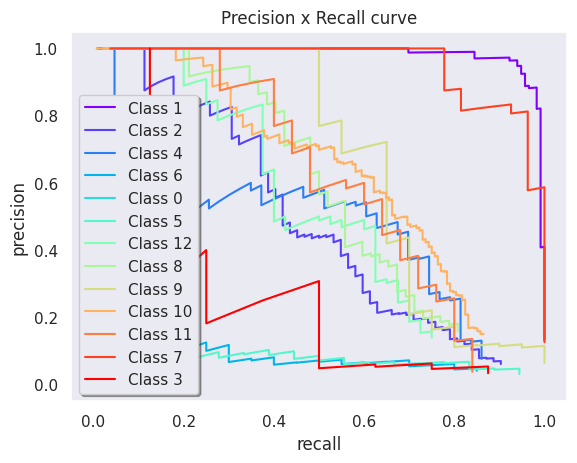

Confusion Matrix:
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
11.0 35.0 5.0 1.0 5.0 4.0 1.0 2.0 12.0 1.0 16.0 1.0 6.0 222.0
12.0 10.0 21.0 0.0 6.0 2.0 4.0 4.0 8.0 3.0 19.0 3.0 4.0 182.0
1.0 1.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 4.0
2.0 8.0 2.0 0.0 8.0 1.0 3.0 0.0 4.0 2.0 7.0 2.0 1.0 73.0
4.0 3.0 6.0 1.0 2.0 2.0 2.0 0.0 5.0 0.0 6.0 4.0 0.0 44.0
0.0 0.0 1.0 0.0 1.0 0.0 2.0 0.0 0.0 3.0 0.0 0.0 1.0 16.0
2.0 1.0 0.0 0.0 1.0 1.0 0.0 7.0 2.0 0.0 4.0 0.0 1.0 29.0
2.0 6.0 7.0 1.0 1.0 1.0 2.0 0.0 0.0 0.0 3.0 1.0 0.0 42.0
0.0 8.0 0.0 1.0 1.0 0.0 0.0 1.0 0.0 0.0 1.0 0.0 2.0 43.0
20.0 13.0 5.0 1.0 3.0 0.0 2.0 7.0 3.0 1.0 50.0 4.0 3.0 236.0
5.0 9.0 4.0 0.0 1.0 3.0 1.0 2.0 5.0 2.0 6.0 5.0 6.0 109.0
1.0 3.0 1.0 0.0 1.0 0.0 1.0 1.0 0.0 1.0 3.0 0.0 5.0 33.0
19.0 19.0 10.0 3.0 12.0 4.0 2.0 3.0 13.0 7.0 33.0 5.0 10.0 0.0


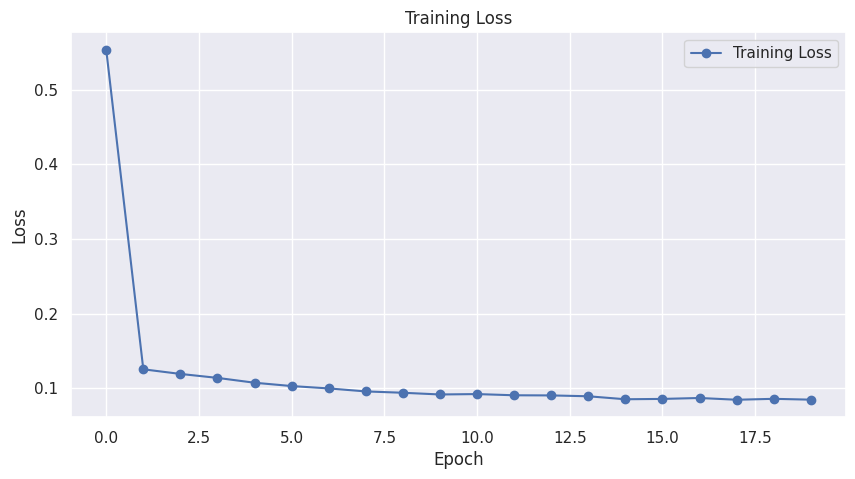

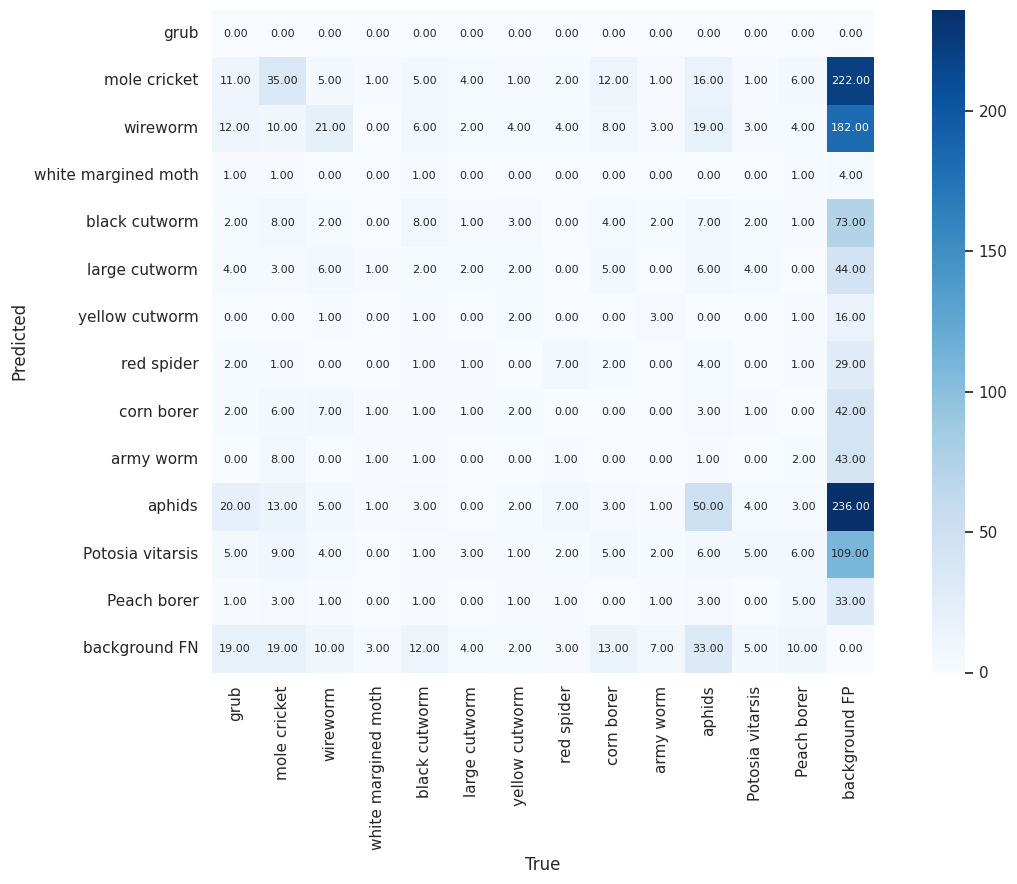

In [ ]:
# Defining parameters for model training
root = 'VOC2007'
annotations_file = '/content/VOC2007/dataset-trainval.txt'
num_classes = 13
backbone_name = 'resnet50'  # 'resnet50' or 'densenet121'
batch_size = 8
num_epochs = 20
tarin_split = 0.85
im_size = (416, 416)

main(root, annotations_file, num_classes, backbone_name, batch_size, num_epochs, tarin_split, im_size)

### Visualizing outputs of the model's training

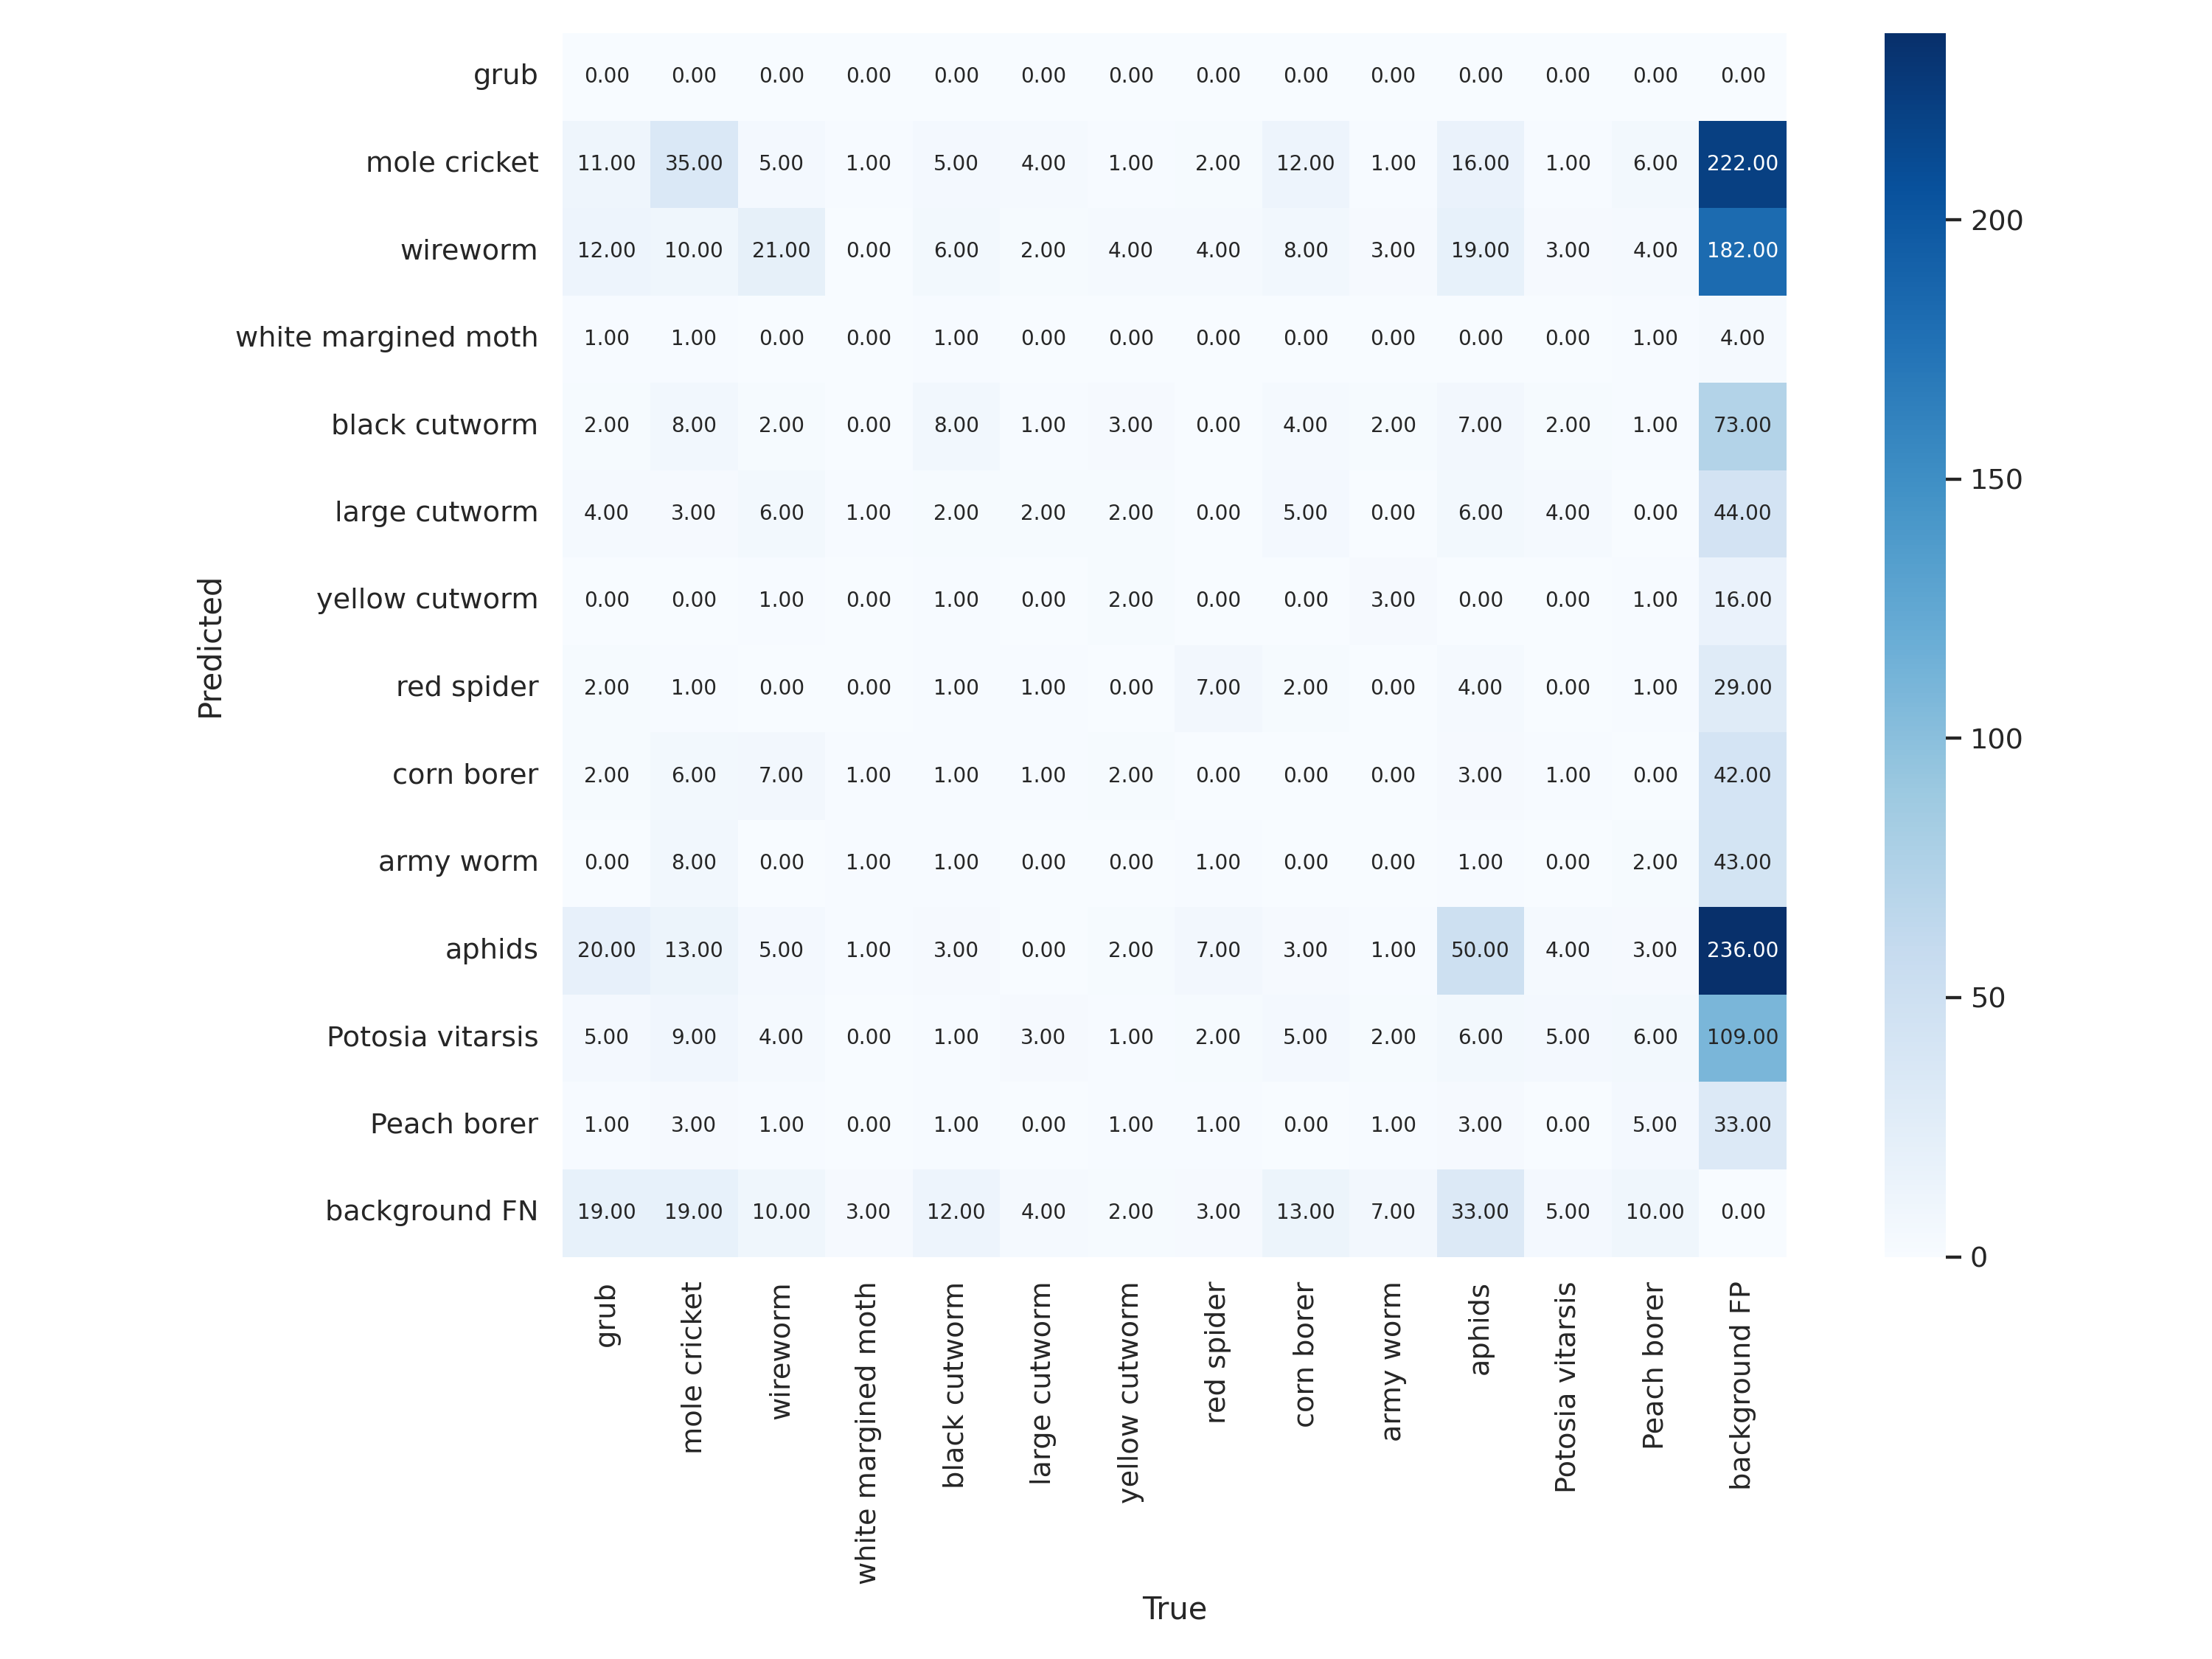

In [ ]:
Img(filename='matrices/resnet50_confusion_matrix.png', height=400)

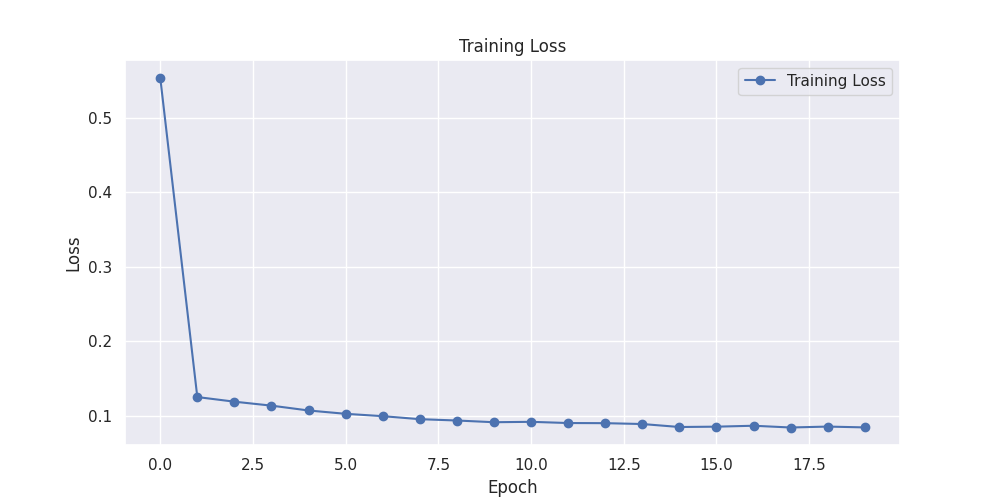

In [ ]:
Img(filename='matrices/resnet50_training_loss.png', height=400)

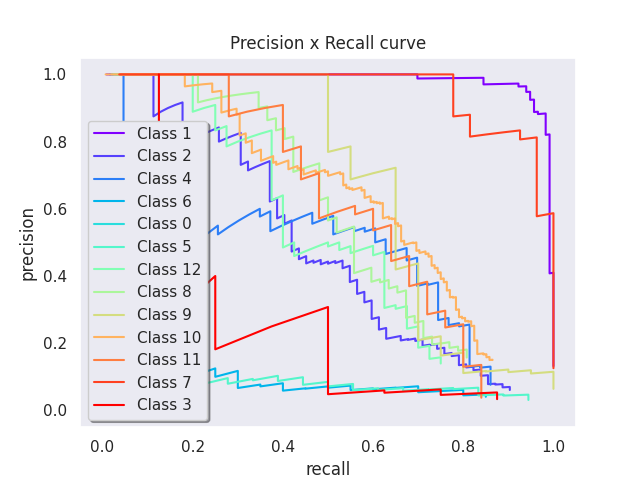

In [ ]:
Img(filename='matrices/resnet50_PR_curve.png', height=400)

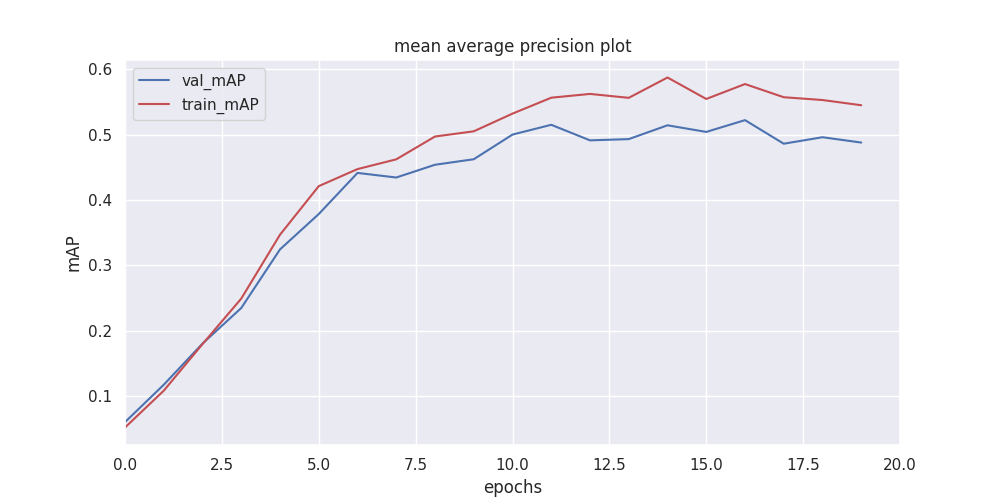

In [ ]:
Img(filename='matrices/resnet50_mAP.png', height=400)

## Evaluation on test data

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'backbone_name' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Validation data counts: {8: 90, 1: 176, 10: 282, 11: 47, 2: 109, 0: 118, 5: 40, 12: 50, 7: 37, 4: 67, 6: 43, 9: 41, 3: 13}
Overall Evaluation
{
    "m_ap": 0.5063289603632248,
    "precision": 0.12945725332951455,
    "recall": 0.8122192273135669,
    "f1": 0.2233201581027668,
    "FP": 6079.0,
    "FN": 209.0,
    "TP": 904.0
}
Class-wise Evaluation
{'8': {'AP': '0.6815280471530631', 'total positives': '90', 'total fn': '7.0', 'total tp': '83.0', 'total fp': '452.0', 'method': 'MethodAveragePrecision.EVERY_POINT_INTERPOLATION', 'iou': '0.5'}, '1': {'AP': '0.9684664341619846', 'total positives': '176', 'total fn': '2.0', 'total tp': '174.0', 'total fp': '566.0', 'method': 'MethodAveragePrecision.EVERY_POINT_INTERPOLATION', 'iou': '0.5'}, '10': {'AP': '0.6670526749044338', 'total positives': '282', 'total fn': '26.0', 'total tp': '256.0', 'total fp': '1162.0', 'method': 'MethodAveragePrecision.EVERY_POINT_INTERPOLATION', 'iou': '0.5'}, '11': {'AP': '0.7977843286067879', 'total positives

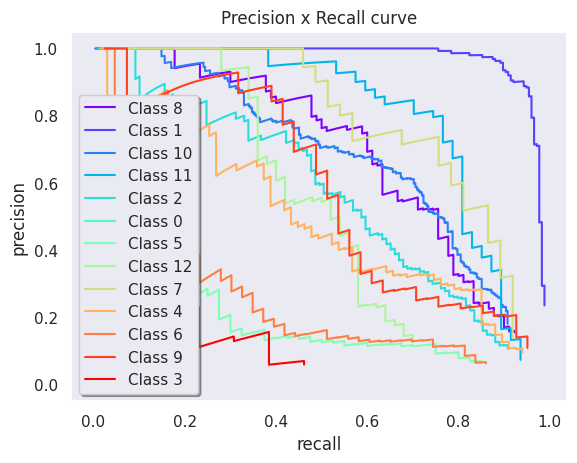

Confusion Matrix:
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
16.0 47.0 9.0 0.0 4.0 4.0 1.0 2.0 7.0 4.0 24.0 9.0 2.0 226.0
8.0 21.0 33.0 3.0 2.0 2.0 1.0 9.0 9.0 1.0 16.0 4.0 5.0 215.0
0.0 0.0 0.0 1.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
10.0 11.0 6.0 2.0 18.0 2.0 5.0 1.0 8.0 9.0 20.0 3.0 3.0 145.0
2.0 2.0 0.0 1.0 2.0 3.0 3.0 1.0 6.0 0.0 7.0 1.0 0.0 61.0
3.0 12.0 5.0 0.0 6.0 2.0 0.0 1.0 5.0 3.0 5.0 2.0 2.0 85.0
9.0 4.0 2.0 0.0 1.0 0.0 2.0 3.0 1.0 1.0 7.0 0.0 1.0 51.0
11.0 10.0 8.0 0.0 3.0 5.0 3.0 1.0 13.0 6.0 9.0 1.0 5.0 125.0
2.0 8.0 3.0 0.0 2.0 1.0 0.0 0.0 6.0 0.0 5.0 1.0 3.0 46.0
28.0 17.0 13.0 3.0 10.0 1.0 7.0 9.0 8.0 3.0 118.0 9.0 7.0 478.0
10.0 6.0 8.0 2.0 2.0 4.0 3.0 2.0 8.0 3.0 19.0 9.0 6.0 134.0
0.0 4.0 1.0 0.0 0.0 1.0 1.0 1.0 2.0 1.0 3.0 0.0 6.0 37.0
19.0 34.0 21.0 1.0 17.0 15.0 16.0 7.0 17.0 10.0 49.0 8.0 10.0 0.0


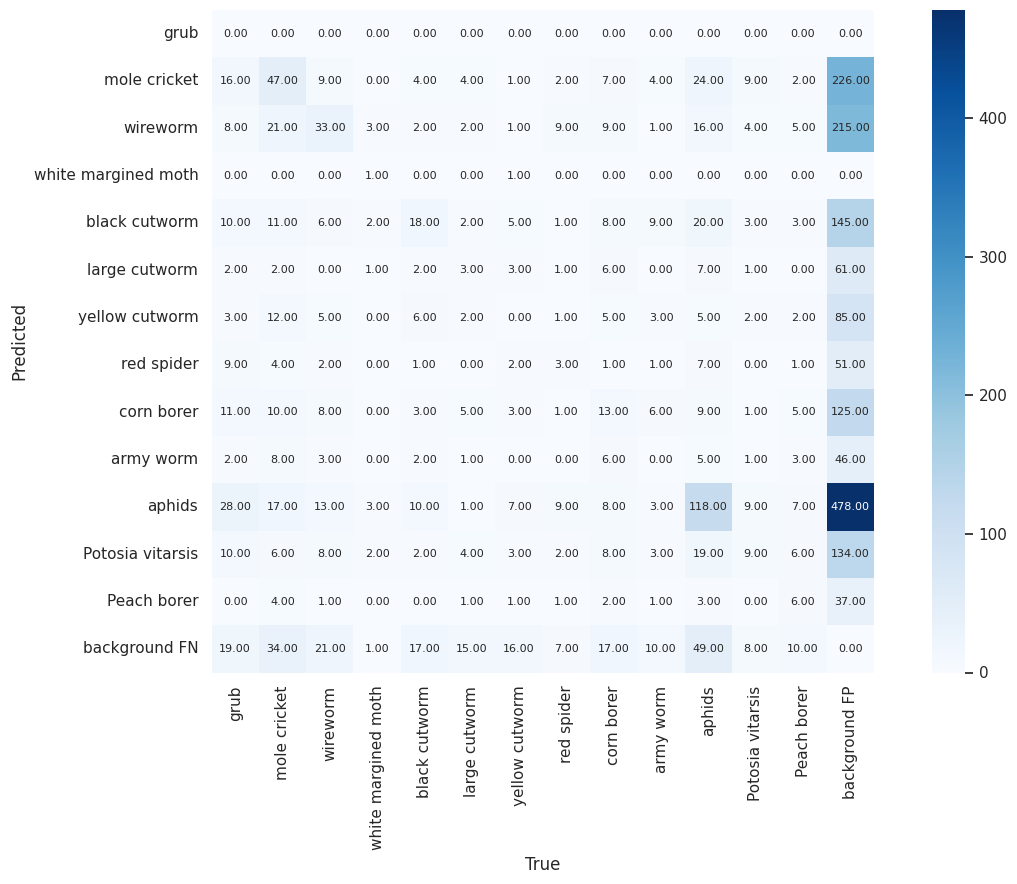

In [ ]:
# Set the root directory of the dataset, the annotations file, the batch size, and the model weights
root = 'VOC2007'
annotations_file = 'dataset-test.txt'
batch_size = 8
weights = '/content/checkpoints/resnet50_epoch-16_map-0.5224383420426021.pth'

# Create a VOCDataset object and a DataLoader object
dataset = VOCDataset(root, annotations_file, transforms=get_transform((416, 416)))
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

# Set the number of classes, the backbone network, and the device
num_classes = 13
backbone_name = 'resnet50'  # Choose 'resnet50' or 'densenet121'
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Create a FasterRCNNBuilder object and a Faster R-CNN model, and load the model weights
model_builder = FasterRCNNBuilder(num_classes, backbone_name)
model = model_builder.create_model()
state_dict = torch.load(weights, map_location=device)
model.load_state_dict(state_dict)
model.to(device)

# Evaluate the model on the test dataset
mAP, confMat, per_class_pec_rec = evaluate(model, loader, device, iou_threshold=0.5, valcount=True)
print(f'mAp: {mAP}')
plot_precision_recall_curve(per_class_pec_rec, save_path=f'matrices/{backbone_name}_val')

print('Confusion Matrix:')
confMat.print_matrix()
confMat.plot_metric(save_path=f'matrices/{backbone_name}_val_confusion_matrix.png')



### Visualizing testdata output

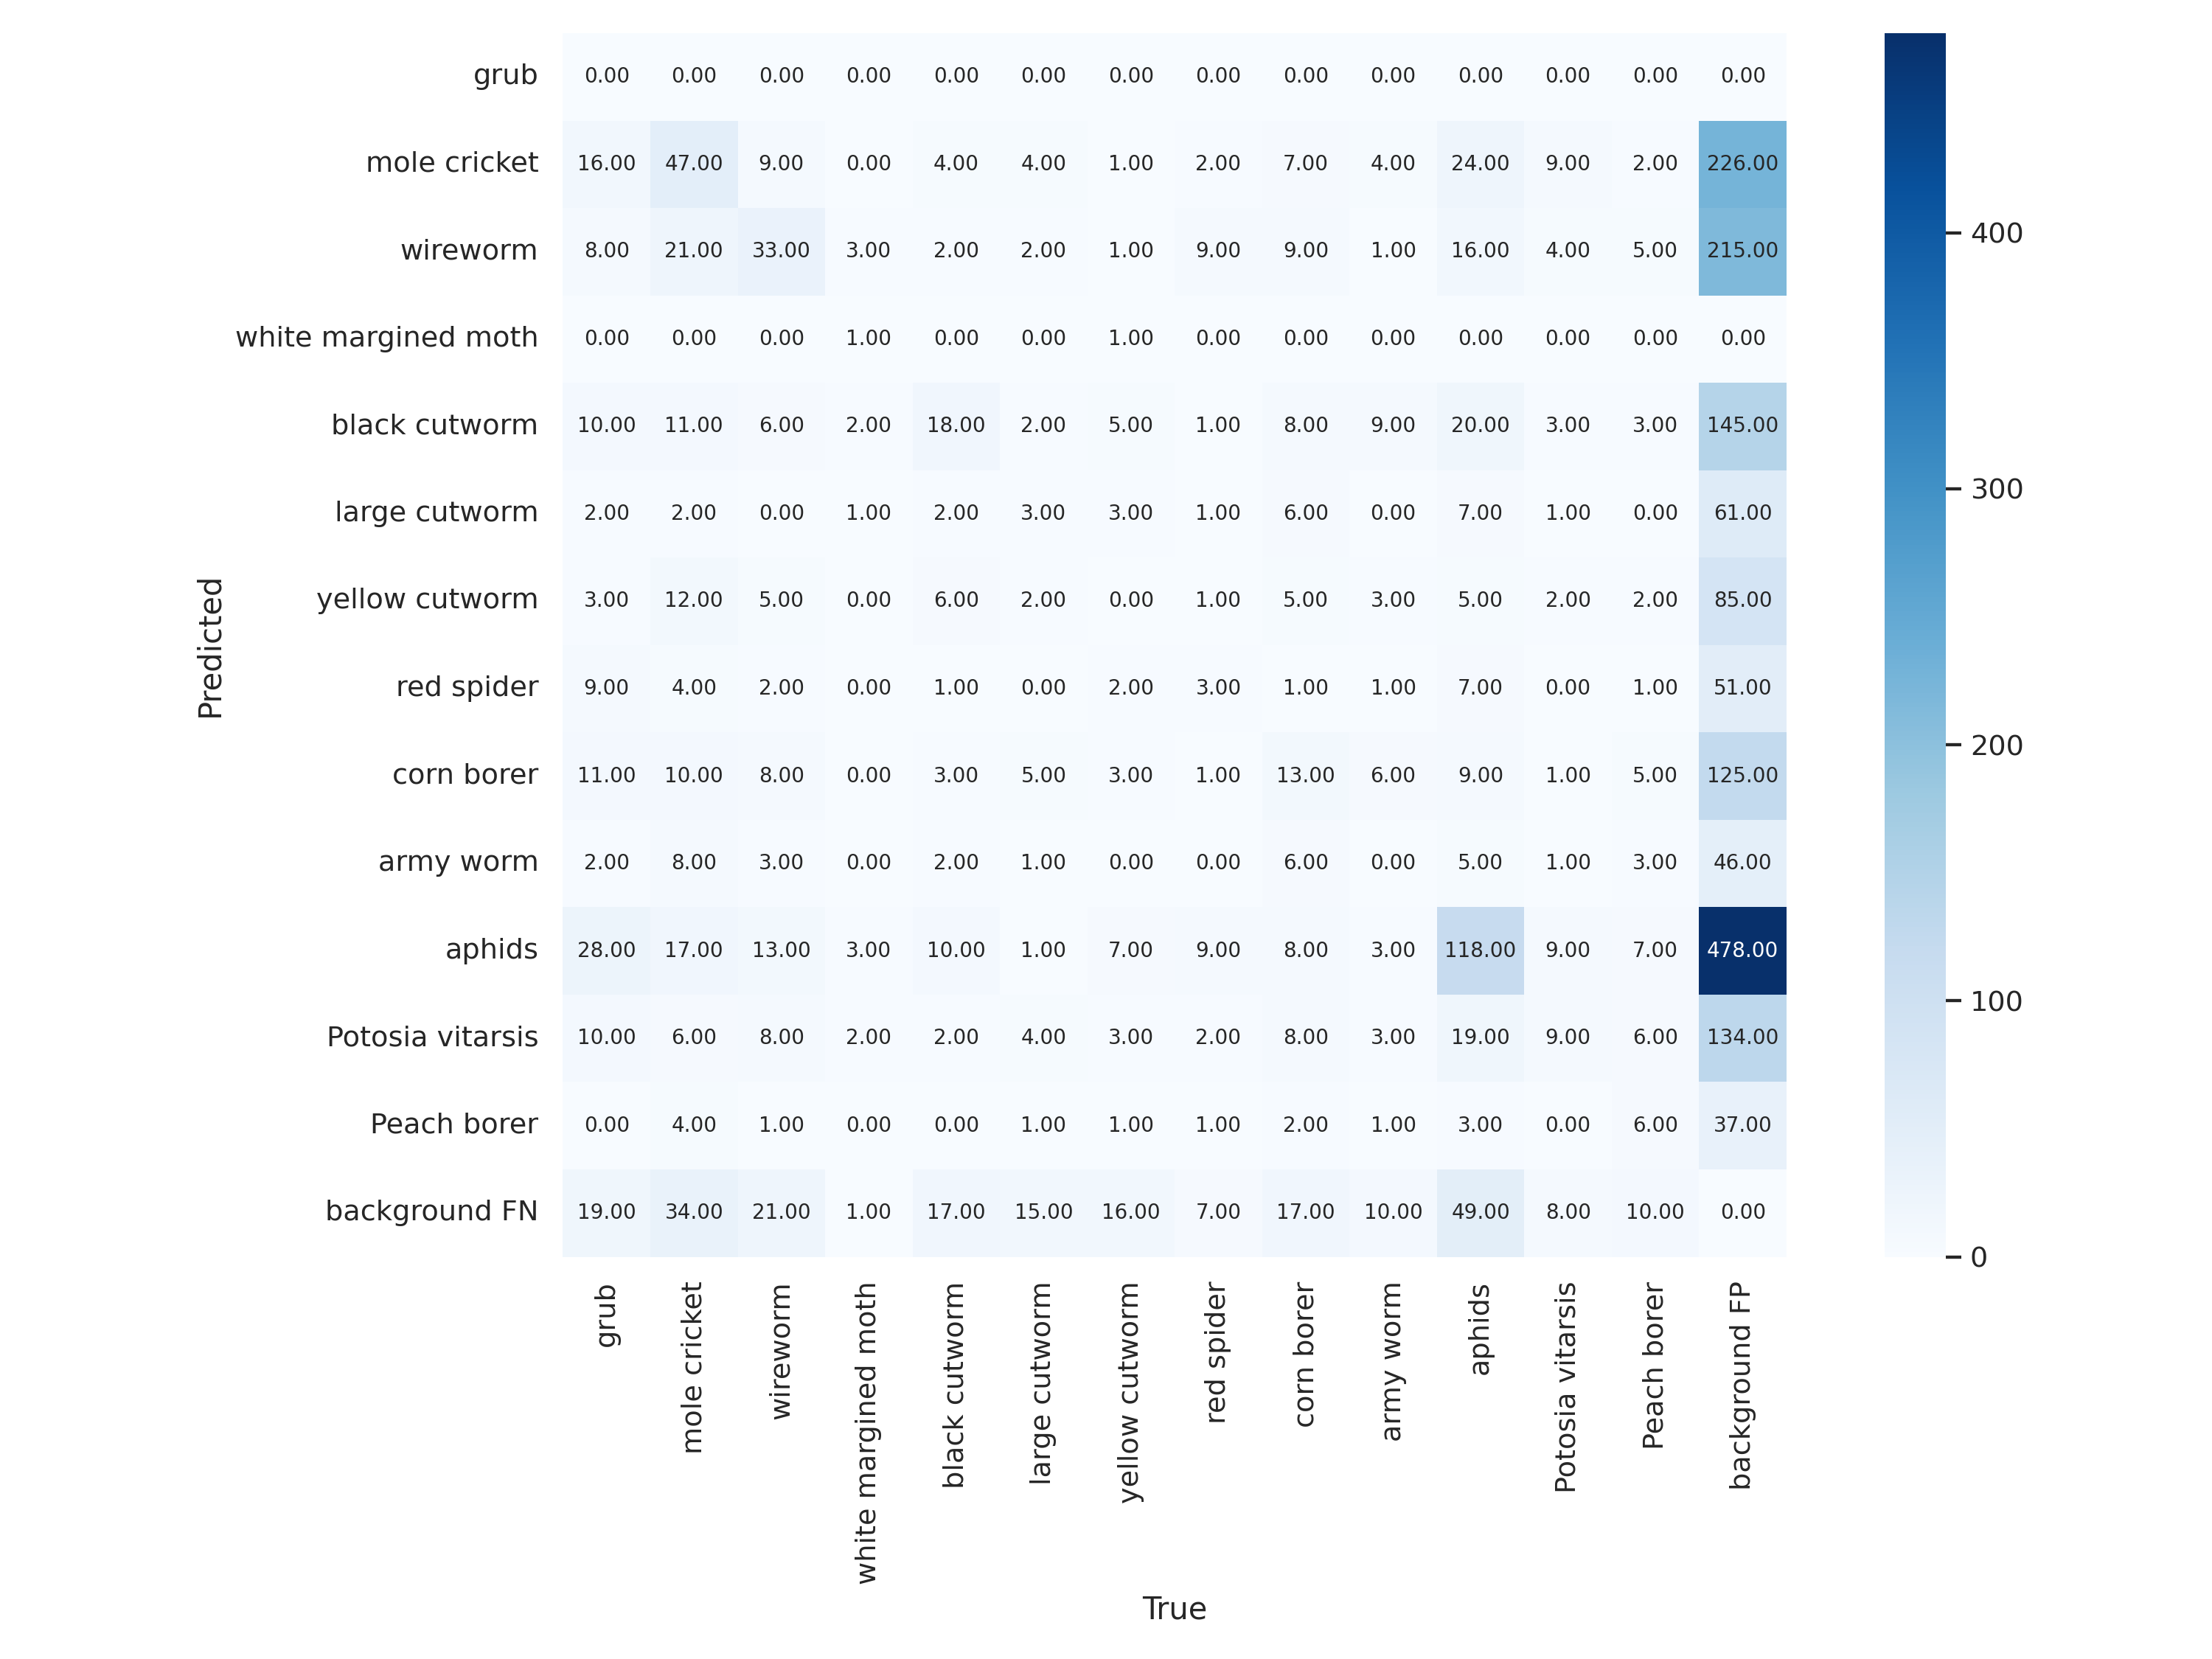

In [ ]:
Img(filename='matrices/resnet50_val_confusion_matrix.png', height=400)

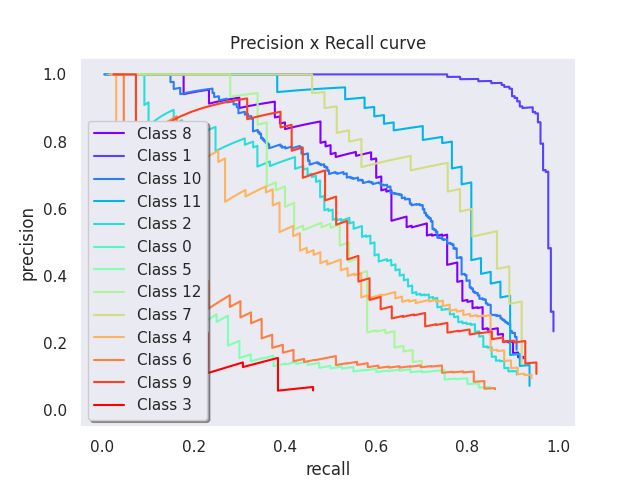

In [ ]:
Img(filename='matrices/resnet50_val_PR_curve.png', height=400)

## Inference on single image from test data

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'backbone_name' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


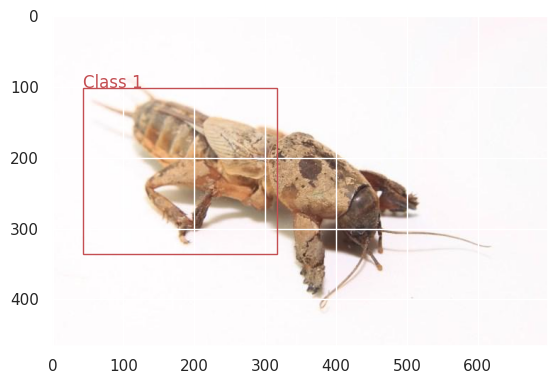

In [ ]:
# Inference using the specified weights and backbone model
weight_path = '/content/checkpoints/resnet50_epoch-16_map-0.5224383420426021.pth'
inference = Infernce(weights=weight_path, backbone_name='resnet50')
impath = '/content/VOC2007/JPEGImages/IP015001020.jpg'
inference.predict(im_path=impath)


# HyperParameter Tuning of Faster R-CNN with DenseNet121 model

Training with batch_size=8, lr=0.001, weight_decay=0.005


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Training Batch: 100%|██████████| 386/386 [06:17<00:00,  1.22batch/s]
                                                                    

Epoch 1, Training Loss: 7.850724908354369
train data counts: {6: 146, 8: 291, 9: 151, 4: 207, 1: 603, 2: 346, 12: 168, 5: 118, 0: 480, 10: 1005, 11: 157, 7: 114, 3: 40}
Validation data counts: {10: 108, 8: 59, 9: 24, 2: 77, 4: 43, 1: 98, 0: 78, 12: 36, 11: 34, 6: 20, 5: 18, 7: 17, 3: 7}
Overall Evaluation
{
    "m_ap": 0.0516570363303684,
    "precision": 0.04319167389418907,
    "recall": 0.40226171243941844,
    "f1": 0.07800751879699247,
    "FP": 5516.0,
    "FN": 370.0,
    "TP": 249.0
}
Class-wise Evaluation
{'10': {'AP': '0.1069654044298526', 'total positives': '108', 'total fn': '35.0', 'total tp': '73.0', 'total fp': '2211.0', 'method': 'MethodAveragePrecision.EVERY_POINT_INTERPOLATION', 'iou': '0.5'}, '8': {'AP': '0.04358443260605335', 'total positives': '59', 'total fn': '25.0', 'total tp': '34.0', 'total fp': '591.0', 'method': 'MethodAveragePrecision.EVERY_POINT_INTERPOLATION', 'iou': '0.5'}, '9': {'AP': '0.035737179487179485', 'total positives': '24', 'total fn': '21.0', 

Epochs:  33%|███▎      | 1/3 [08:47<17:34, 527.31s/epoch]

best mAp (val): 0.0516570363303684



Training Batch: 100%|██████████| 386/386 [05:50<00:00,  1.22batch/s]
                                                                    

Epoch 2, Training Loss: 3.0975368807352885
Overall Evaluation
{
    "m_ap": 0.11945292008873433,
    "precision": 0.06350450803606429,
    "recall": 0.5234248788368336,
    "f1": 0.11326691137912952,
    "FP": 4778.0,
    "FN": 295.0,
    "TP": 324.0
}
Class-wise Evaluation
{'10': {'AP': '0.2891604745342022', 'total positives': '108', 'total fn': '18.0', 'total tp': '90.0', 'total fp': '1444.0', 'method': 'MethodAveragePrecision.EVERY_POINT_INTERPOLATION', 'iou': '0.5'}, '8': {'AP': '0.21191766145352128', 'total positives': '59', 'total fn': '9.0', 'total tp': '50.0', 'total fp': '1052.0', 'method': 'MethodAveragePrecision.EVERY_POINT_INTERPOLATION', 'iou': '0.5'}, '9': {'AP': '0.0', 'total positives': '24', 'total fn': '24.0', 'total tp': '0.0', 'total fp': '1.0', 'method': 'MethodAveragePrecision.EVERY_POINT_INTERPOLATION', 'iou': '0.5'}, '2': {'AP': '0.08750931387110919', 'total positives': '77', 'total fn': '31.0', 'total tp': '46.0', 'total fp': '641.0', 'method': 'MethodAveragePr

Epochs:  67%|██████▋   | 2/3 [17:18<08:37, 517.64s/epoch]

best mAp (val): 0.11945292008873433



Training Batch: 100%|██████████| 386/386 [05:51<00:00,  1.21batch/s]
                                                                    

Epoch 3, Training Loss: 2.6166088213574703
Overall Evaluation
{
    "m_ap": 0.1991534707296726,
    "precision": 0.09231468849477036,
    "recall": 0.6558966074313409,
    "f1": 0.161849710982659,
    "FP": 3992.0,
    "FN": 213.0,
    "TP": 406.0
}
Class-wise Evaluation
{'10': {'AP': '0.3201980193561618', 'total positives': '108', 'total fn': '17.0', 'total tp': '91.0', 'total fp': '947.0', 'method': 'MethodAveragePrecision.EVERY_POINT_INTERPOLATION', 'iou': '0.5'}, '8': {'AP': '0.31266996638122896', 'total positives': '59', 'total fn': '6.0', 'total tp': '53.0', 'total fp': '786.0', 'method': 'MethodAveragePrecision.EVERY_POINT_INTERPOLATION', 'iou': '0.5'}, '9': {'AP': '0.05197477769467298', 'total positives': '24', 'total fn': '9.0', 'total tp': '15.0', 'total fp': '189.0', 'method': 'MethodAveragePrecision.EVERY_POINT_INTERPOLATION', 'iou': '0.5'}, '2': {'AP': '0.15974831988714586', 'total positives': '77', 'total fn': '25.0', 'total tp': '52.0', 'total fp': '614.0', 'method': 'Me

Epochs: 100%|██████████| 3/3 [25:49<00:00, 516.64s/epoch]

best mAp (val): 0.1991534707296726


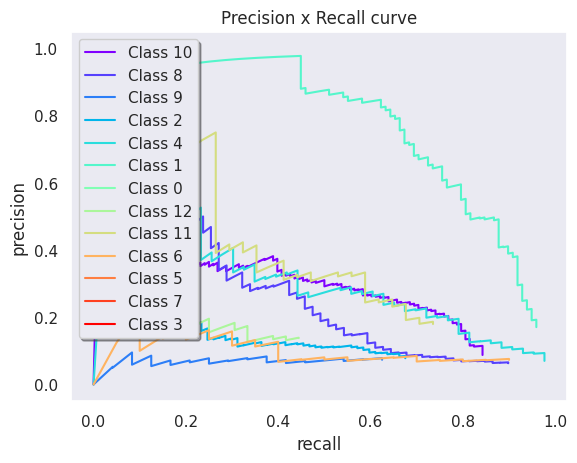

Confusion Matrix:
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
6.0 42.0 7.0 1.0 9.0 0.0 3.0 1.0 6.0 9.0 20.0 7.0 2.0 245.0
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
21.0 18.0 10.0 3.0 14.0 2.0 5.0 6.0 12.0 3.0 35.0 10.0 4.0 156.0
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
51.0 38.0 60.0 3.0 20.0 16.0 12.0 10.0 41.0 12.0 53.0 17.0 30.0 0.0
Overall Evaluation
{
    "m_ap": 0.0,
    "precision": 0.0,
    "recall": 0.0,
    "f1": 0,
    "FP": 54500.0,
    "FN": 664.0,
    "TP": 0.0
}
Class-wise Evaluation
{'9': {

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Training Batch: 100%|██████████| 386/386 [06:16<00:00,  1.23batch/s]
                                                                    

Epoch 1, Training Loss: 7.925715192611971
train data counts: {1: 594, 6: 138, 10: 957, 0: 465, 11: 161, 8: 289, 5: 121, 7: 118, 2: 361, 4: 216, 12: 164, 3: 41, 9: 151}
Validation data counts: {11: 30, 2: 62, 1: 107, 10: 156, 8: 61, 0: 93, 6: 28, 4: 34, 9: 24, 12: 40, 5: 15, 3: 6, 7: 13}
Overall Evaluation
{
    "m_ap": 0.07657621384444838,
    "precision": 0.046479521398987575,
    "recall": 0.452914798206278,
    "f1": 0.08430717863105175,
    "FP": 6216.0,
    "FN": 366.0,
    "TP": 303.0
}
Class-wise Evaluation
{'11': {'AP': '0.0058823529411764705', 'total positives': '30', 'total fn': '27.0', 'total tp': '3.0', 'total fp': '59.0', 'method': 'MethodAveragePrecision.EVERY_POINT_INTERPOLATION', 'iou': '0.5'}, '2': {'AP': '0.016878652045145274', 'total positives': '62', 'total fn': '34.0', 'total tp': '28.0', 'total fp': '844.0', 'method': 'MethodAveragePrecision.EVERY_POINT_INTERPOLATION', 'iou': '0.5'}, '1': {'AP': '0.584736858102302', 'total positives': '107', 'total fn': '3.0', 'to

Epochs:  33%|███▎      | 1/3 [08:46<17:32, 526.01s/epoch]

best mAp (val): 0.07657621384444838



Training Batch: 100%|██████████| 386/386 [05:49<00:00,  1.22batch/s]
                                                                    

Epoch 2, Training Loss: 3.0818111464149593
Overall Evaluation
{
    "m_ap": 0.11591746346026154,
    "precision": 0.07060548921014037,
    "recall": 0.5037369207772795,
    "f1": 0.12385152517456814,
    "FP": 4436.0,
    "FN": 332.0,
    "TP": 337.0
}
Class-wise Evaluation
{'11': {'AP': '0', 'total positives': '30', 'total fn': '30.0', 'total tp': '0.0', 'total fp': '0.0', 'method': 'MethodAveragePrecision.EVERY_POINT_INTERPOLATION', 'iou': '0.5'}, '2': {'AP': '0.06427308021947481', 'total positives': '62', 'total fn': '21.0', 'total tp': '41.0', 'total fp': '917.0', 'method': 'MethodAveragePrecision.EVERY_POINT_INTERPOLATION', 'iou': '0.5'}, '1': {'AP': '0.6985894978856858', 'total positives': '107', 'total fn': '5.0', 'total tp': '102.0', 'total fp': '886.0', 'method': 'MethodAveragePrecision.EVERY_POINT_INTERPOLATION', 'iou': '0.5'}, '10': {'AP': '0.29089680242504173', 'total positives': '156', 'total fn': '43.0', 'total tp': '113.0', 'total fp': '1358.0', 'method': 'MethodAverageP

Epochs:  67%|██████▋   | 2/3 [17:17<08:37, 517.18s/epoch]

best mAp (val): 0.11591746346026154



Training Batch: 100%|██████████| 386/386 [05:50<00:00,  1.22batch/s]
                                                                    

Epoch 3, Training Loss: 2.5426184547379846
Overall Evaluation
{
    "m_ap": 0.18991623563422394,
    "precision": 0.10440539852304558,
    "recall": 0.6128550074738416,
    "f1": 0.17841601392515233,
    "FP": 3517.0,
    "FN": 259.0,
    "TP": 410.0
}
Class-wise Evaluation
{'11': {'AP': '0.21428737418939506', 'total positives': '30', 'total fn': '15.0', 'total tp': '15.0', 'total fp': '68.0', 'method': 'MethodAveragePrecision.EVERY_POINT_INTERPOLATION', 'iou': '0.5'}, '2': {'AP': '0.12937621248420747', 'total positives': '62', 'total fn': '16.0', 'total tp': '46.0', 'total fp': '690.0', 'method': 'MethodAveragePrecision.EVERY_POINT_INTERPOLATION', 'iou': '0.5'}, '1': {'AP': '0.7913088942594871', 'total positives': '107', 'total fn': '3.0', 'total tp': '104.0', 'total fp': '412.0', 'method': 'MethodAveragePrecision.EVERY_POINT_INTERPOLATION', 'iou': '0.5'}, '10': {'AP': '0.40660597730815407', 'total positives': '156', 'total fn': '32.0', 'total tp': '124.0', 'total fp': '857.0', 'metho

Epochs: 100%|██████████| 3/3 [25:42<00:00, 514.14s/epoch]

best mAp (val): 0.18991623563422394


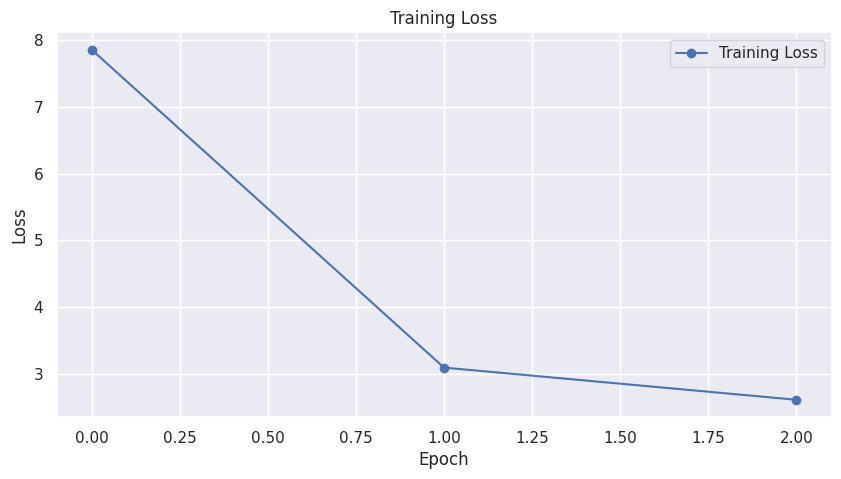

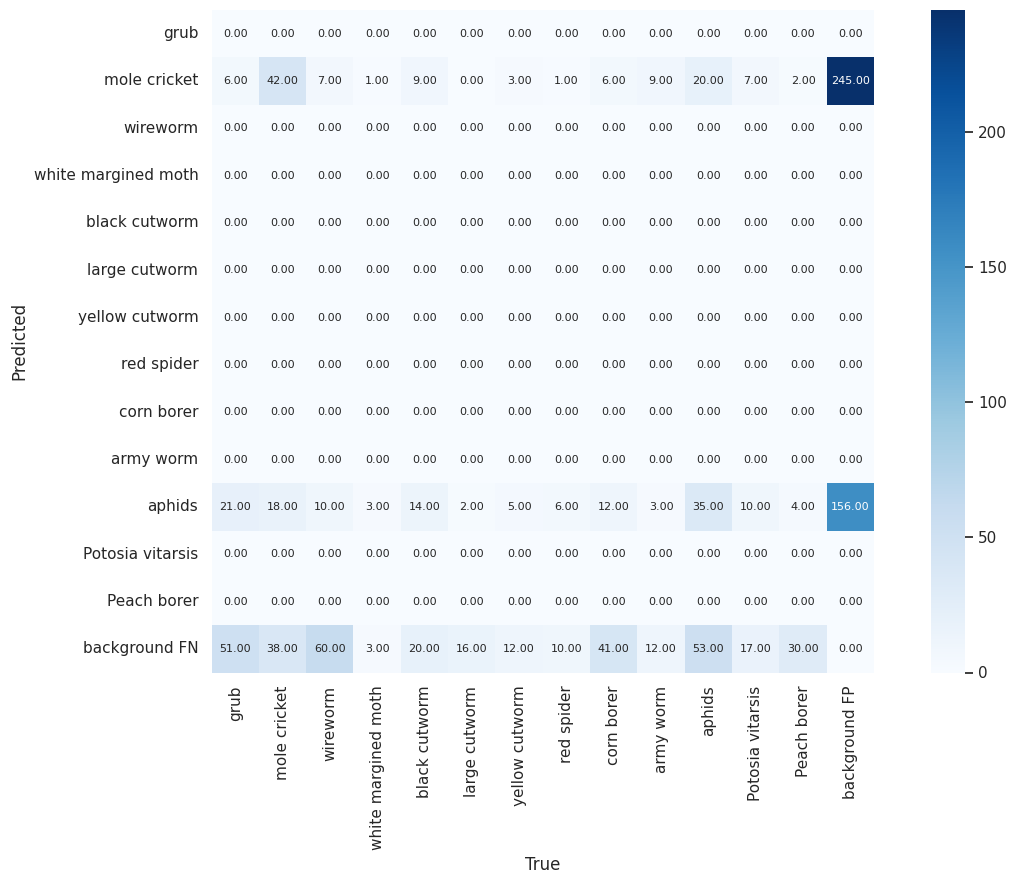

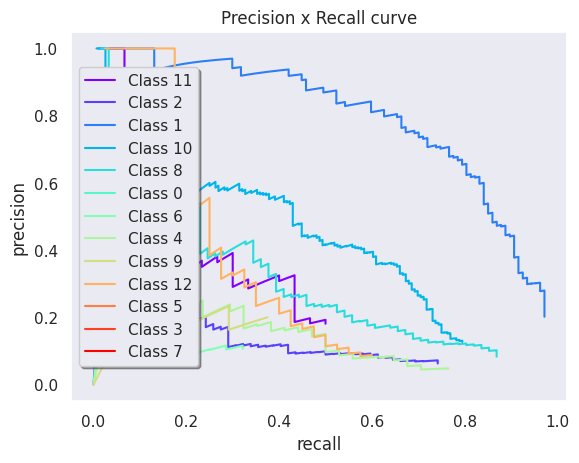

Confusion Matrix:
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
5.0 33.0 5.0 0.0 2.0 1.0 2.0 2.0 1.0 3.0 9.0 2.0 4.0 156.0
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
23.0 23.0 9.0 3.0 9.0 5.0 6.0 4.0 13.0 7.0 65.0 9.0 6.0 167.0
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
65.0 51.0 48.0 3.0 23.0 9.0 20.0 7.0 47.0 14.0 82.0 19.0 30.0 0.0
Overall Evaluation
{
    "m_ap": 0.0,
    "precision": 0.0,
    "recall": 0.0,
    "f1": 0,
    "FP": 54500.0,
    "FN": 664.0,
    "TP": 0.0
}
Class-wise Evaluation
{'9': {'AP': 

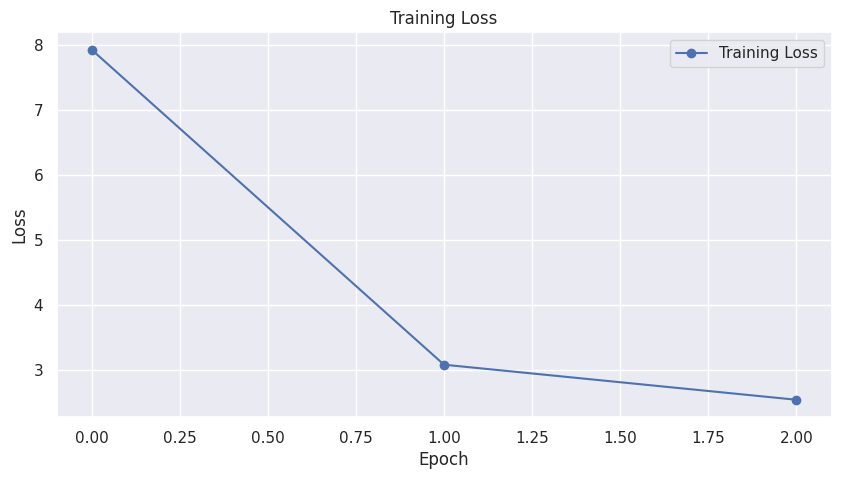

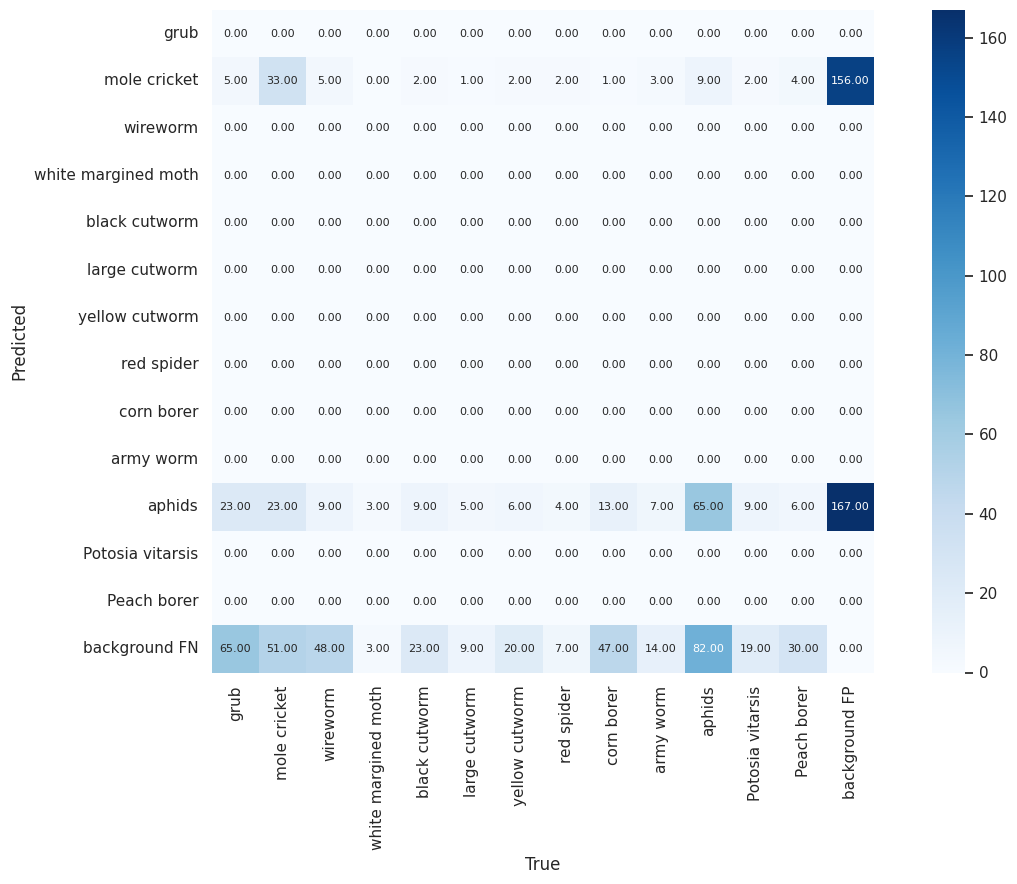

In [ ]:
from torchvision.transforms import transforms
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

root = 'VOC2007'
annotations_file = 'dataset-trainval.txt'
backbone_name = 'densenet121'
num_epochs = 3
num_classes = 13
train_split = 0.85
im_size=(416, 416)
tarin_split = 0.85

def hyperparameter_tuning(root, annotations_file, num_classes, backbone_name, batch_sizes, learning_rates, weight_decays, num_epochs, train_split, im_size):
    best_val_mAP = 0.0
    best_hyperparameters = (batch_sizes[0], learning_rates[0], weight_decays[0])  # Initialize to the first set of hyperparameters
    results = {}

    # Load the dataset
    dataset = VOCDataset(root, annotations_file, transforms=get_transform(im_size))

    # Calculate the total size
    total_size = len(dataset)

    # Calculate the train and validation sizes
    train_size = int(train_split * total_size)
    val_size = total_size - train_size

    # Split the dataset into training and validation sets
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    for batch_size in batch_sizes:
        for lr in learning_rates:
            for weight_decay in weight_decays:
                print(f"Training with batch_size={batch_size}, lr={lr}, weight_decay={weight_decay}")

                # Create data loaders
                train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
                val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

                # Build and train the model
                model_builder = FasterRCNNBuilder(num_classes, backbone_name)
                model = model_builder.create_model()
                model.to(device)

                params = [p for p in model.parameters() if p.requires_grad]
                optimizer = optim.SGD(params, lr=lr, momentum=0.9, weight_decay=weight_decay)

                # Train the model
                main(root, annotations_file, num_classes, backbone_name, batch_size, num_epochs, train_split, im_size)

                # Evaluate the model
                val_mAP, _, _ = evaluate(model, val_loader, device=device)
                train_mAP, _, _ = evaluate(model, train_loader, device=device)

                # If this is the best validation mAP so far, update the best hyperparameters
                if val_mAP > best_val_mAP:
                    best_val_mAP = val_mAP
                    best_hyperparameters = (batch_size, lr, weight_decay)

                # Store the results
                results[(batch_size, lr, weight_decay)] = {'val_mAP': val_mAP, 'train_mAP': train_mAP}

    return best_hyperparameters, best_val_mAP, results

# Define the hyperparameters
batch_sizes = [8]
learning_rates = [0.001, 0.01]
weight_decays = [0.005]

# Perform hyperparameter tuning
best_hyperparameters, best_val_mAP, results = hyperparameter_tuning(root, annotations_file, num_classes, backbone_name, batch_sizes, learning_rates, weight_decays, num_epochs, tarin_split, im_size)

print(f"Best hyperparameters: batch_size={best_hyperparameters[0]}, lr={best_hyperparameters[1]}, weight_decay={best_hyperparameters[2]}")
print(f"Best validation mAP: {best_val_mAP}")


# Yolo Model

## Installing and setting up the ultralytics package

In [ ]:
# Install the ultralytics package
!pip install ultralytics
# Import the ultralytics package
import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.2.18 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (NVIDIA L4, 22700MiB)
Setup complete ✅ (16 CPUs, 62.8 GB RAM, 43.5/201.2 GB disk)


In [ ]:
# Generating a YAML configuration file for a dataset
# Import the yaml module
import yaml

data = {
    'path': '/content/datasets/dataset-yolo',
    'train': 'train/images',
    'val': 'valid/images',
    'test': 'test/images',
    'nc': 13,
    'names':[
                "grub",                # 14
                "mole cricket",        # 15
                "wireworm",            # 16
                "white margined moth", # 17
                "black cutworm",       # 18
                "large cutworm",       # 19
                "yellow cutworm",      # 20
                "red spider",          # 21
                "corn borer",          # 22
                "army worm",           # 23
                "aphids",              # 24
                "Potosia vitarsis",    # 25
                "Peach borer"          # 26
                ""
            ]
}

# Open the configuration file in write mode
with open('data.yaml', 'w') as file:
    yaml.dump(data, file)


## Training a YOLO model with the ultralytics package

In [ ]:
from ultralytics import YOLO
model = YOLO('yolov8m.pt')
dataset_yaml = 'data.yaml'

model.train(data=dataset_yaml,
            epochs=20,
            imgsz=416,
            batch=8,
            project='YOLOv8-Pest',
            name=f'EX1',
            device=0,
            )

100%|██████████| 49.7M/49.7M [00:00<00:00, 267MB/s]


Ultralytics YOLOv8.2.18 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (NVIDIA L4, 22700MiB)
engine/trainer: task=detect, mode=train, model=yolov8m.pt, data=data.yaml, epochs=20, time=None, patience=100, batch=8, imgsz=416, save=True, save_period=-1, cache=False, device=0, workers=8, project=YOLOv8-Pest, name=EX1, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, lin

100%|██████████| 755k/755k [00:00<00:00, 21.1MB/s]


Overriding model.yaml nc=80 with nc=13

                   from  n    params  module                                       arguments                     
  0                  -1  1      1392  ultralytics.nn.modules.conv.Conv             [3, 48, 3, 2]                 
  1                  -1  1     41664  ultralytics.nn.modules.conv.Conv             [48, 96, 3, 2]                
  2                  -1  2    111360  ultralytics.nn.modules.block.C2f             [96, 96, 2, True]             
  3                  -1  1    166272  ultralytics.nn.modules.conv.Conv             [96, 192, 3, 2]               
  4                  -1  4    813312  ultralytics.nn.modules.block.C2f             [192, 192, 4, True]           
  5                  -1  1    664320  ultralytics.nn.modules.conv.Conv             [192, 384, 3, 2]              
  6                  -1  4   3248640  ultralytics.nn.modules.block.C2f             [384, 384, 4, True]           
  7                  -1  1   1991808  ultralytic

100%|██████████| 6.23M/6.23M [00:00<00:00, 129MB/s]
/usr/local/lib/python3.10/dist-packages/ultralytics/utils/torch_utils.py:199: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#cublasApi_reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:164.)
  fusedconv.weight.copy_(torch.mm(w_bn, w_conv).view(fusedconv.weight.shape))
/usr/local/lib/python3.10/dist-packages/ultralytics/utils/torch_utils.py:204: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Contex

AMP: checks passed ✅


train: Scanning /content/datasets/dataset-yolo/train/labels... 3111 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3111/3111 [00:02<00:00, 1267.01it/s]


train: New cache created: /content/datasets/dataset-yolo/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/datasets/dataset-yolo/valid/labels... 518 images, 0 backgrounds, 0 corrupt: 100%|██████████| 518/518 [00:00<00:00, 1094.09it/s]

val: New cache created: /content/datasets/dataset-yolo/valid/labels.cache


Plotting labels to YOLOv8-Pest/EX1/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000588, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 416 train, 416 val
Using 8 dataloader workers
Logging results to YOLOv8-Pest/EX1
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/389 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#cublasApi_reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:164.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
       1/20      21.1G      1.504      2.314      1.631         21        416: 100%|██████████| 389/389 [00:43<00:00,  8.95it/s]
                 Class     Images  Instances      Box(P          R 

                   all        518        604      0.561      0.439       0.46      0.253



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/389 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#cublasApi_reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:164.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
       2/20      2.47G      1.526      1.905       1.64         26        416: 100%|██████████| 389/389 [00:40<00:00,  9.59it/s]
                 Class     Images  Instances      Box(P          R 

                   all        518        604      0.457      0.482      0.489      0.257



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/389 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#cublasApi_reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:164.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
       3/20      2.37G      1.526      1.901      1.663         21        416: 100%|██████████| 389/389 [00:39<00:00,  9.83it/s]
                 Class     Images  Instances      Box(P          R 

                   all        518        604      0.636      0.421      0.478      0.259



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/389 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#cublasApi_reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:164.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
       4/20      2.47G      1.493      1.815      1.641         20        416: 100%|██████████| 389/389 [00:39<00:00,  9.92it/s]
                 Class     Images  Instances      Box(P          R 

                   all        518        604      0.531      0.438      0.518      0.292



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/389 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#cublasApi_reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:164.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
       5/20      2.36G      1.472      1.682      1.609         24        416: 100%|██████████| 389/389 [00:39<00:00,  9.86it/s]
                 Class     Images  Instances      Box(P          R 

                   all        518        604      0.748      0.495      0.584      0.353



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/389 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#cublasApi_reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:164.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
       6/20      2.44G      1.427      1.575       1.57         17        416: 100%|██████████| 389/389 [00:39<00:00,  9.94it/s]
                 Class     Images  Instances      Box(P          R 

                   all        518        604      0.711      0.544      0.615      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/389 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#cublasApi_reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:164.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
       7/20      2.47G      1.401       1.49      1.553         18        416: 100%|██████████| 389/389 [00:39<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R 

                   all        518        604      0.464      0.735      0.678      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/389 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#cublasApi_reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:164.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
       8/20      2.47G       1.36      1.423       1.53         18        416: 100%|██████████| 389/389 [00:39<00:00,  9.87it/s]
                 Class     Images  Instances      Box(P          R 

                   all        518        604      0.557      0.673      0.661      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/389 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#cublasApi_reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:164.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
       9/20      2.47G      1.344      1.363      1.515         14        416: 100%|██████████| 389/389 [00:39<00:00,  9.94it/s]
                 Class     Images  Instances      Box(P          R 

                   all        518        604      0.612      0.686      0.689      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/389 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#cublasApi_reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:164.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      10/20      2.47G      1.316      1.301       1.51         19        416: 100%|██████████| 389/389 [00:39<00:00,  9.90it/s]
                 Class     Images  Instances      Box(P          R 

                   all        518        604      0.527      0.719      0.658      0.431


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/389 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#cublasApi_reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:164.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      11/20      2.43G      1.294      1.082      1.516          7        416: 100%|██████████| 389/389 [00:40<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R 

                   all        518        604      0.763       0.62      0.651      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/389 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#cublasApi_reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:164.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      12/20      2.47G      1.253      1.007      1.494          8        416: 100%|██████████| 389/389 [00:39<00:00,  9.81it/s]
                 Class     Images  Instances      Box(P          R 

                   all        518        604      0.635       0.72      0.711      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/389 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#cublasApi_reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:164.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      13/20      2.36G      1.228     0.9474      1.471          7        416: 100%|██████████| 389/389 [00:39<00:00,  9.88it/s]
                 Class     Images  Instances      Box(P          R 

                   all        518        604      0.543      0.774      0.687      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/389 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#cublasApi_reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:164.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      14/20      2.47G      1.179      0.893      1.429          9        416: 100%|██████████| 389/389 [00:39<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R 

                   all        518        604      0.632      0.793      0.706      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/389 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#cublasApi_reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:164.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      15/20      2.48G      1.169      0.836      1.423          8        416: 100%|██████████| 389/389 [00:39<00:00,  9.95it/s]
                 Class     Images  Instances      Box(P          R 

                   all        518        604       0.58      0.837      0.743      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/389 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#cublasApi_reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:164.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      16/20      2.47G      1.133     0.7828      1.392         11        416: 100%|██████████| 389/389 [00:39<00:00,  9.82it/s]
                 Class     Images  Instances      Box(P          R 

                   all        518        604      0.605      0.853      0.736       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/389 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#cublasApi_reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:164.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      17/20      2.47G      1.103     0.7493      1.375          7        416: 100%|██████████| 389/389 [00:39<00:00,  9.82it/s]
                 Class     Images  Instances      Box(P          R 

                   all        518        604      0.632      0.813      0.755      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/389 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#cublasApi_reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:164.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      18/20      2.48G      1.066     0.7071      1.355          9        416: 100%|██████████| 389/389 [00:39<00:00,  9.80it/s]
                 Class     Images  Instances      Box(P          R 

                   all        518        604      0.624      0.801      0.738      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/389 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#cublasApi_reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:164.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      19/20      2.47G      1.053     0.6808      1.338         14        416: 100%|██████████| 389/389 [00:39<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R 

                   all        518        604      0.642       0.84       0.76      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/389 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#cublasApi_reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:164.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      20/20      2.47G      1.017     0.6608      1.324          7        416: 100%|██████████| 389/389 [00:39<00:00,  9.80it/s]
                 Class     Images  Instances      Box(P          R 

                   all        518        604      0.618       0.84      0.761      0.534



20 epochs completed in 0.245 hours.
Optimizer stripped from YOLOv8-Pest/EX1/weights/last.pt, 52.0MB
Optimizer stripped from YOLOv8-Pest/EX1/weights/best.pt, 52.0MB

Validating YOLOv8-Pest/EX1/weights/best.pt...
Ultralytics YOLOv8.2.18 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (NVIDIA L4, 22700MiB)


/usr/local/lib/python3.10/dist-packages/ultralytics/utils/torch_utils.py:199: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#cublasApi_reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:164.)
  fusedconv.weight.copy_(torch.mm(w_bn, w_conv).view(fusedconv.weight.shape))
/usr/local/lib/python3.10/dist-packages/ultralytics/utils/torch_utils.py:204: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this opera

Model summary (fused): 218 layers, 25847287 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:03<00:00,  8.97it/s]


                   all        518        604      0.618       0.84      0.761      0.534
                  grub        518         61      0.861      0.918      0.969      0.586
          mole cricket        518         80      0.923      0.975       0.99       0.59
              wireworm        518         68      0.718      0.956      0.946      0.747
   white margined moth        518          8      0.403       0.25      0.394      0.318
         black cutworm        518         34      0.375      0.912      0.515      0.451
         large cutworm        518         23      0.294       0.87      0.364      0.318
        yellow cutworm        518         23      0.279      0.783      0.461      0.386
            red spider        518         29      0.932      0.945      0.982      0.705
            corn borer        518         53      0.659      0.906      0.886      0.604
             army worm        518         24      0.459      0.833      0.717      0.452
                aphid

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7ed6e5b38070>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.04504

### Visualization of Yolo model's training outputs

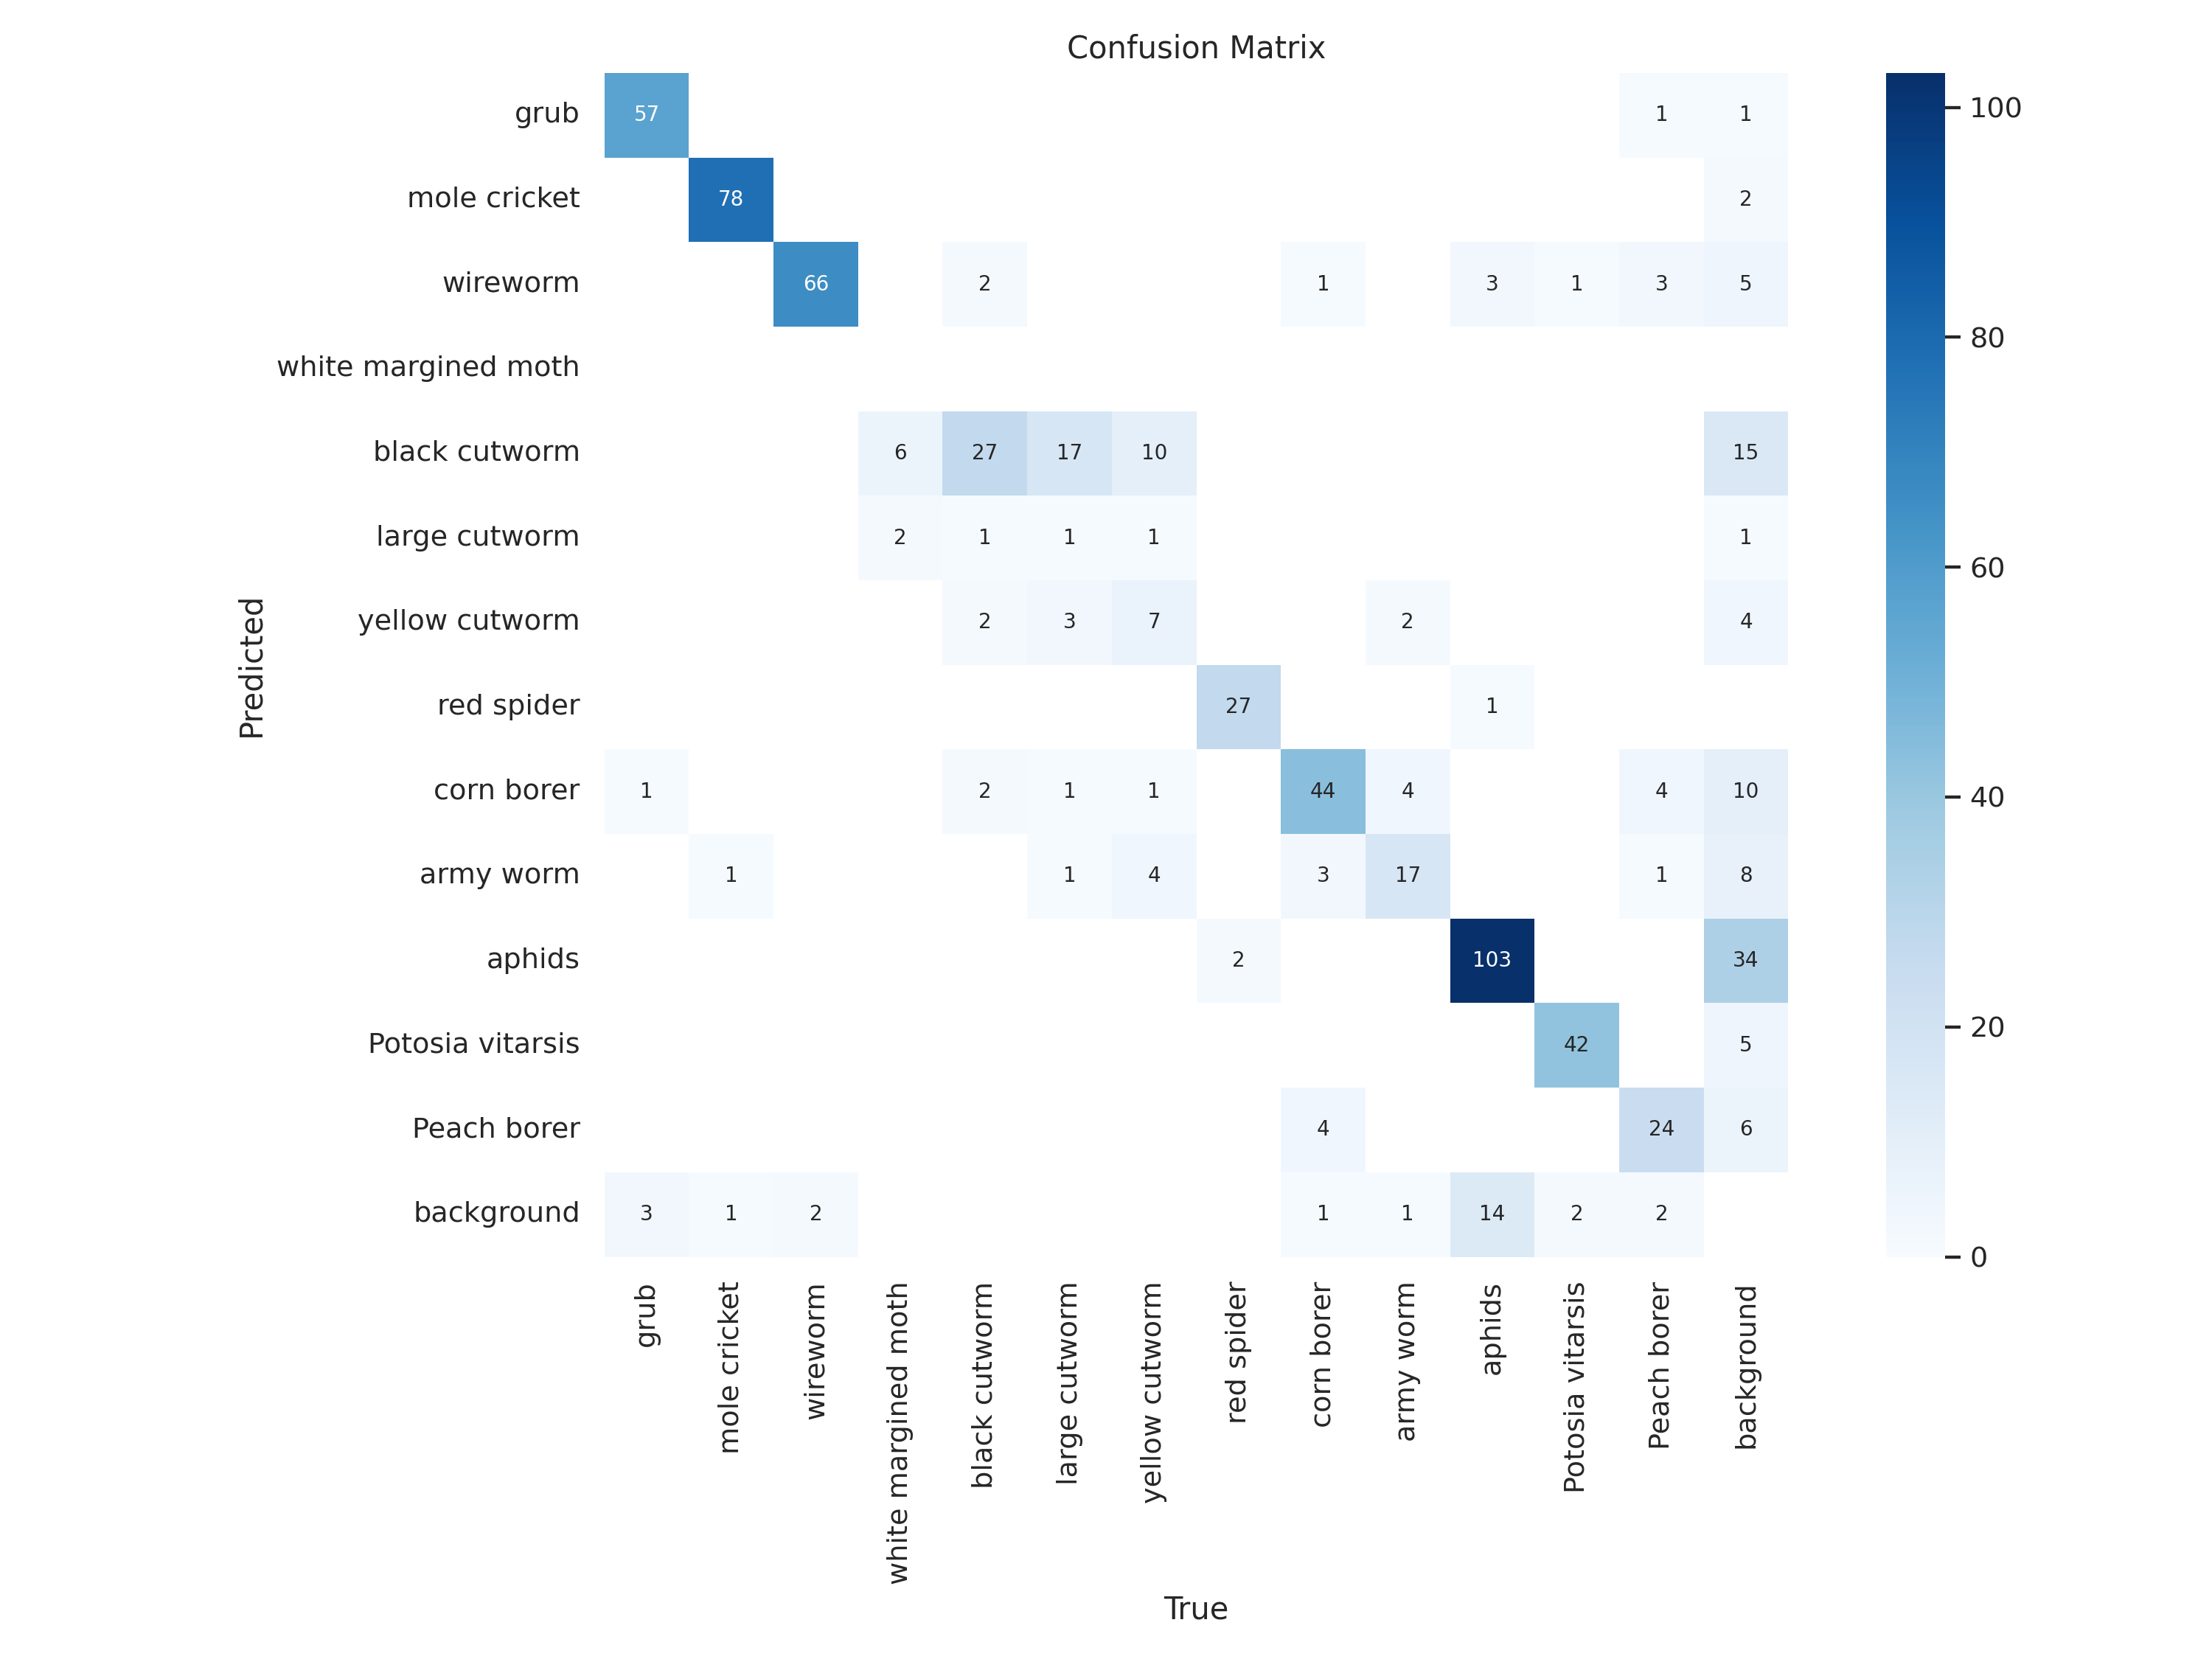

In [ ]:
Img(filename='YOLOv8-Pest/EX1/confusion_matrix.png', height=400)

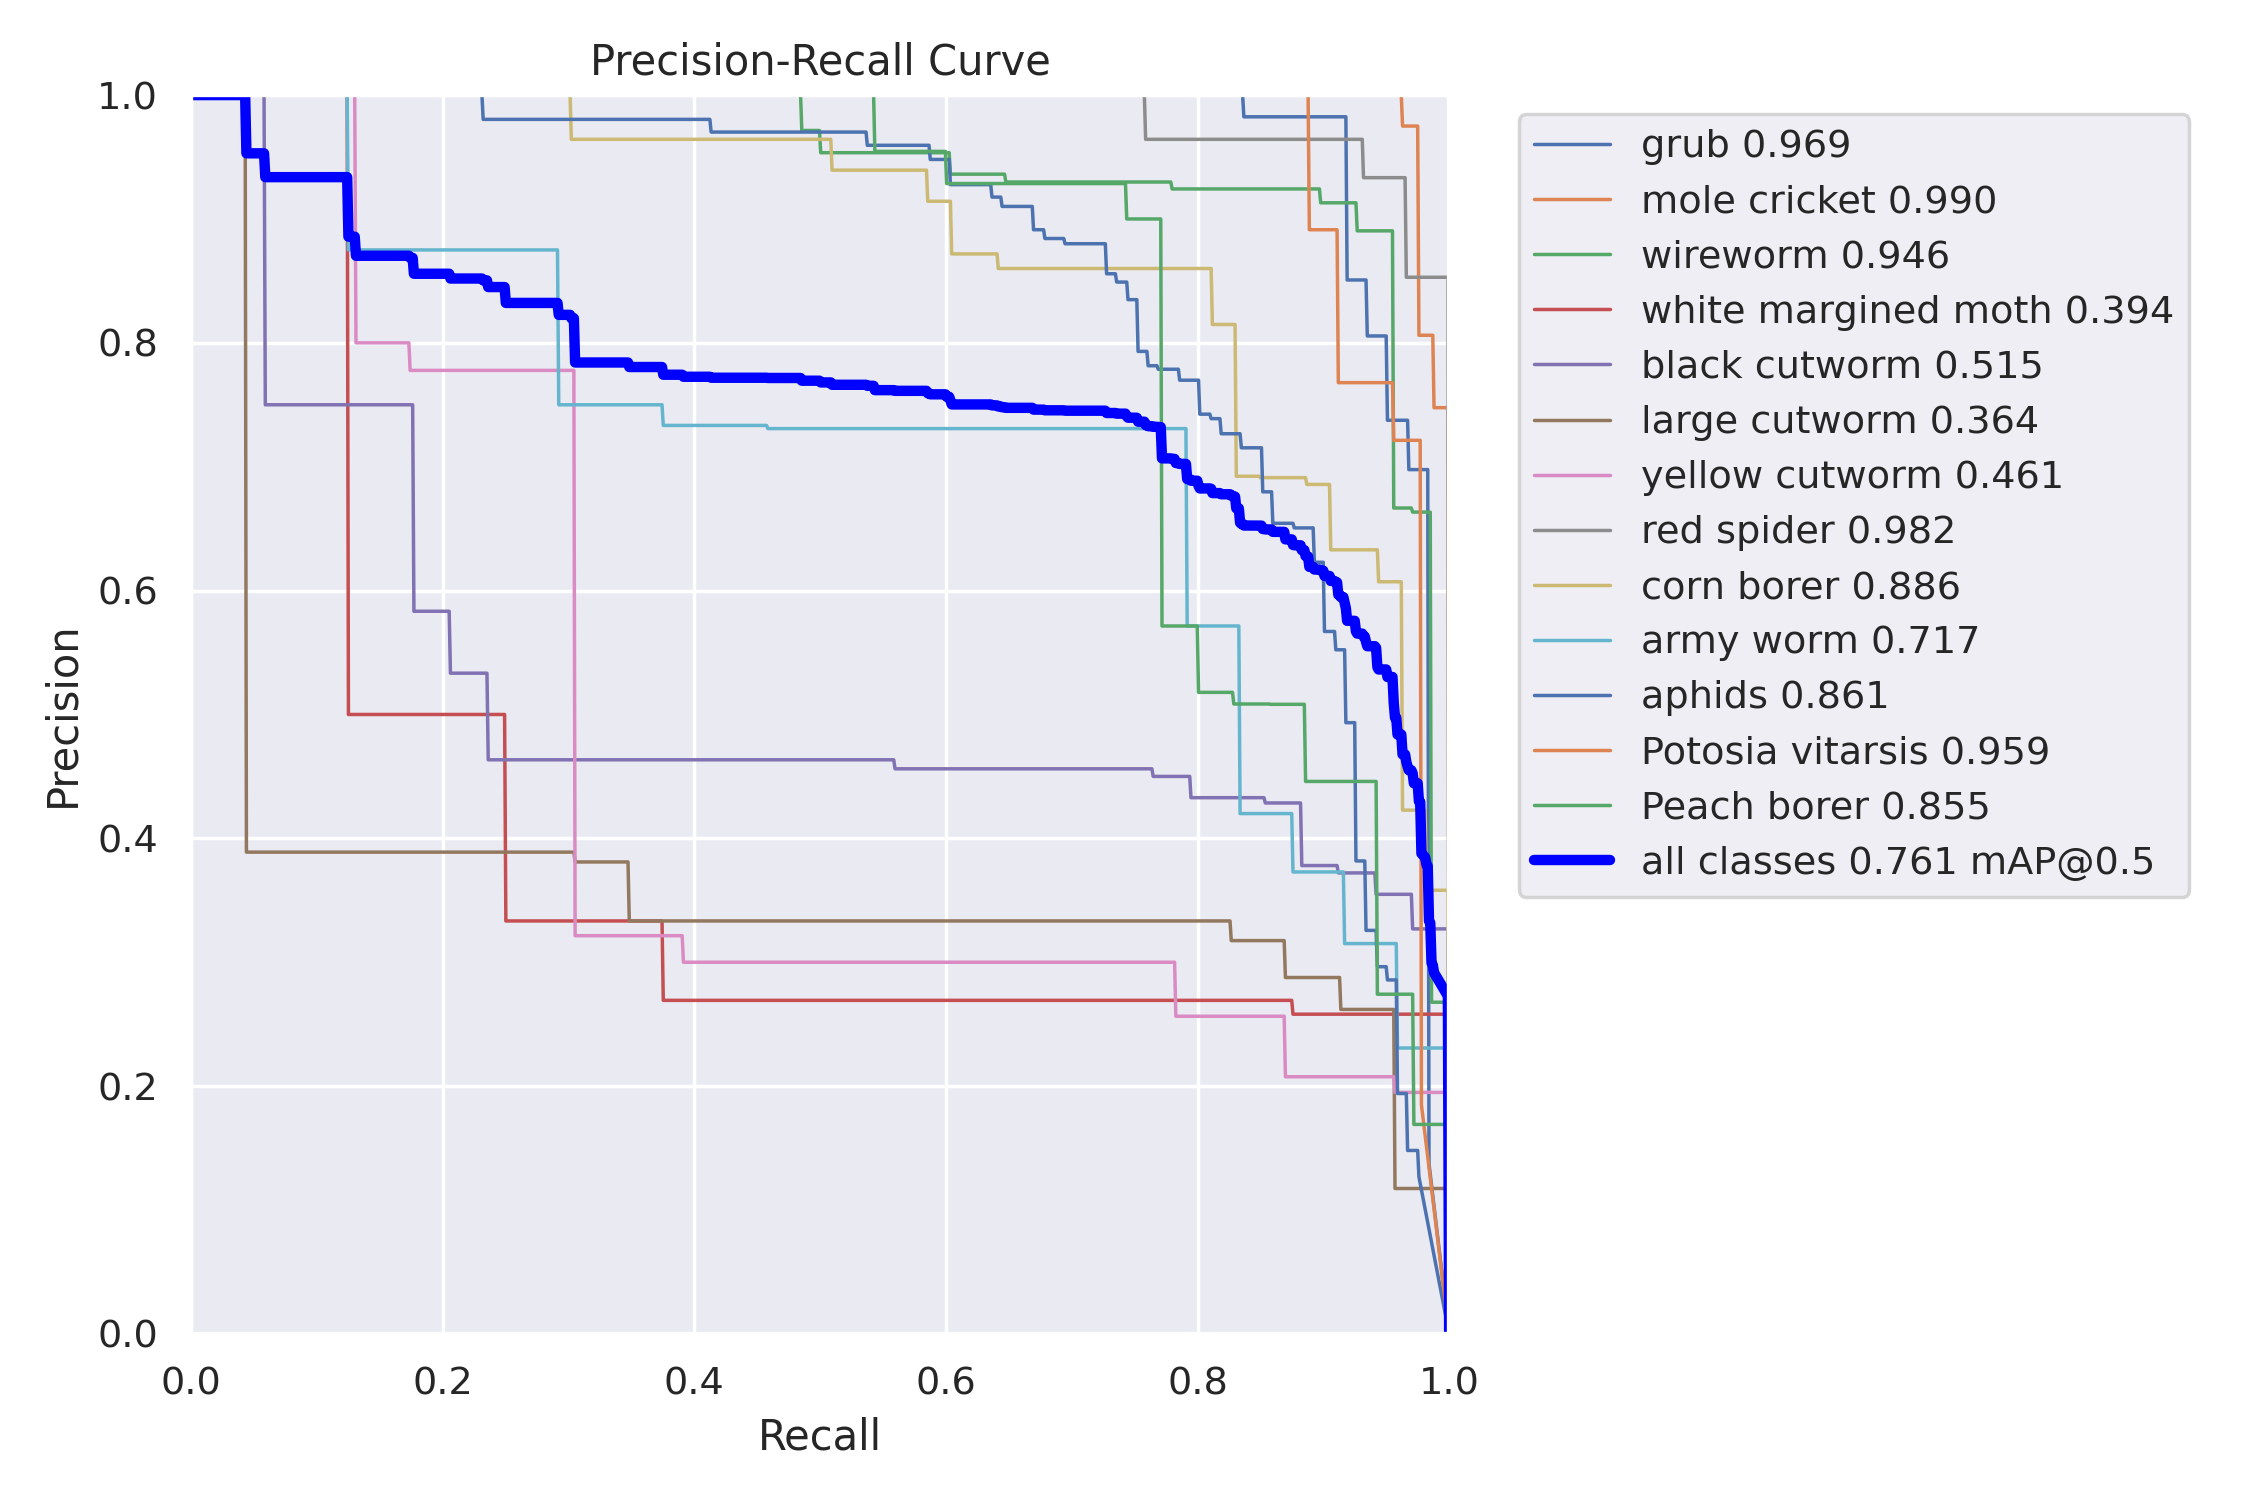

In [ ]:
Img(filename='YOLOv8-Pest/EX1/PR_curve.png', height=400)

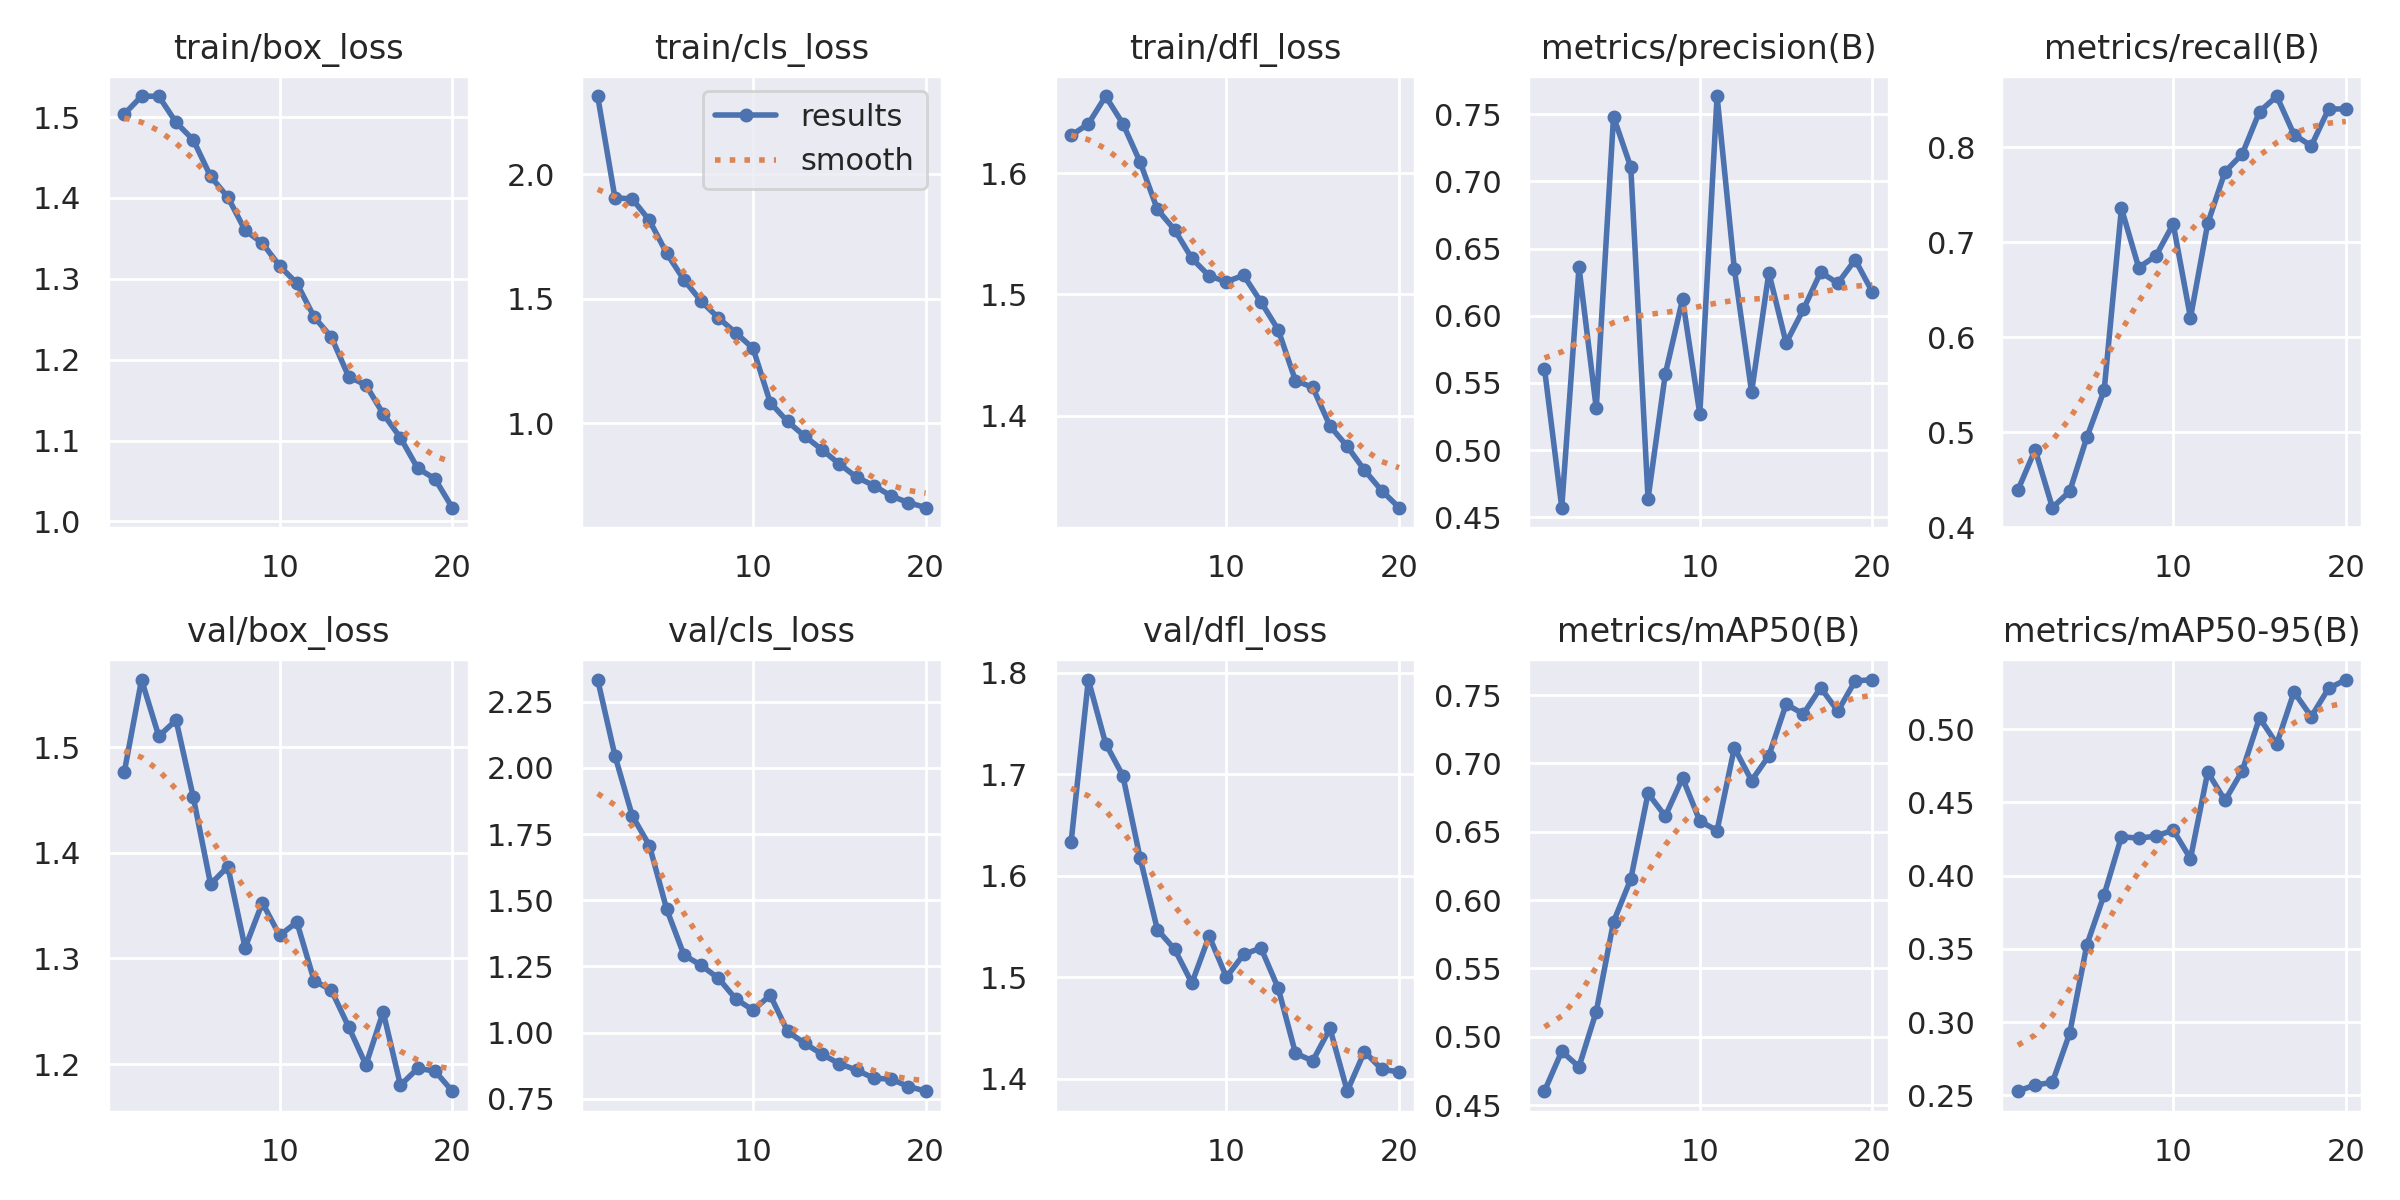

In [ ]:
Img(filename=f'YOLOv8-Pest/EX1/results.png', width=1200)

## YOLO evaluation on test dataset

In [ ]:
# Changing the validation dataset in the YAML configuration file
with open('data.yaml', 'r') as file:
    data = yaml.safe_load(file)
data['val'] = 'test/images'

# Open the configuration file in write mode to update configuration in YAML format
with open('data.yaml', 'w') as file:
    yaml.dump(data, file)

In [ ]:
# Running validation with the yolo command-line tool
!yolo val model=YOLOv8-Pest/EX1/weights/best.pt data=data.yaml imgsz=416 batch=32 conf=0.25 iou=0.5 device=0

Ultralytics YOLOv8.2.18 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (NVIDIA L4, 22700MiB)
Model summary (fused): 218 layers, 25847287 parameters, 0 gradients, 78.7 GFLOPs
val: Scanning /content/datasets/dataset-yolo/test/labels... 909 images, 0 backgrounds, 0 corrupt: 100% 909/909 [00:00<00:00, 1389.71it/s]
val: New cache created: /content/datasets/dataset-yolo/test/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 29/29 [00:09<00:00,  3.04it/s]
                   all        909       1113      0.692       0.72      0.725      0.521
                  grub        909        118      0.872      0.983      0.959      0.648
          mole cricket        909        176      0.972      0.977      0.986      0.603
              wireworm        909        109      0.792      0.945      0.922      0.673
   white margined moth        909         13          1     0.0769      0.538      0.377
         black cutworm        909         67     

### Visualization of YOLO model's performance on test data

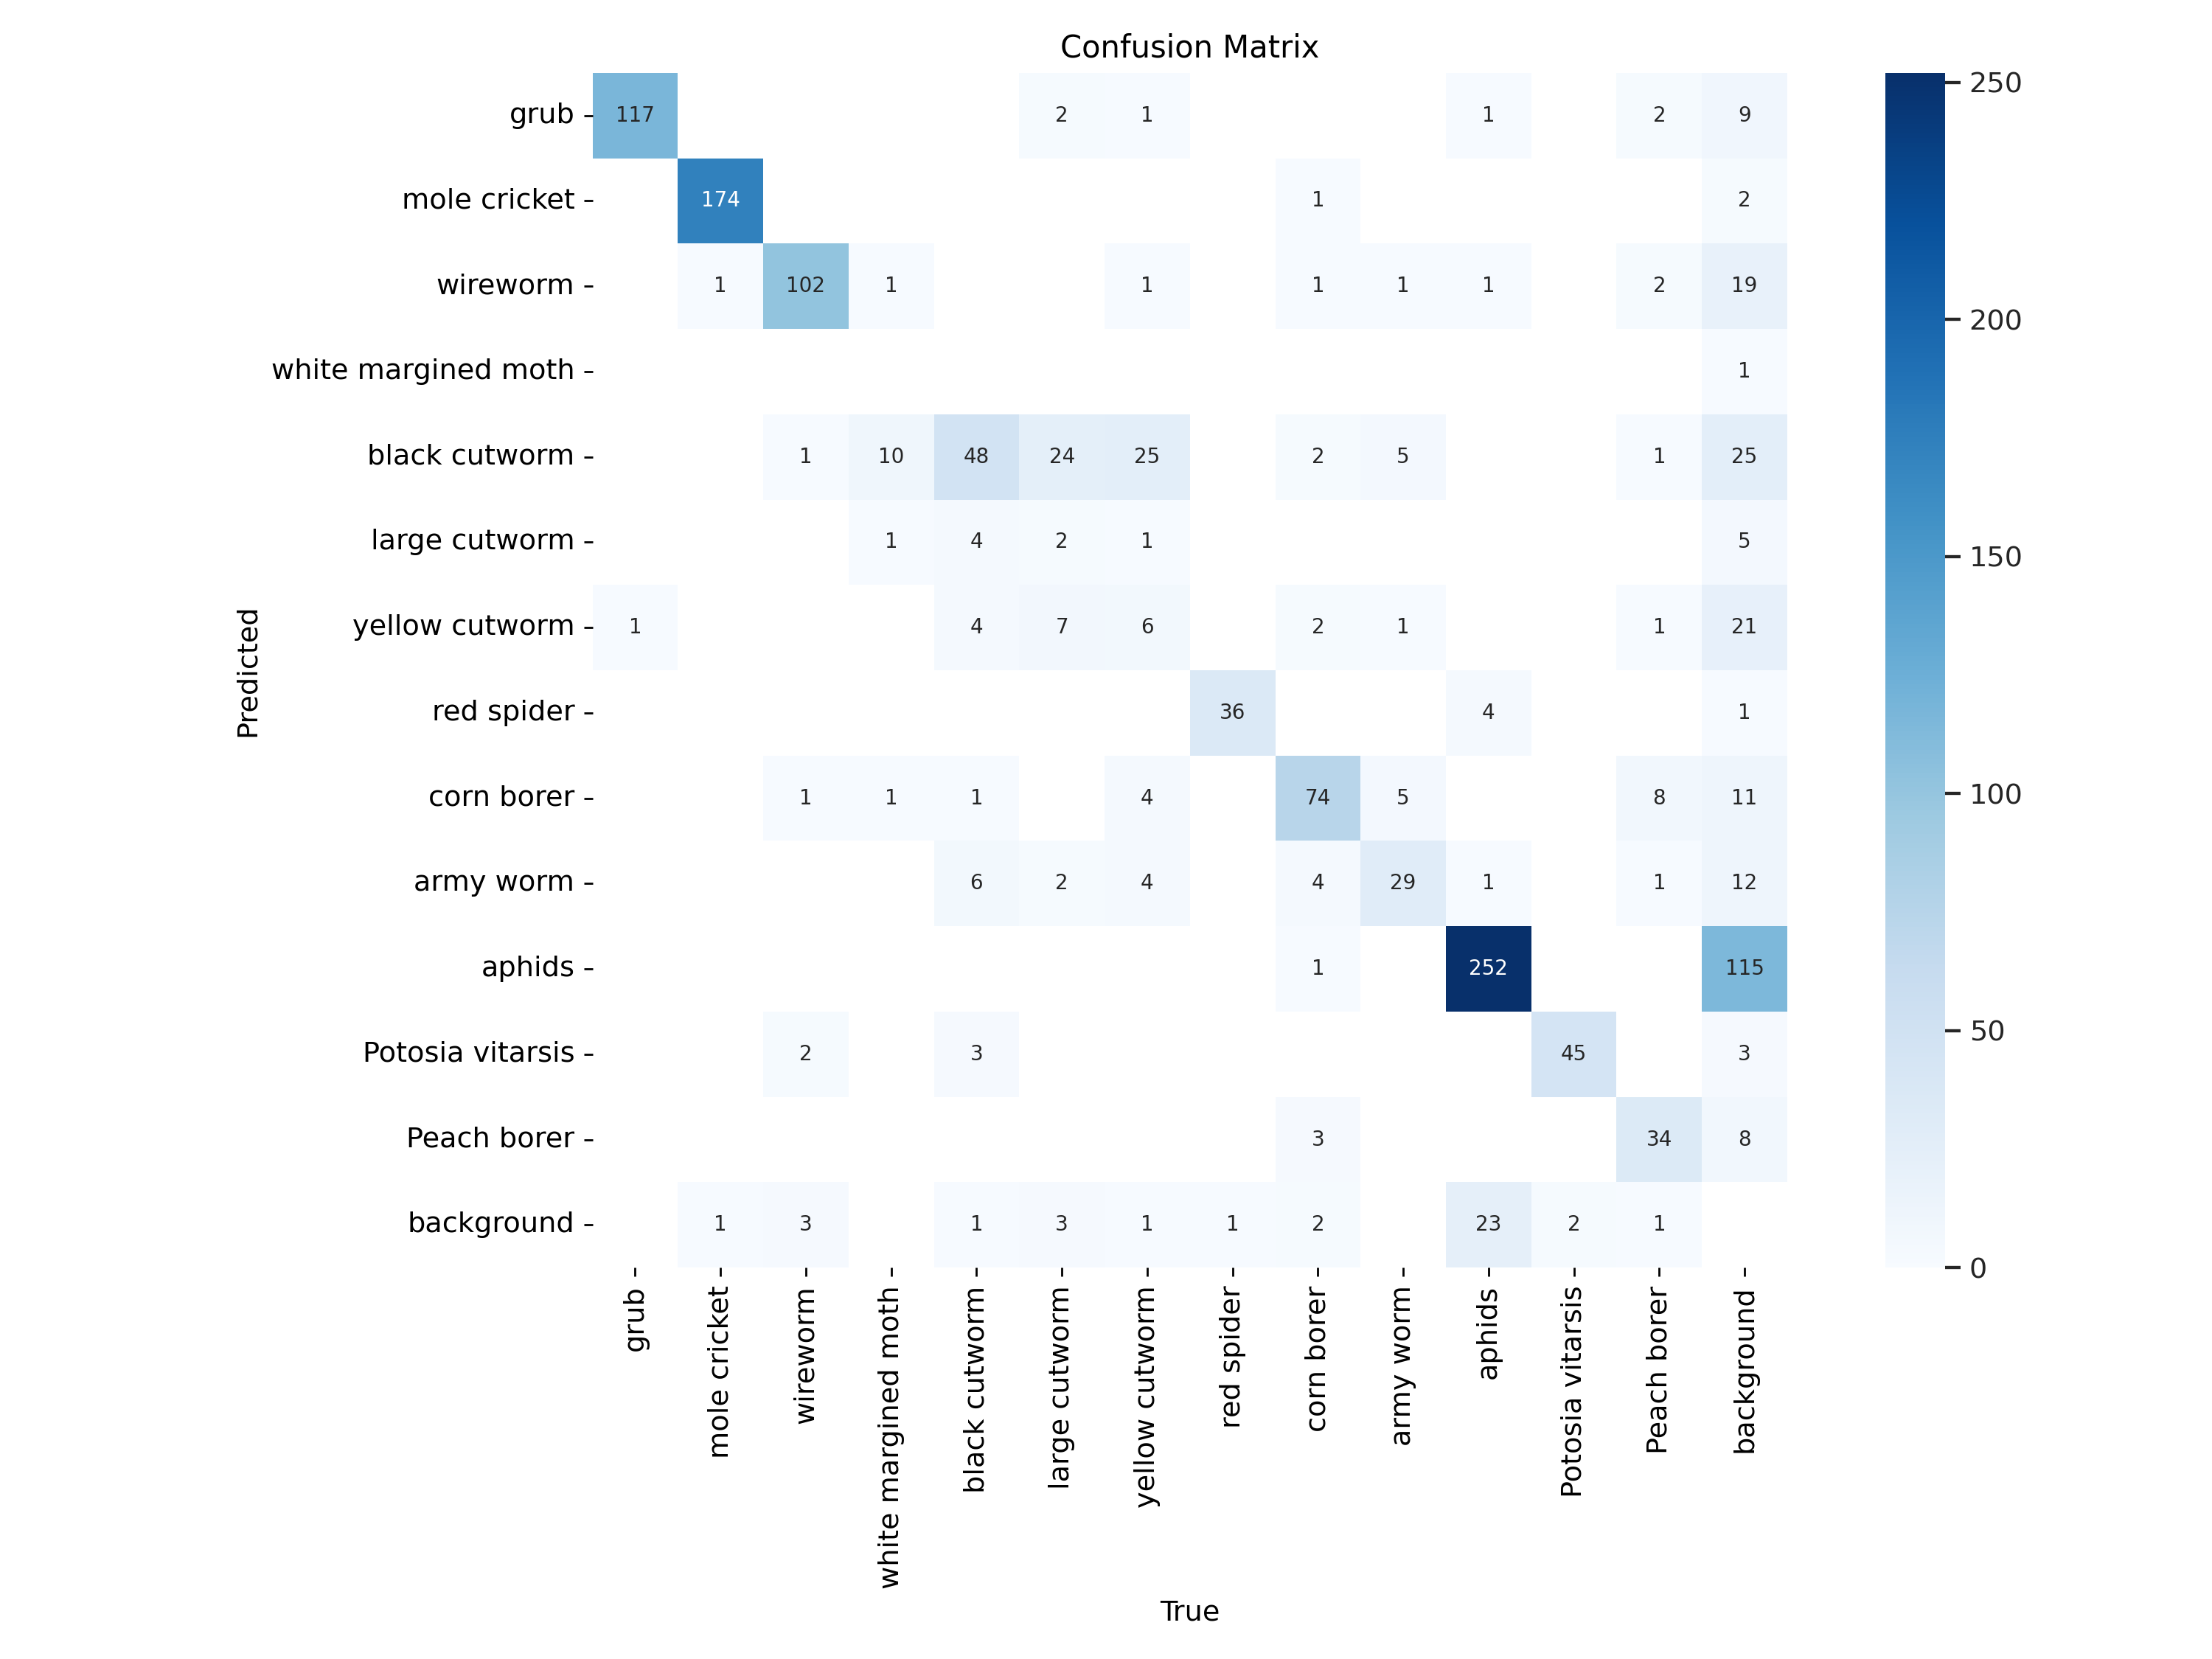

In [ ]:
Img(filename=f'runs/detect/val/confusion_matrix.png', width=600)

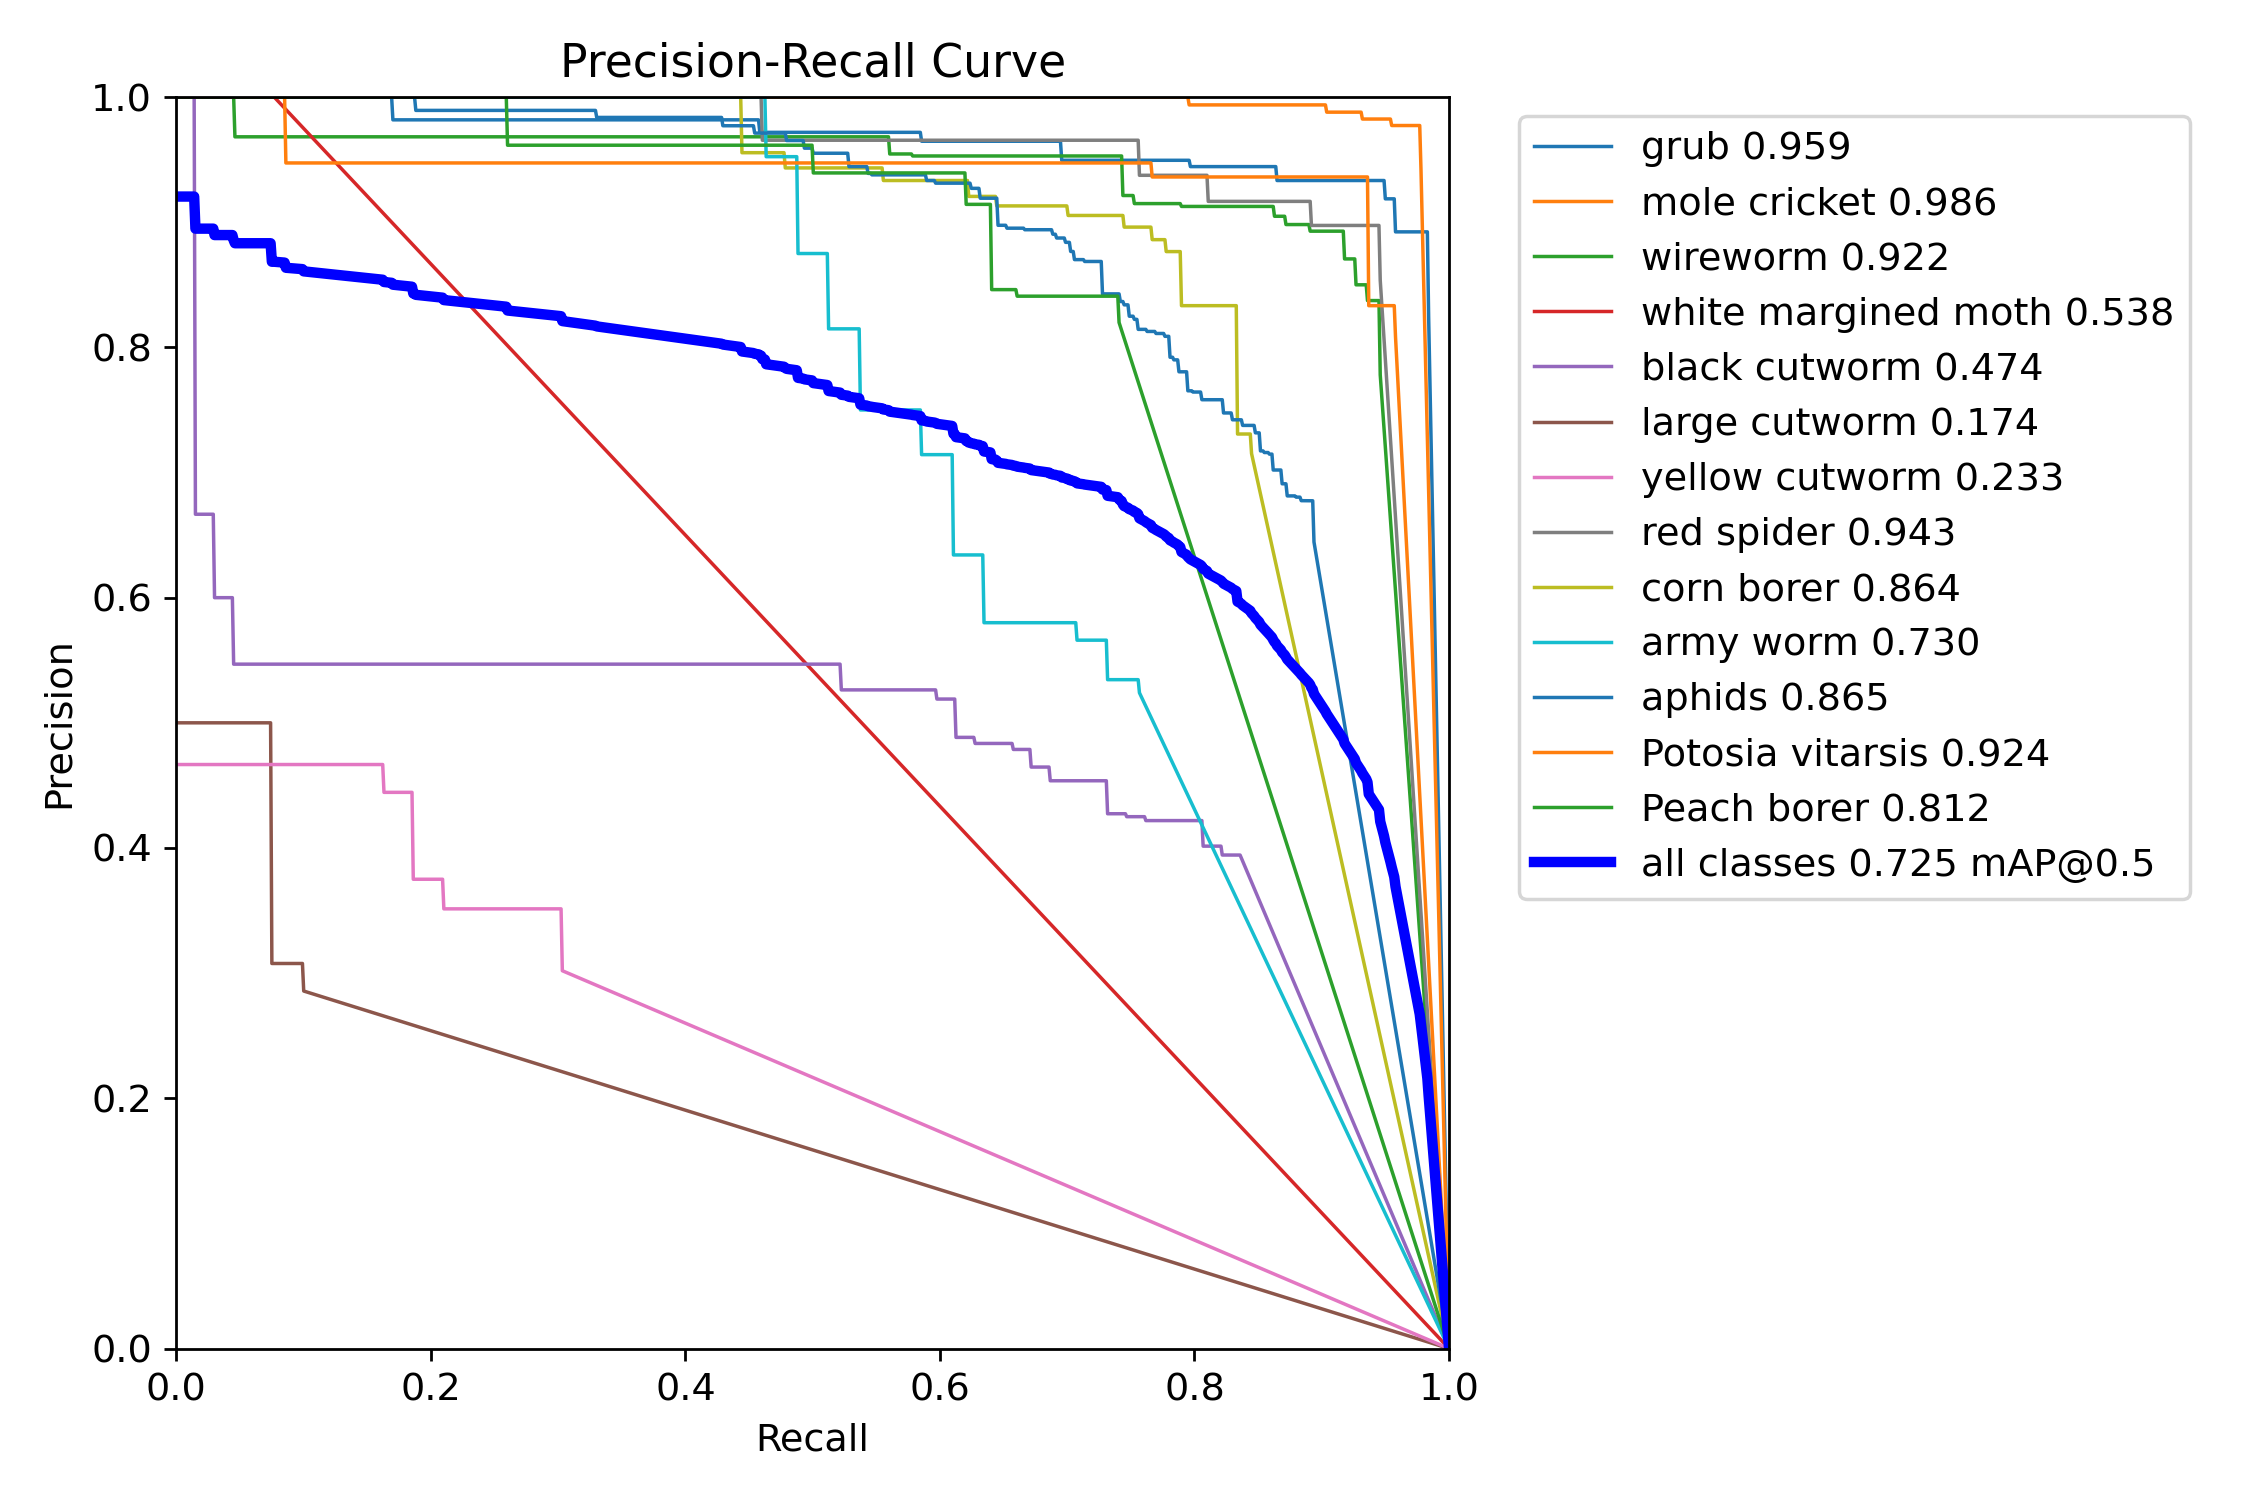

In [ ]:
Img(filename=f'runs/detect/val/PR_curve.png', width=600)

## YOLO Inference

In [ ]:
# Run object detection with the yolo command-line tool
!yolo task=detect mode=predict model=YOLOv8-Pest/EX1/weights/best.pt conf=0.25 source='VOC2007/JPEGImages/IP015000573.jpg' save=True

Ultralytics YOLOv8.2.18 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (NVIDIA L4, 22700MiB)
Model summary (fused): 218 layers, 25847287 parameters, 0 gradients, 78.7 GFLOPs

image 1/1 /content/VOC2007/JPEGImages/IP015000573.jpg: 320x416 1 mole cricket, 150.0ms
Speed: 3.1ms preprocess, 150.0ms inference, 2151.5ms postprocess per image at shape (1, 3, 320, 416)
Results saved to runs/detect/predict
💡 Learn more at https://docs.ultralytics.com/modes/predict


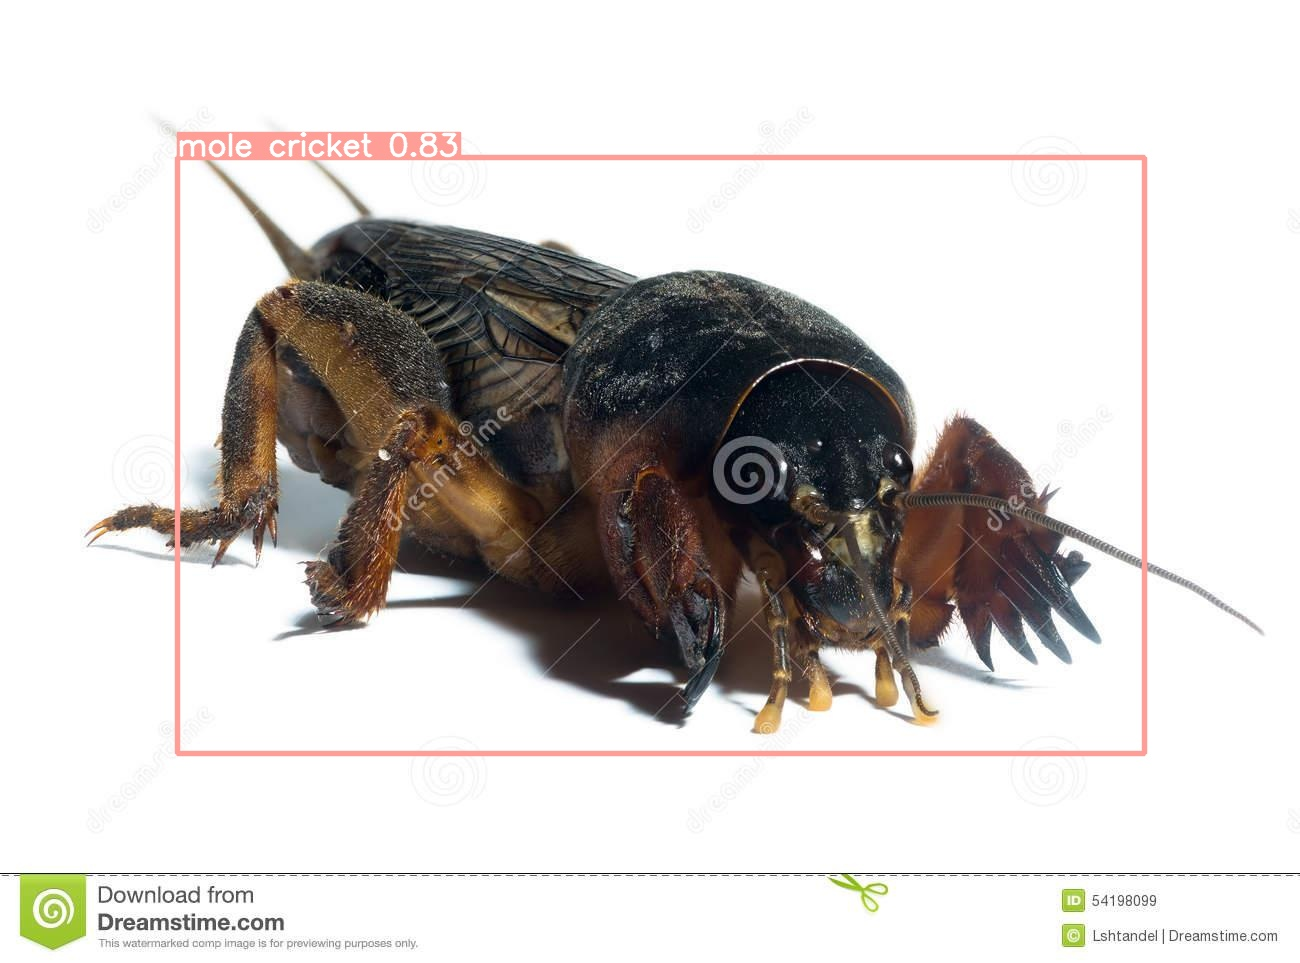

In [ ]:
Img(filename='runs/detect/predict/IP015000573.jpg', height=600)

# Download Results

In [ ]:
!zip -r /content/YOLOv8-Pest.zip /content/YOLOv8-Pest

  adding: content/YOLOv8-Pest/ (stored 0%)
  adding: content/YOLOv8-Pest/EX1/ (stored 0%)
  adding: content/YOLOv8-Pest/EX1/train_batch3891.jpg (deflated 15%)
  adding: content/YOLOv8-Pest/EX1/val_batch1_pred.jpg (deflated 10%)
  adding: content/YOLOv8-Pest/EX1/confusion_matrix.png (deflated 19%)
  adding: content/YOLOv8-Pest/EX1/train_batch1.jpg (deflated 8%)
  adding: content/YOLOv8-Pest/EX1/val_batch2_labels.jpg (deflated 12%)
  adding: content/YOLOv8-Pest/EX1/weights/ (stored 0%)
  adding: content/YOLOv8-Pest/EX1/weights/last.pt (deflated 8%)
  adding: content/YOLOv8-Pest/EX1/weights/best.pt (deflated 8%)
  adding: content/YOLOv8-Pest/EX1/labels_correlogram.jpg (deflated 34%)
  adding: content/YOLOv8-Pest/EX1/val_batch1_labels.jpg (deflated 11%)
  adding: content/YOLOv8-Pest/EX1/train_batch3890.jpg (deflated 13%)
  adding: content/YOLOv8-Pest/EX1/results.csv (deflated 83%)
  adding: content/YOLOv8-Pest/EX1/PR_curve.png (deflated 6%)
  adding: content/YOLOv8-Pest/EX1/args.yaml (defl

In [ ]:
!zip -r /content/matrices.zip /content/matrices

  adding: content/matrices/ (stored 0%)
  adding: content/matrices/densenet121_val_confusion_matrix.png (deflated 16%)
  adding: content/matrices/densenet121_confusion_matrix.png (deflated 18%)
  adding: content/matrices/resnet50_mAP.png (deflated 7%)
  adding: content/matrices/densenet121_PR_curve.png (deflated 8%)
  adding: content/matrices/resnet50_confusion_matrix.png (deflated 13%)
  adding: content/matrices/resnet50_val_confusion_matrix.png (deflated 13%)
  adding: content/matrices/densenet121_mAP.png (deflated 9%)
  adding: content/matrices/densenet121_training_loss.png (deflated 12%)
  adding: content/matrices/resnet50_val_PR_curve.png (deflated 5%)
  adding: content/matrices/resnet50_training_loss.png (deflated 13%)
  adding: content/matrices/resnet50_PR_curve.png (deflated 6%)
  adding: content/matrices/densenet121_val_PR_curve.png (deflated 6%)


In [ ]:
!zip -r /content/results.zip /content/results

  adding: content/results/ (stored 0%)
  adding: content/results/IP015001020.jpg (deflated 16%)
  adding: content/results/IP000000857.jpg (deflated 11%)


# References
Amir22010, 2020. Convert PascalVOC Annotations to YOLO [online]. Available from: https://gist.github.com/Amir22010/a99f18ca19112bc7db0872a36a03a1ec [Accessed 21 May 2024].

PyTorch, 2017. SOURCE CODE FOR TORCHVISION.MODELS.DETECTION.FASTER_RCNN [online]. Available from: https://pytorch.org/vision/0.12/_modules/torchvision/models/detection/faster_rcnn.html [Accessed 21 May 2024].

Ultralytics, 2024. Ultralytics YOLOv8 Docs [online]. Available from: https://docs.ultralytics.com [Accessed 21 May 2024].

xpwu95, 2022. IP102: A Large-Scale Benchmark Dataset for Insect Pest Recognition [online]. Available from: https://github.com/xpwu95/IP102 [Accessed 21 May 2024].
